# Hidden Markov Model

In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from hmmlearn import hmm
from Performance import performance_review
import warnings
warnings.filterwarnings("ignore")

# HMM Model on HSI Close Price

# Data Collection

In [2]:
ticker = '^HSI'
start = '2000-01-01'
end = '2024-08-23'
freq = '1d'

In [3]:
data_df = yf.download(ticker, start = start, end = end ,interval = freq)

[*********************100%***********************]  1 of 1 completed


In [4]:
data_df

Open          High           Low         Close  \
Date                                                                 
2000-01-03  17057.699219  17426.160156  17057.699219  17369.630859   
2000-01-04  17303.000000  17303.000000  16933.519531  17072.820312   
2000-01-05  16608.550781  16608.550781  15688.490234  15846.719727   
2000-01-06  15942.070312  15971.030273  14763.969727  15153.230469   
2000-01-07  15329.339844  15513.889648  15108.750000  15405.629883   
...                  ...           ...           ...           ...   
2024-08-16  17286.039062  17473.890625  17255.859375  17430.160156   
2024-08-19  17569.660156  17685.859375  17547.650391  17569.570312   
2024-08-20  17661.689453  17661.689453  17449.990234  17511.080078   
2024-08-21  17313.859375  17415.480469  17232.130859  17391.009766   
2024-08-22  17497.630859  17652.800781  17389.939453  17641.000000   

               Adj Close      Volume  
Date                                  
2000-01-03  17369.630859           0  
2000-01-04  17072.820312           0  
2000-01-05  15846.719727           0  
2000-01-06  15153.230469           0  
2000-01-07  15405.629883           0  
...                  ...         ...  
2024-08-16  17430.160156  2551716800  
2024-08-19  17569.570312  2361570600  
2024-08-20  17511.080078  1961800000  
2024-08-21  17391.009766  2060224300  
2024-08-22  17641.000000  2945729800  

[6073 rows x 6 columns]

In [5]:
close_df = data_df['Close']

In [6]:
close_df

Date
2000-01-03    17369.630859
2000-01-04    17072.820312
2000-01-05    15846.719727
2000-01-06    15153.230469
2000-01-07    15405.629883
                  ...     
2024-08-16    17430.160156
2024-08-19    17569.570312
2024-08-20    17511.080078
2024-08-21    17391.009766
2024-08-22    17641.000000
Name: Close, Length: 6073, dtype: float64

In [7]:
train_test_split_pt = "2019-12-31"
close_train_df = close_df.loc[close_df.index <= train_test_split_pt]
close_test_df = close_df.loc[close_df.index > train_test_split_pt]

# Data Preprocess

In [8]:
train_log_close_diff_df = np.log(close_train_df).diff().dropna()
mean = train_log_close_diff_df.mean(axis = 0)
std = train_log_close_diff_df.std(axis = 0)
norm_train_log_close_diff_df = (train_log_close_diff_df - mean)/std

In [52]:
print("skew: ", scipy.stats.skew(norm_train_log_close_diff_df, axis = 0, bias = True))
print("kurtosis: ", scipy.stats.kurtosis(norm_train_log_close_diff_df, axis = 0, bias = True))
print("skewtest pvalue: ", scipy.stats.skewtest(norm_train_log_close_diff_df).pvalue)
print("kurtosistest pvalue: ", scipy.stats.kurtosistest(norm_train_log_close_diff_df).pvalue)
print("KS-test pvalue: ", scipy.stats.kstest(norm_train_log_close_diff_df,  "norm").pvalue)

mean:  2.0609739653723235e-18
std:  1.0000000000000002
skew:  -0.10384681470615739
kurtosis:  8.099700810350752
skewtest pvalue:  0.0029489626215346574
kurtosistest pvalue:  1.6478071476676528e-168
KS-test pvalue:  6.015732148788219e-23


# QQ Plot

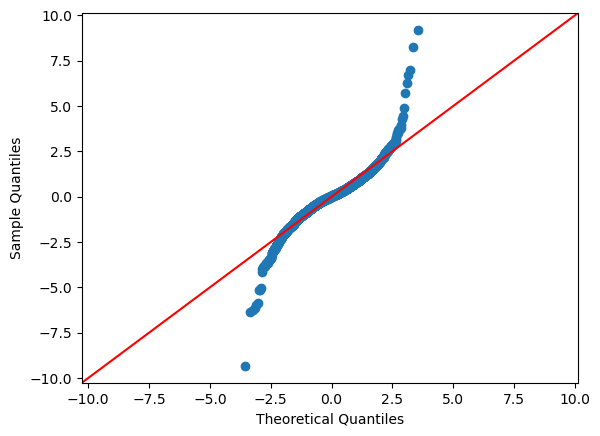

In [53]:
sm.qqplot(norm_train_log_close_diff_df, line = '45')
pylab.show()

# HMM Model Selection Citerion

(1) From empirical experience, the daily log return of market are not independent, and they are autocorrelated

(2) From chart and test above, the standardized daily log return does not follow sample standard normal

Therefore, we may use Guassian to model the daily log return given a hidden state. 

Then, we would use Markov Chain to model the transition between hidden states

# HMM Model

## HMM Model Background

Parameter :

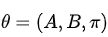

Random Variables : 

X_t : Hidden state at time t

Y_t : Observed value at time t

Initial States Probability:



Transition Matrix : 



Conditional Distribution of Y_t given X_t : 

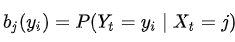

## HMM Model Training - Baum-Welch Algorithm

After the collection of realized observed variables, we can solve for the parameter that maximize the likelihood (probability) of the realzied observation.

Baum-Welch is EM-Algorithm on HMM

### Forward Procedure

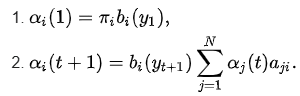

### Backward Procedure

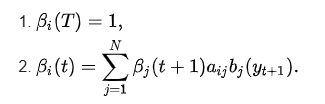

Step E : 

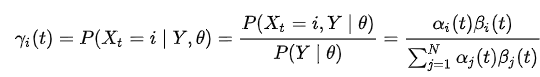

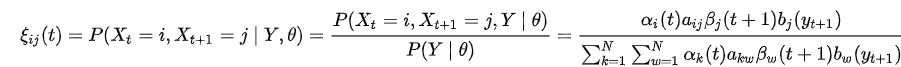

Step M : 

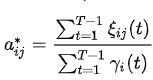

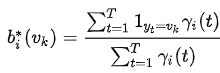


Reference : https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm

Python Package (hmmlearn) : https://hmmlearn.readthedocs.io/en/latest/index.html

### Three Hidden State HMM

In [83]:
# Fit HMM Model
three_state_model = hmm.GaussianHMM(n_components = 3, covariance_type = "full", n_iter = 200, random_state = 99)
X = train_log_close_diff_df.values
X = X.reshape(-1,1)
three_state_model.fit(X)

GaussianHMM(covariance_type='full', n_components=3, n_iter=200, random_state=99)

In [84]:
three_state_model.startprob_

array([0.00000000e+000, 1.00000000e+000, 1.79125357e-177])

In [85]:
three_state_model.transmat_

array([[6.19115441e-01, 1.35421767e-05, 3.80871017e-01],
       [2.11638890e-04, 9.82199497e-01, 1.75888638e-02],
       [9.74085139e-01, 1.38773814e-02, 1.20374800e-02]])

In [120]:
three_state_model.transmat_[0][:] @ three_state_model.means_

array([0.0001537])

In [86]:
three_state_model.means_

array([[ 0.00088295],
       [-0.00095556],
       [-0.00103169]])

In [87]:
three_state_model.covars_

array([[[7.68088586e-05]],

       [[6.68836731e-04]],

       [[2.00793795e-04]]])

In [88]:
hist_hidden_state = three_state_model.predict(X)

In [96]:
hist_hidden_state

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [106]:
sum((hist_hidden_state ==1)[:-1] * (X[:][1:]>0))

array([2545, 2545, 2545, ...,    0,    0,    0])

In [116]:
total_sum = sum((hist_hidden_state ==1)[:-1] * (X.reshape(1,-1)[0][1:]))

In [117]:
sum((np.sign((X.reshape(1,-1)[0][1:])) == np.sign(total_sum)) * (hist_hidden_state ==1)[:-1])

773

In [114]:
X.reshape(1,-1)[0][1:]

array([-0.07452522, -0.04474878,  0.01651928, ...,  0.01287988,
        0.00332376, -0.00458831])

In [98]:
three_state_model.predict_proba(X)

array([[0.00000000e+000, 1.00000000e+000, 2.92852282e-179],
       [2.46168135e-020, 9.99999961e-001, 3.87414867e-008],
       [8.20735312e-010, 9.99628208e-001, 3.71790798e-004],
       ...,
       [6.78841137e-001, 7.10450417e-004, 3.20448412e-001],
       [7.96479756e-001, 1.38542731e-003, 2.02134816e-001],
       [7.49234478e-001, 2.50377299e-003, 2.48261749e-001]])

# Trading Strategies

Background

We would implement dynamic HMM training method to reflect more up-to-date information

To do so, we would define a hyperparameter W as the lookback window of the information to be fitted for training, we train HMM recursively on each trading date

### Strategy (1) : 

o_t = g_t = log return

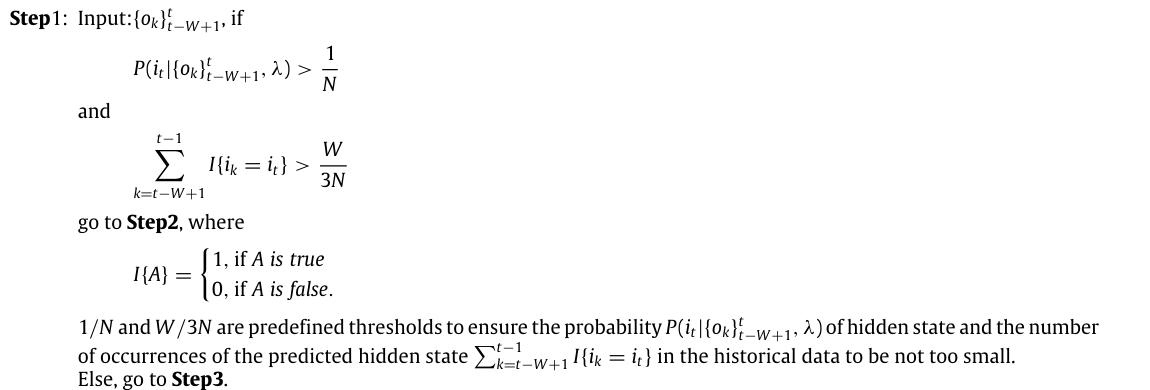



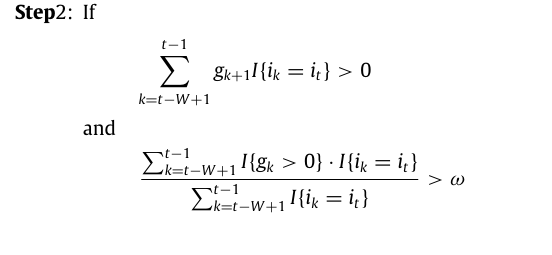

#Typo : g_t+1 instead of g_t

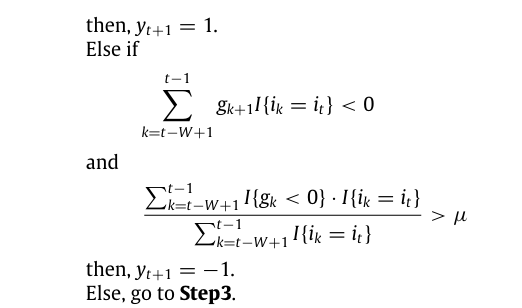

#Typo : g_t+1 instead of g_t

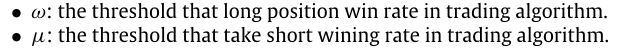



reference : 

High-order Hidden Markov Model for trend prediction in financial time series

https://edisciplinas.usp.br/pluginfile.php/5748773/mod_folder/content/0/Zhang-2019-High-order%20Hidden%20Markov%20Model%20for%20trend%20prediction%20in%20financial%20time%20series.pdf

### Strategy (2)

Instead of using the empirical relation between current hidden state and next day return, we may look at the conditional next day log return given current hidden state

$$E(Y_(t+1)|X_t = i) > \mu$$, then signal = 1

$$E(Y_(t+1)|X_t = i) < -\mu$$, then signal = -1

In [2]:
class HMM_Trading_Model:
    
    def __init__(self, N, model):
        
        self.data = None
        self.N = N
        self.model = model
        
    def train(self, data):
        
        self.data = data
        self.model.fit(data)
        
    def hist_hidden_state(self):
        
        return self.model.predict(self.data)
        
    def latest_hidden_state(self):
        
        return self.hist_hidden_state()[-1]
    
    def latest_hidden_state_post_prob(self):
        
        return self.model.predict_proba(self.data)[-1, self.latest_hidden_state()]
    
    def transition_matrix(self):
        
        return self.model.transmat_
    
    def cond_observation_mean(self):
        
        return self.model.means_
    
    def strat_one_signal_generation_info(self):
        
        latest_hidden_state_post_prob = self.latest_hidden_state_post_prob()
        occurence_latest_hidden_state = sum(self.hist_hidden_state() == self.latest_hidden_state())
        total_hist_next_day_observation_given_state = sum(self.data[:,0].reshape(1,-1)[0][1:] * (self.hist_hidden_state() == self.latest_hidden_state())[:-1])
        win_rate = sum((np.sign(self.data[:,0].reshape(1,-1)[0][1:]) == np.sign(total_hist_next_day_observation_given_state)) * (self.hist_hidden_state() == self.latest_hidden_state())[:-1])/sum((self.hist_hidden_state() == self.latest_hidden_state())[:-1])
        
        return latest_hidden_state_post_prob, occurence_latest_hidden_state, total_hist_next_day_observation_given_state, win_rate
    
    def strat_two_signal_generation_info(self):
        
        cond_next_daily_ret_mean = (self.transition_matrix()[self.latest_hidden_state()][:] @ self.cond_observation_mean())[0]
        
        return cond_next_daily_ret_mean
    
    def empirical_kelly_betting_size(self):
        
        hist_hidden_state = self.hist_hidden_state()
        latest_hidden_state = self.latest_hidden_state()
        next_day_observation_given_state = self.data[np.where(hist_hidden_state == latest_hidden_state)[0][:-1] + np.array(1), 0]
        mean = np.mean(next_day_observation_given_state)
        var  = np.var(next_day_observation_given_state)
        
        return abs(mean/var)
    
    def model_kelly_betting_size(self):
        latest_hidden_state = self.latest_hidden_state()
        mu_1 = self.model.means_[latest_hidden_state][0]
        sigma_11 = self.model.covars_[latest_hidden_state][0,0]
        mu_2 = self.model.means_[latest_hidden_state][1:]
        sigma_12 = self.model.covars_[latest_hidden_state][0,1:]
        sigma_21 = self.model.covars_[latest_hidden_state][1:,0]
        sigma_22 = self.model.covars_[latest_hidden_state][1: ,1:]
        
        mean = mu_1 + sigma_12@np.linalg.inv(sigma_22)@(self.data[-1][1:] - mu_2)
        covar = sigma_11 - sigma_12@np.linalg.inv(sigma_22)@sigma_21
        
        return abs(mean/covar)
        
    
    def strat_one_signal(self, long_win_rate_thres = 0, short_win_rate_thres = 0):
        
        W = len(self.data)
        N = self.N
        
        latest_hidden_state_post_prob, occurence_latest_hidden_state, total_hist_next_day_observation_given_state, win_rate = self.strat_one_signal_generation_info()
        
        # step 1
        
        if (latest_hidden_state_post_prob <= 1/N or occurence_latest_hidden_state <= W/(3*N)):
            
            return 0
        
        else:
        
        # step 2
        
            if np.sign(total_hist_next_day_observation_given_state) > 0 and win_rate > long_win_rate_thres:
                
                return 1
            
            elif np.sign(total_hist_next_day_observation_given_state) < 0 and win_rate > short_win_rate_thres:
                
                return -1
            
            else:
                return 0
            
    def strat_two_signal(self, long_thres = 0, short_thres = 0):
        
        #Tower Property
        cond_next_daily_ret_mean = self.strat_two_signal_generation_info()
        
        if cond_next_daily_ret_mean > long_thres :
            return 1
        elif cond_next_daily_ret_mean < short_thres :
            return -1
        else :
            return 0
            

In [3]:
# Signal Generation

def model_recursive_training(data_df, N, model, W):
    
    data_len = len(data_df)
    
    latest_hidden_post_prob_ls = []
    occurence_latest_hidden_state_ls = []
    total_hist_next_day_observation_given_state_ls = []
    win_rate_ls = []
    cond_next_daily_ret_mean_ls = []
    em_kelly_bs_ls = []
    model_kelly_bs_ls = []

    
    for i in range(W, data_len):
        
        print(i)
        
        # obtain data input
        
        curr_data_input = data_df.iloc[(i-W):i]
        o_t = np.array(curr_data_input).reshape(-1,len(data_df.columns))
        
        # model training
        
        model.train(o_t)
        
        # signal info generation
        
        latest_hidden_state_post_prob, occurence_latest_hidden_state, total_hist_next_day_observation_given_state, win_rate = model.strat_one_signal_generation_info()
        cond_next_daily_ret_mean = model.strat_two_signal_generation_info()
        empirical_kelly_betting_size = model.empirical_kelly_betting_size()
        model_kelly_betting_size = model.model_kelly_betting_size()
        
        latest_hidden_post_prob_ls.append(latest_hidden_state_post_prob)
        occurence_latest_hidden_state_ls.append(occurence_latest_hidden_state)
        total_hist_next_day_observation_given_state_ls.append(total_hist_next_day_observation_given_state)
        win_rate_ls.append(win_rate)
        cond_next_daily_ret_mean_ls.append(cond_next_daily_ret_mean)
        em_kelly_bs_ls.append(empirical_kelly_betting_size)
        model_kelly_bs_ls.append(model_kelly_betting_size)

        
    signal_info_df = pd.DataFrame(index = data_df.index[W:data_len])
    signal_info_df['latest_hidden_post_prob'] = latest_hidden_post_prob_ls
    signal_info_df['occurence_latest_hidden_state'] = occurence_latest_hidden_state_ls
    signal_info_df['total_hist_next_day_observation_given_state'] = total_hist_next_day_observation_given_state_ls
    signal_info_df['win_rate'] = win_rate_ls
    signal_info_df['cond_next_daily_ret_mean'] = cond_next_daily_ret_mean_ls
    signal_info_df['empirical_kelly_betting_size'] = em_kelly_bs_ls
    signal_info_df['model_kelly_betting_size'] = model_kelly_bs_ls
    
    
    return signal_info_df

def signal_generation(signal_info_df, signal_type, long_thres, short_thres, W = None, N = None):
    
    signal_ls = []
    
    for i in range(len(signal_info_df)):
        
        if signal_type == 1:
            
            occurence_latest_hidden_state = signal_info_df.occurence_latest_hidden_state.iloc[i]
            total_hist_next_day_observation_given_state = signal_info_df.total_hist_next_day_observation_given_state.iloc[i]
            win_rate = signal_info_df.win_rate.iloc[i]
            
            # step 1
        
            if  occurence_latest_hidden_state <= W/(3*N):

                signal = 0

            else:

            # step 2

                if np.sign(total_hist_next_day_observation_given_state) > 0 and win_rate > long_thres:

                    signal = 1

                elif np.sign(total_hist_next_day_observation_given_state) < 0 and win_rate > short_thres:

                    signal = -1

                else:
                    signal = 0


        elif signal_type == 2:
            
            cond_next_daily_ret_mean = signal_info_df.cond_next_daily_ret_mean.iloc[i]
        
            if cond_next_daily_ret_mean > long_thres :
                
                signal = 1
                
            elif cond_next_daily_ret_mean < short_thres :
                
                signal = -1
                
            else :
                
                signal = 0

        else:
                print("Invalid signal type")
                return None
            
        signal_ls.append(signal)
        
    signal_df = pd.DataFrame(index = signal_info_df.index)
    signal_df['signal'] = signal_ls
    
    return signal_df

    

## Model Training

In [12]:
data_df = np.log(close_df).diff().dropna()

N = 3
three_state_ghmm_model = hmm.GaussianHMM(n_components = N, covariance_type = "diag", n_iter = 1000, random_state = 99)
three_state_ghmm_trading_model = HMM_Trading_Model(N, three_state_ghmm_model)
W = 200

#model recursive_training
signal_info_df = model_recursive_training(data_df, N, three_state_ghmm_trading_model, W)

NameError: name 'close_df' is not defined

In [97]:
signal_info_df.to_csv("GHMM_Hidden_State_3_W_200.csv")

In [98]:
signal_info_df

latest_hidden_post_prob  occurence_latest_hidden_state  \
Date                                                                 
2000-10-25                 0.532816                             98   
2000-10-26                 0.359389                            100   
2000-10-27                 0.569768                             99   
2000-10-30                 0.403009                            100   
2000-10-31                 0.576738                            100   
...                             ...                            ...   
2024-08-16                 0.422561                            100   
2024-08-19                 0.561867                            101   
2024-08-20                 0.397766                            100   
2024-08-21                 0.431097                            100   
2024-08-22                 0.404113                            100   

            total_hist_next_day_observation_given_state  win_rate  \
Date                                                                
2000-10-25                                    -0.134764  0.536082   
2000-10-26                                    -0.173024  0.545455   
2000-10-27                                    -0.125746  0.530612   
2000-10-30                                    -0.193861  0.555556   
2000-10-31                                    -0.132019  0.535354   
...                                                 ...       ...   
2024-08-16                                    -0.028853  0.525253   
2024-08-19                                     0.043859  0.460000   
2024-08-20                                    -0.030827  0.525253   
2024-08-21                                     0.040160  0.454545   
2024-08-22                                    -0.017134  0.525253   

            cond_next_daily_ret_mean  
Date                                  
2000-10-25                  0.000016  
2000-10-26                 -0.000295  
2000-10-27                  0.000304  
2000-10-30                 -0.000938  
2000-10-31                 -0.000043  
...                              ...  
2024-08-16                 -0.000003  
2024-08-19                  0.000245  
2024-08-20                  0.000078  
2024-08-21                  0.000030  
2024-08-22                 -0.000230  

[5872 rows x 5 columns]

## Backtest

In [4]:
class backtest:
    
    def __init__(self, signal, instrument, freq = 'd', signal_info_df = None):
        self.signal = signal
        self.signal_info_df = signal_info_df
        self.instrument = instrument
        self.train_daily_ret_df = None
        self.test_daily_ret_df = None
        self.freq = freq
        
    def train(self, train_start_date, train_end_date, tc, signal_shift = 1, betting_scheme=None):
        
        train_signal_df = self.signal[self.signal.index>=train_start_date]
        train_signal_df = train_signal_df[train_signal_df.index<=train_end_date]
        
        train_instrument_df = self.instrument[self.instrument.index>=train_start_date]
        train_instrument_df = train_instrument_df[train_instrument_df.index<=train_end_date]
        
        train_concat_data_df = pd.merge(train_instrument_df, train_signal_df, how = 'inner', left_index = True, right_index = True)
        
        if betting_scheme == "win_rate":
            train_concat_data_df = pd.merge(train_concat_data_df, self.signal_info_df.win_rate, how = 'inner', left_index = True, right_index = True)
            train_concat_data_df.columns = ["Open", "signal", "Size"]
        elif betting_scheme == "empirical_kelly":
            train_concat_data_df = pd.merge(train_concat_data_df, self.signal_info_df.empirical_kelly_betting_size, how = 'inner', left_index = True, right_index = True)
            train_concat_data_df.columns = ["Open", "signal", "Size"]
        elif betting_scheme == "model_kelly":
            train_concat_data_df = pd.merge(train_concat_data_df, self.signal_info_df.model_kelly_betting_size, how = 'inner', left_index = True, right_index = True)
            train_concat_data_df.columns = ["Open", "signal", "Size"]
            
        if betting_scheme is not None:
            train_daily_ret_df = (train_concat_data_df.Open.pct_change()) * train_concat_data_df.signal.shift(signal_shift) * [min(1,size) for size in train_concat_data_df.Size.shift(signal_shift)]
        else:
            train_daily_ret_df = (train_concat_data_df.Open.pct_change()) * train_concat_data_df.signal.shift(signal_shift)
            
        train_daily_ret_df.dropna(inplace = True)
        train_daily_ret_df = train_daily_ret_df - np.abs([train_concat_data_df.signal[0]] + list(train_concat_data_df.signal.diff().dropna()[:-1])) * tc
        benchmark_daily_ret_df = train_concat_data_df.Open.pct_change()
        benchmark_daily_ret_df.dropna(inplace = True)
        self.train_daily_ret_df = train_daily_ret_df
        
        performance = performance_review(train_daily_ret_df, benchmark_daily_ret_df, train_concat_data_df.signal.shift(1), self.freq)
        
        return train_daily_ret_df, benchmark_daily_ret_df, performance.annualized_ret(), performance.annualized_alpha(), performance.sharpe_ratio(), performance.max_drawdown(),  performance.daily_win_rate()
        
        
    def test(self, test_start_date, tc, signal_shift = 1, betting_scheme=None):
        
        test_signal_df = self.signal[self.signal.index>=test_start_date]
        test_instrument_df = self.instrument[self.instrument.index>=test_start_date]
        
        test_concat_data_df = pd.merge(test_instrument_df, test_signal_df, how = 'inner', left_index = True, right_index = True)
        
        if betting_scheme == "win_rate":
            test_concat_data_df = pd.merge(test_concat_data_df, self.signal_info_df.win_rate, how = 'inner', left_index = True, right_index = True)
            test_concat_data_df.columns = ["Open", "signal", "Size"]
        elif betting_scheme == "empirical_kelly":
            test_concat_data_df = pd.merge(test_concat_data_df, self.signal_info_df.empirical_kelly_betting_size, how = 'inner', left_index = True, right_index = True)
            test_concat_data_df.columns = ["Open", "signal", "Size"]
        elif betting_scheme == "model_kelly":
            test_concat_data_df = pd.merge(test_concat_data_df, self.signal_info_df.model_kelly_betting_size, how = 'inner', left_index = True, right_index = True)
            test_concat_data_df.columns = ["Open", "signal", "Size"]
            
        if betting_scheme is not None:
            test_daily_ret_df = (test_concat_data_df.Open.pct_change()) * test_concat_data_df.signal.shift(signal_shift) * [min(1,size) for size in test_concat_data_df.Size.shift(signal_shift)]
        else:
            test_daily_ret_df = (test_concat_data_df.Open.pct_change()) * test_concat_data_df.signal.shift(signal_shift)
        
        test_daily_ret_df.dropna(inplace = True)
        test_daily_ret_df = test_daily_ret_df - np.abs([test_concat_data_df.signal[0]] + list(test_concat_data_df.signal.diff().dropna()[:-1])) * tc
        benchmark_daily_ret_df = test_concat_data_df.Open.pct_change()
        benchmark_daily_ret_df.dropna(inplace = True)
        self.test_daily_ret_df = test_daily_ret_df
        
        performance = performance_review(test_daily_ret_df, benchmark_daily_ret_df, test_concat_data_df.signal.shift(1), self.freq)
        
        return test_daily_ret_df, benchmark_daily_ret_df, performance.annualized_ret(), performance.annualized_alpha(), performance.sharpe_ratio(), performance.max_drawdown(),  performance.daily_win_rate()
        

In [5]:
signal_info_df = pd.read_csv("GHMM_Hidden_State_3_W_200.csv", index_col = 0)
instrument_data_df = pd.read_csv("HSIMain_1d.csv", index_col = 0)

index_ls = [index.split(" ")[0] for index in instrument_data_df.index]
instrument_data_df.index = index_ls

## Backtest - Parameter Search (long_thres and short_thres)

In [5]:
def backtest_long_short_thres(signal_info_df, instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, freq = 'd', signal_shift = 1):
    long_thres_ls = [i/10 for i in range(10)]
    short_thres_ls = [i/10 for i in range(10)]

    annualized_ret_df = pd.DataFrame()
    annualized_alpha_df = pd.DataFrame()
    annualized_sharpe_df = pd.DataFrame()
    annualized_mdd_df = pd.DataFrame()
    win_rate_df = pd.DataFrame()

    for long_thres in long_thres_ls:

        annualized_ret_ls = []
        annualized_alpha_ls = []
        annualized_sharpe_ls = []
        annualized_mdd_ls = []
        win_rate_ls = []

        for short_thres in short_thres_ls:

            signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
            backtest_obj = backtest(signal_df, instrument_data_df, freq)

            _, _, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, signal_shift)
            annualized_ret_ls.append(annualized_ret)
            annualized_alpha_ls.append(annualized_alpha)
            annualized_sharpe_ls.append(sharpe_ratio)
            annualized_mdd_ls.append(max_drawdown)
            win_rate_ls.append(daily_win_rate)

        annualized_ret_df[long_thres] = annualized_ret_ls
        annualized_alpha_df[long_thres] = annualized_alpha_ls
        annualized_sharpe_df[long_thres] = annualized_sharpe_ls
        annualized_mdd_df[long_thres] = annualized_mdd_ls
        win_rate_df[long_thres] = win_rate_ls

    annualized_ret_df.index = short_thres_ls
    annualized_alpha_df.index = short_thres_ls
    annualized_sharpe_df.index = short_thres_ls
    annualized_mdd_df.index = short_thres_ls
    win_rate_df.index = short_thres_ls

    print('annualized ret')
    print(annualized_ret_df)
    print('annualized alpha')
    print(annualized_alpha_df)
    print('annualized sharpe')
    print(annualized_sharpe_df)
    print('annualized mdd')
    print(annualized_mdd_df)
    print('win rate')
    print(win_rate_df)

In [11]:
N = 3
W = 200
signal_type = 1
tc = 0.00001
train_end_date = "2019-12-31"

long_thres_ls = [i/10 for i in range(10)]
short_thres_ls = [i/10 for i in range(10)]

annualized_ret_df = pd.DataFrame()
annualized_alpha_df = pd.DataFrame()
annualized_sharpe_df = pd.DataFrame()
annualized_mdd_df = pd.DataFrame()
win_rate_df = pd.DataFrame()

for long_thres in long_thres_ls:
    
    annualized_ret_ls = []
    annualized_alpha_ls = []
    annualized_sharpe_ls = []
    annualized_mdd_ls = []
    win_rate_ls = []
    
    for short_thres in short_thres_ls:
        
        signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
        backtest_obj = backtest(signal_df, instrument_data_df)
        
        _, _, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_end_date, tc)
        annualized_ret_ls.append(annualized_ret)
        annualized_alpha_ls.append(annualized_alpha)
        annualized_sharpe_ls.append(sharpe_ratio)
        annualized_mdd_ls.append(max_drawdown)
        win_rate_ls.append(daily_win_rate)
        
    annualized_ret_df[long_thres] = annualized_ret_ls
    annualized_alpha_df[long_thres] = annualized_alpha_ls
    annualized_sharpe_df[long_thres] = annualized_sharpe_ls
    annualized_mdd_df[long_thres] = annualized_mdd_ls
    win_rate_df[long_thres] = win_rate_ls
    
annualized_ret_df.index = short_thres_ls
annualized_alpha_df.index = short_thres_ls
annualized_sharpe_df.index = short_thres_ls
annualized_mdd_df.index = short_thres_ls
win_rate_df.index = short_thres_ls

print('annualized ret')
print(annualized_ret_df)
print('annualized alpha')
print(annualized_alpha_df)
print('annualized sharpe')
print(annualized_sharpe_df)
print('annualized mdd')
print(annualized_mdd_df)
print('win rate')
print(win_rate_df)

annualized ret
        0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0 -0.051596 -0.051596 -0.051596 -0.051596 -0.051596 -0.068701 -0.051781   
1 -0.051596 -0.051596 -0.051596 -0.051596 -0.051596 -0.068701 -0.051781   
2 -0.051596 -0.051596 -0.051596 -0.051596 -0.051596 -0.068701 -0.051781   
3 -0.051596 -0.051596 -0.051596 -0.051596 -0.051596 -0.068701 -0.051781   
4 -0.053637 -0.053637 -0.053637 -0.053637 -0.053637 -0.070742 -0.053822   
5 -0.013058 -0.013058 -0.013058 -0.013058 -0.013058 -0.030163 -0.013244   
6 -0.012488 -0.012488 -0.012488 -0.012488 -0.012488 -0.029593 -0.012675   
7 -0.009113 -0.009113 -0.009113 -0.009113 -0.009113 -0.026218 -0.009299   
8 -0.009113 -0.009113 -0.009113 -0.009113 -0.009113 -0.026218 -0.009299   
9 -0.009113 -0.009113 -0.009113 -0.009113 -0.009113 -0.026218 -0.009299   

        0.7       0.8       0.9  
0 -0.042483 -0.042483 -0.042483  
1 -0.042483 -0.042483 -0.042483  
2 -0.042483 -0.042483 -0.042483  
3 -0.042483 -0.042483 -

In [12]:
N = 3
W = 200
signal_type = 2
tc = 0.00001
train_end_date = "2019-12-31"

long_thres_ls = [i/10 for i in range(10)]
short_thres_ls = [i/10 for i in range(10)]

annualized_ret_df = pd.DataFrame()
annualized_alpha_df = pd.DataFrame()
annualized_sharpe_df = pd.DataFrame()
annualized_mdd_df = pd.DataFrame()
win_rate_df = pd.DataFrame()

for long_thres in long_thres_ls:
    
    annualized_ret_ls = []
    annualized_alpha_ls = []
    annualized_sharpe_ls = []
    annualized_mdd_ls = []
    win_rate_ls = []
    
    for short_thres in short_thres_ls:
        
        signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
        backtest_obj = backtest(signal_df, instrument_data_df)
        
        annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_end_date, tc)
        annualized_ret_ls.append(annualized_ret)
        annualized_alpha_ls.append(annualized_alpha)
        annualized_sharpe_ls.append(sharpe_ratio)
        annualized_mdd_ls.append(max_drawdown)
        win_rate_ls.append(daily_win_rate)
        
    annualized_ret_df[long_thres] = annualized_ret_ls
    annualized_alpha_df[long_thres] = annualized_alpha_ls
    annualized_sharpe_df[long_thres] = annualized_sharpe_ls
    annualized_mdd_df[long_thres] = annualized_mdd_ls
    win_rate_df[long_thres] = win_rate_ls
    
annualized_ret_df.index = short_thres_ls
annualized_alpha_df.index = short_thres_ls
annualized_sharpe_df.index = short_thres_ls
annualized_mdd_df.index = short_thres_ls
win_rate_df.index = short_thres_ls

print('annualized ret')
print(annualized_ret_df)
print('annualized alpha')
print(annualized_alpha_df)
print('annualized sharpe')
print(annualized_sharpe_df)
print('annualized mdd')
print(annualized_mdd_df)
print('win rate')
print(win_rate_df)

annualized ret
        0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0 -0.131922 -0.086261 -0.086261 -0.086261 -0.086261 -0.086261 -0.086261   
1 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
2 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
3 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
4 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
5 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
6 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
7 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
8 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   
9 -0.131922 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956 -0.057956   

        0.7       0.8       0.9  
0 -0.086261 -0.086261 -0.086261  
1 -0.057956 -0.057956 -0.057956  
2 -0.057956 -0.057956 -0.057956  
3 -0.057956 -0.057956 -

## Backtest - train result

In [17]:
N = 3
W = 200
signal_type = 1
tc = 0.00001
train_end_date = "2019-12-31"
long_thres = 0.4
short_thres = 0.4

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
backtest_obj = backtest(signal_df, instrument_data_df)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_end_date, tc)

In [18]:
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  -0.0536365237378763
annualized alpha:  -0.07724881582324263
annualized sharpe:  -0.2923793925628486
mdd:  0.47519643021416763
daily win rate:  0.5064345193035579


<Axes: >

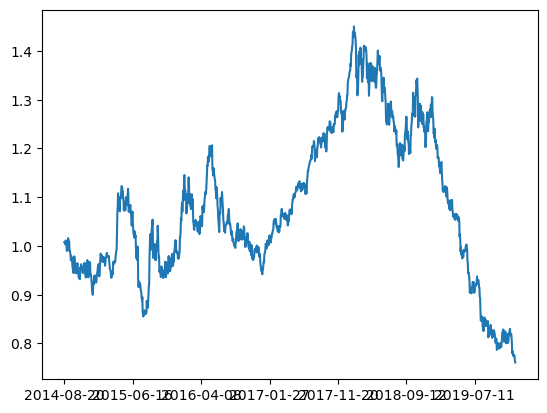

In [19]:
np.cumprod(1+trading_daily_ret_df).plot()

<Axes: >

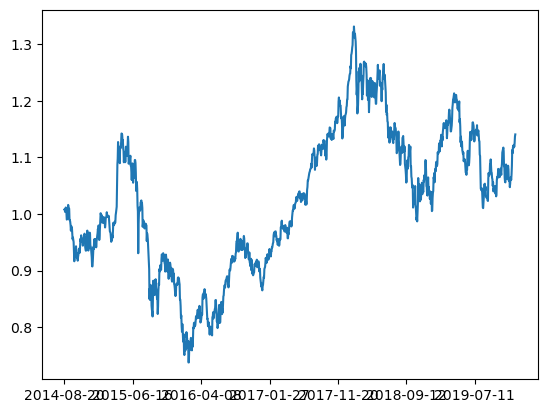

In [20]:
np.cumprod(1+benchmark_daily_ret_df).plot()

<Axes: >

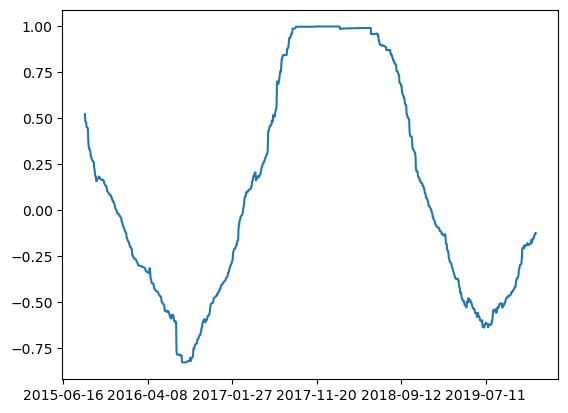

In [21]:
trading_daily_ret_df.rolling(252).corr(benchmark_daily_ret_df).plot()

## Backtest - test result

In [22]:
N = 3
W = 200
signal_type = 1
tc = 0.00001
test_start_date = "2020-01-01"
long_thres = 0.4
short_thres = 0.4

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
backtest_obj = backtest(signal_df, instrument_data_df)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc)



In [23]:
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.06267688502985228
annualized alpha:  0.1728668349801366
annualized sharpe:  0.25763818706135333
mdd:  0.45285222643386847
daily win rate:  0.510061242344707


<Axes: >

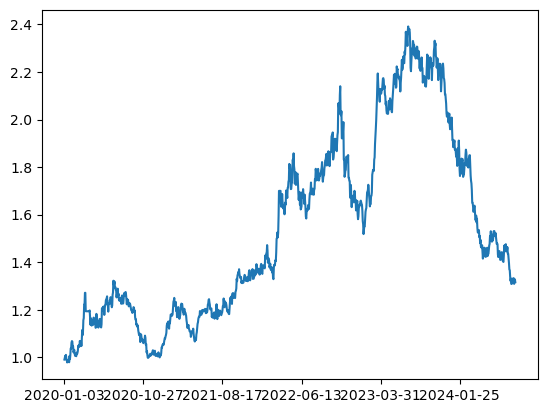

In [24]:
np.cumprod(1+trading_daily_ret_df).plot()

<Axes: >

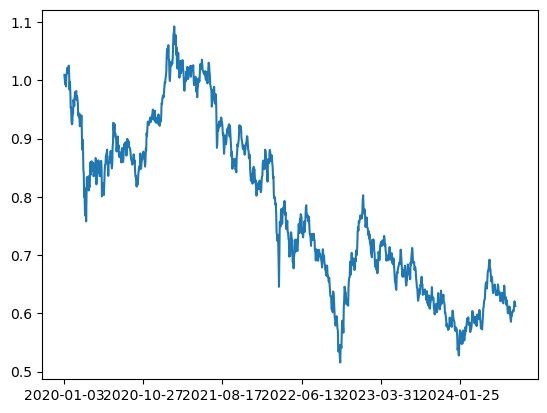

In [25]:
np.cumprod(1+benchmark_daily_ret_df).plot()

<Axes: >

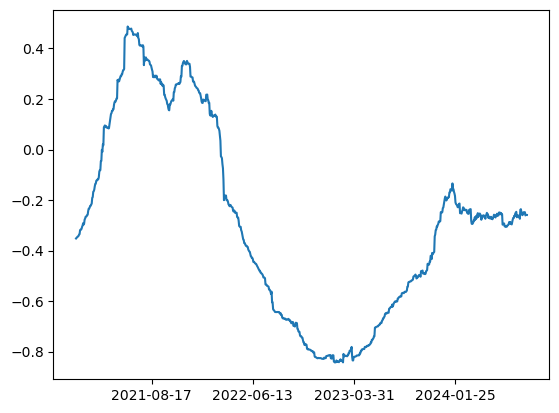

In [26]:
trading_daily_ret_df.rolling(252).corr(benchmark_daily_ret_df).plot()

In [27]:
signal_df

signal
Date              
2000-10-25      -1
2000-10-26      -1
2000-10-27      -1
2000-10-30      -1
2000-10-31      -1
...            ...
2024-08-16      -1
2024-08-19       1
2024-08-20      -1
2024-08-21       1
2024-08-22      -1

[5872 rows x 1 columns]

In [28]:
instrument_data_df

Open    Close     High      Low  Volume
2014-08-19  24905.0  25107.0  25177.0  24857.0   55504
2014-08-20  25103.0  25113.0  25189.0  25054.0   36078
2014-08-21  25115.0  24995.0  25174.0  24905.0   52375
2014-08-22  24997.0  25103.0  25158.0  24990.0   39201
2014-08-25  25098.0  25179.0  25260.0  24914.0   47478
...             ...      ...      ...      ...     ...
2024-08-16  17125.0  17424.0  17501.0  17105.0  109133
2024-08-19  17426.0  17608.0  17718.0  17354.0   94254
2024-08-20  17606.0  17533.0  17775.0  17464.0   77312
2024-08-21  17533.0  17376.0  17534.0  17251.0   94008
2024-08-22  17375.0  17662.0  17683.0  17372.0   94225

[2472 rows x 5 columns]

In [36]:
signal_gp = pd.unique(signal_df.signal)
concat_signal_instrument_df = pd.merge(instrument_data_df, signal_df, how = 'inner', left_index = True, right_index = True)
concat_signal_instrument_df['ret'] = concat_signal_instrument_df.Open.pct_change().shift(-1)
concat_signal_instrument_df.dropna(inplace = True)

In [37]:
concat_signal_instrument_df

Open    Close     High      Low  Volume  signal       ret
2014-08-19  24905.0  25107.0  25177.0  24857.0   55504       1  0.007950
2014-08-20  25103.0  25113.0  25189.0  25054.0   36078       1  0.000478
2014-08-21  25115.0  24995.0  25174.0  24905.0   52375       1 -0.004698
2014-08-22  24997.0  25103.0  25158.0  24990.0   39201       1  0.004040
2014-08-25  25098.0  25179.0  25260.0  24914.0   47478       1  0.003626
...             ...      ...      ...      ...     ...     ...       ...
2024-08-15  17129.0  17128.0  17318.0  16920.0  104683       1 -0.000234
2024-08-16  17125.0  17424.0  17501.0  17105.0  109133      -1  0.017577
2024-08-19  17426.0  17608.0  17718.0  17354.0   94254       1  0.010329
2024-08-20  17606.0  17533.0  17775.0  17464.0   77312      -1 -0.004146
2024-08-21  17533.0  17376.0  17534.0  17251.0   94008       1 -0.009012

[2463 rows x 7 columns]

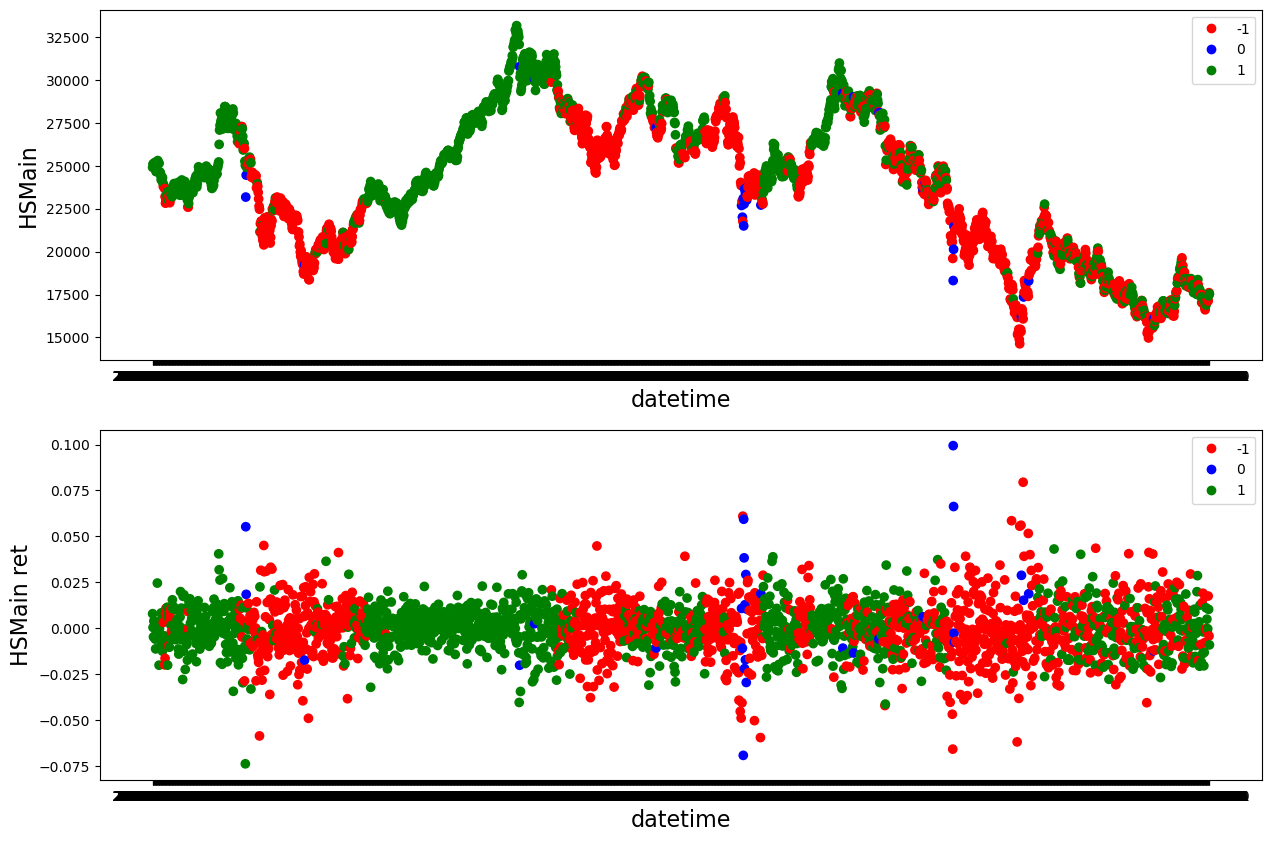

In [109]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

color_ls = ListedColormap(['r','b','g'])

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
scatter = plt.scatter(np.array(concat_signal_instrument_df.index), np.array(concat_signal_instrument_df.Open), c = np.array(concat_signal_instrument_df.signal), cmap = color_ls )
plt.legend(handles = scatter.legend_elements()[0], labels = [-1, 0 , 1])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("HSMain", fontsize=16)

plt.subplot(2,1,2)
scatter = plt.scatter(np.array(concat_signal_instrument_df.index), np.array(concat_signal_instrument_df.ret), c = np.array(concat_signal_instrument_df.signal), cmap = color_ls )
plt.legend(handles = scatter.legend_elements()[0], labels = [-1, 0 , 1])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("HSMain ret", fontsize=16)
#plt.subplot(2,1,2)
#for i in range(len(signal_gp)):
#    color = color_ls[i]
#    signal = signal_gp[i]
#    want = list(concat_signal_instrument_df.signal == signal)
#    x = list(concat_signal_instrument_df.index[want])
#    y = list(concat_signal_instrument_df.ret[want])
#    plt.scatter(x, y, c = color)
#plt.legend(signal_gp, fontsize=16)
#plt.xlabel("datetime", fontsize=16)
#plt.ylabel("HSMain ret", fontsize=16)
plt.show()

# Including Macro Economics Data (on SPX)

## Monthly Frequency

To improve the performance of HMM, we try to lower our prediction frequency from daily to monthly and include more information apart from period return like DXY, UST yield, PMI changes and Yield Curve Slope changes

In [4]:
data_df = pd.read_excel("SPX_HMM_data_input_1m.xlsx", index_col = 0)

In [5]:
data_df

SPX_Close  SPX_Next_Open   DXY_Close  UST_10y_yield_Close  \
Date                                                                      
2000-01-01          NaN            NaN         NaN                  NaN   
2000-02-01  1409.280029    1409.280029  104.919998                6.617   
2000-03-01  1379.189941    1379.189941  104.889999                6.379   
2000-04-01  1498.579956    1498.579956  105.440002                6.023   
2000-05-01  1468.250000    1468.250000  109.629997                6.255   
...                 ...            ...         ...                  ...   
2024-04-01  5243.770020    5204.290039  105.019997                4.329   
2024-05-01  5018.390137    5049.319824  105.760002                4.595   
2024-06-03  5283.399902    5278.240234  104.139999                4.402   
2024-07-01  5475.089844    5461.839844  105.900002                4.479   
2024-08-01  5446.680176    5376.629883  104.419998                3.976   

            UST_13w_yield_Close   PMI  
Date                                   
2000-01-01                  NaN  57.8  
2000-02-01                5.550  56.7  
2000-03-01                5.600  55.8  
2000-04-01                5.720  54.9  
2000-05-01                5.670  54.7  
...                         ...   ...  
2024-04-01                5.218  50.3  
2024-05-01                5.250  49.2  
2024-06-03                5.243  48.7  
2024-07-01                5.218  48.5  
2024-08-01                5.115  46.8  

[296 rows x 6 columns]

In [6]:
input_df = pd.DataFrame(index = data_df.index)
input_df['stock_return'] = np.log(data_df['SPX_Close']).diff()
input_df['DXY_change'] = data_df['DXY_Close'].pct_change()
input_df['UST_10y_yield'] = data_df['UST_10y_yield_Close']
input_df['yield_slope_change'] = (data_df['UST_10y_yield_Close'] - data_df['UST_13w_yield_Close']).diff()
input_df['PMI_change'] = data_df['PMI'].diff()
input_df.dropna(inplace = True)

In [22]:
input_df

stock_return  DXY_change  UST_10y_yield  yield_slope_change  \
Date                                                                      
2000-03-01     -0.021583   -0.000286          6.379              -0.288   
2000-04-01      0.083022    0.005244          6.023              -0.476   
2000-05-01     -0.020447    0.039738          6.255               0.282   
2000-06-01     -0.013329   -0.005290          6.195               0.050   
2000-07-01      0.003988   -0.020266          6.018              -0.317   
...                  ...         ...            ...                 ...   
2024-04-01      0.020556    0.011169          4.329               0.146   
2024-05-01     -0.043932    0.007046          4.595               0.234   
2024-06-03      0.051461   -0.015318          4.402              -0.186   
2024-07-01      0.035639    0.016900          4.479               0.102   
2024-08-01     -0.005202   -0.013975          3.976              -0.400   

            PMI_change  
Date                    
2000-03-01        -0.9  
2000-04-01        -0.9  
2000-05-01        -0.2  
2000-06-01        -1.5  
2000-07-01        -1.8  
...                ...  
2024-04-01         2.5  
2024-05-01        -1.1  
2024-06-03        -0.5  
2024-07-01        -0.2  
2024-08-01        -1.7  

[294 rows x 5 columns]

In [26]:
input_df.iloc[104-20:104]

stock_return  DXY_change  UST_10y_yield  yield_slope_change  \
Date                                                                      
2007-03-01     -0.030026   -0.011225          4.556           -0.281000   
2007-04-01      0.012528   -0.008963          4.648            0.186999   
2007-05-01      0.045028   -0.016038          4.642            0.134000   
2007-06-01      0.033113    0.008824          4.956            0.414000   
2007-07-01     -0.021707   -0.004859          5.033            0.062000   
2007-08-01     -0.025288   -0.012817          4.759           -0.344000   
2007-09-01      0.005565   -0.000989          4.537            0.528000   
2007-10-01      0.048370   -0.035772          4.557            0.215000   
2007-11-01     -0.025267   -0.016816          4.361           -0.106000   
2007-12-01     -0.018264   -0.005745          3.972            0.246000   
2008-01-01     -0.008666    0.007223          4.035           -0.007000   
2008-02-01     -0.050951   -0.016297          3.600            0.655000   
2008-03-03     -0.047010   -0.023194          3.534            0.349000   
2008-04-01      0.028756   -0.015468          3.545            0.291000   
2008-05-01      0.028179    0.009923          3.749            0.189000   
2008-06-02     -0.016938   -0.004776          3.971           -0.198000   
2008-07-01     -0.075495   -0.007679          3.992           -0.014000   
2008-08-01     -0.019331    0.014509          3.948            0.151000   
2008-09-02      0.013610    0.063198          3.746           -0.222000   
2008-10-01     -0.095634    0.017935          3.768            0.872000   

            PMI_change  
Date                    
2007-03-01         2.4  
2007-04-01        -1.2  
2007-05-01         1.9  
2007-06-01        -0.1  
2007-07-01         0.1  
2007-08-01        -0.2  
2007-09-01        -1.5  
2007-10-01         0.1  
2007-11-01         0.1  
2007-12-01        -0.6  
2008-01-01        -1.5  
2008-02-01         1.7  
2008-03-03        -2.4  
2008-04-01         0.3  
2008-05-01         0.0  
2008-06-02         1.0  
2008-07-01         0.6  
2008-08-01        -0.2  
2008-09-02        -0.1  
2008-10-01        -6.4

In [7]:
instrument_data_df = pd.DataFrame(data_df["SPX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [8]:
instrument_data_df

Open
2000-01-01          NaN
2000-02-01  1409.280029
2000-03-01  1379.189941
2000-04-01  1498.579956
2000-05-01  1468.250000
...                 ...
2024-04-01  5204.290039
2024-05-01  5049.319824
2024-06-03  5278.240234
2024-07-01  5461.839844
2024-08-01  5376.629883

[296 rows x 1 columns]

In [17]:
N = 3
three_state_ghmm_model = hmm.GaussianHMM(n_components = N, covariance_type = "full", n_iter = 10000, random_state = 99)
three_state_ghmm_trading_model = HMM_Trading_Model(N, three_state_ghmm_model)
W = 120

#model recursive_training
signal_info_df = model_recursive_training(input_df, N, three_state_ghmm_trading_model, W)

NameError: name 'input_df' is not defined

In [29]:
signal_info_df.to_csv("GHMM_hs_3_SPX_DXY_UST_PMI_w_120_m_freq_n_10000.csv")

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope / PMI

Freq : M

Hidden State : 3

Window : 60 

In [42]:
signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_PMI_w_60_m_freq.csv",index_col = 0)
data_df = pd.read_excel("SPX_HMM_data_input_1m.xlsx", index_col = 0)

In [43]:
signal_info_df

latest_hidden_post_prob  occurence_latest_hidden_state  \
Date                                                                 
2005-03-01                 0.549524                             43   
2005-04-01                 0.999608                             33   
2005-05-01                 0.989375                             33   
2005-06-01                 0.999341                             29   
2005-07-01                 0.781873                             45   
...                             ...                            ...   
2024-04-01                 1.000000                             23   
2024-05-01                 1.000000                             24   
2024-06-03                 1.000000                             25   
2024-07-01                 1.000000                             24   
2024-08-01                 1.000000                             27   

            total_hist_next_day_observation_given_state  win_rate  \
Date                                                                
2005-03-01                                    -0.244449  0.476190   
2005-04-01                                     0.422323  0.718750   
2005-05-01                                     0.190393  0.656250   
2005-06-01                                    -0.181110  0.500000   
2005-07-01                                    -0.330905  0.522727   
...                                                 ...       ...   
2024-04-01                                     0.212081  0.590909   
2024-05-01                                     0.232637  0.608696   
2024-06-03                                     0.188705  0.583333   
2024-07-01                                     0.255016  0.565217   
2024-08-01                                     0.275805  0.615385   

            cond_next_daily_ret_mean  
Date                                  
2005-03-01                 -0.002045  
2005-04-01                  0.005822  
2005-05-01                  0.009166  
2005-06-01                 -0.004875  
2005-07-01                 -0.001936  
...                              ...  
2024-04-01                  0.005316  
2024-05-01                  0.005957  
2024-06-03                  0.003956  
2024-07-01                  0.004088  
2024-08-01                  0.006899  

[234 rows x 5 columns]

In [36]:
instrument_data_df = pd.DataFrame(data_df["SPX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [37]:
N = 3
W = 60
signal_type = 1
tc = 0.00001
train_start_date = '2007-01-01'
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date,train_end_date, 'm', 1)


annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.004543 -0.004543 -0.004543 -0.004543 -0.004543  0.012015 -0.017979   
0.1 -0.004543 -0.004543 -0.004543 -0.004543 -0.004543  0.012015 -0.017979   
0.2 -0.004543 -0.004543 -0.004543 -0.004543 -0.004543  0.012015 -0.017979   
0.3 -0.004543 -0.004543 -0.004543 -0.004543 -0.004543  0.012015 -0.017979   
0.4  0.005142  0.005142  0.005142  0.005142  0.005142  0.021700 -0.008294   
0.5  0.016305  0.016305  0.016305  0.016305  0.016305  0.032862  0.002868   
0.6  0.025464  0.025464  0.025464  0.025464  0.025464  0.042022  0.012028   
0.7  0.022684  0.022684  0.022684  0.022684  0.022684  0.039242  0.009248   
0.8  0.034824  0.034824  0.034824  0.034824  0.034824  0.051382  0.021388   
0.9  0.034824  0.034824  0.034824  0.034824  0.034824  0.051382  0.021388   

          0.7       0.8       0.9  
0.0 -0.020980 -0.031766 -0.039367  
0.1 -0.020980 -0.031766 -0.039367  
0.2 -0.020980 -0.031766 -0.03

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope / PMI

Freq : M

Hidden State : 3

Window : 120

In [38]:
data_df = pd.read_excel("SPX_HMM_data_input_1m.xlsx", index_col = 0)

In [39]:
signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_PMI_w_120_m_freq.csv",index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [41]:
signal_info_df

latest_hidden_post_prob  occurence_latest_hidden_state  \
Date                                                                 
2010-03-01                 1.000000                             15   
2010-04-01                 0.985308                             95   
2010-05-03                 0.976510                             86   
2010-06-01                 0.744797                             87   
2010-07-01                 0.985522                              8   
...                             ...                            ...   
2024-04-01                 0.584840                             47   
2024-05-01                 0.905201                             59   
2024-06-03                 0.994949                             17   
2024-07-01                 1.000000                             27   
2024-08-01                 0.984338                             60   

            total_hist_next_day_observation_given_state  win_rate  \
Date                                                                
2010-03-01                                     0.288518  0.642857   
2010-04-01                                     0.225675  0.563830   
2010-05-03                                    -0.246052  0.470588   
2010-06-01                                     0.369172  0.593023   
2010-07-01                                    -0.279989  0.571429   
...                                                 ...       ...   
2024-04-01                                     1.025201  0.804348   
2024-05-01                                     0.628231  0.724138   
2024-06-03                                     0.507143  0.812500   
2024-07-01                                     0.376273  0.615385   
2024-08-01                                     1.179863  0.779661   

            cond_next_daily_ret_mean  
Date                                  
2010-03-01                  0.007981  
2010-04-01                  0.005972  
2010-05-03                 -0.003705  
2010-06-01                  0.008739  
2010-07-01                 -0.060231  
...                              ...  
2024-04-01                  0.018414  
2024-05-01                  0.011818  
2024-06-03                  0.000081  
2024-07-01                 -0.002792  
2024-08-01                  0.021097  

[174 rows x 5 columns]

In [40]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_dat = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df, instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'm', 1)


annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.084404  0.084404  0.084404  0.084404  0.084404  0.080043  0.070187   
0.1  0.084404  0.084404  0.084404  0.084404  0.084404  0.080043  0.070187   
0.2  0.084404  0.084404  0.084404  0.084404  0.084404  0.080043  0.070187   
0.3  0.084404  0.084404  0.084404  0.084404  0.084404  0.080043  0.070187   
0.4  0.092922  0.092922  0.092922  0.092922  0.092922  0.088561  0.078705   
0.5  0.084230  0.084230  0.084230  0.084230  0.084230  0.079869  0.070013   
0.6  0.093167  0.093167  0.093167  0.093167  0.093167  0.088806  0.078950   
0.7  0.093167  0.093167  0.093167  0.093167  0.093167  0.088806  0.078950   
0.8  0.093167  0.093167  0.093167  0.093167  0.093167  0.088806  0.078950   
0.9  0.093167  0.093167  0.093167  0.093167  0.093167  0.088806  0.078950   

          0.7       0.8       0.9  
0.0 -0.031025 -0.008763 -0.008763  
0.1 -0.031025 -0.008763 -0.008763  
0.2 -0.031025 -0.008763 -0.00

## Weekly Frequency

In [15]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)

In [16]:
input_df = pd.DataFrame(index = data_df.index)
input_df['stock_return'] = np.log(data_df['SPX_Close']).diff()
input_df['DXY_change'] = data_df['DXY_Close'].pct_change()
input_df['UST_10y_yield'] = data_df['UST_10y_yield_Close']
input_df['yield_slope_change'] = (data_df['UST_10y_yield_Close'] - data_df['UST_13w_yield_Close']).diff()
#input_df['PMI_change'] = data_df['PMI'].diff()
input_df.dropna(inplace = True)

In [17]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [18]:
instrument_data_df

Open
2000-01-03      NaN
2000-01-10      NaN
2000-01-17      NaN
2000-01-24      NaN
2000-01-31      NaN
...             ...
2024-07-15  5688.75
2024-07-22  5607.75
2024-07-29  5504.50
2024-08-05  5250.00
2024-08-12  5372.50

[1285 rows x 1 columns]

In [19]:
N = 3
three_state_ghmm_model = hmm.GaussianHMM(n_components = N, covariance_type = "full", n_iter = 1000, random_state = 99)
three_state_ghmm_trading_model = HMM_Trading_Model(N, three_state_ghmm_model)
W = 120

#model recursive_training
signal_info_df = model_recursive_training(input_df, N, three_state_ghmm_trading_model, W)

120


Model is not converging.  Current: 703.939193677199 is not greater than 714.1758148411351. Delta is -10.236621163936093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 677.9895602214201 is not greater than 689.220511251029. Delta is -11.230951029608946
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 680.8113113631772 is not greater than 688.7224767712307. Delta is -7.9111654080535345
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


KeyboardInterrupt: 

In [138]:
signal_info_df.to_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2.csv")

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 3

Window : 120 

In [20]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq.csv",index_col = 0)

In [21]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [22]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df, instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.075785  0.075785  0.075785  0.075785  0.075785  0.050952  0.011471   
0.1  0.075785  0.075785  0.075785  0.075785  0.075785  0.050952  0.011471   
0.2  0.075785  0.075785  0.075785  0.075785  0.075785  0.050952  0.011471   
0.3  0.075785  0.075785  0.075785  0.075785  0.075785  0.050952  0.011471   
0.4  0.071871  0.071871  0.071871  0.071871  0.071871  0.047038  0.007557   
0.5  0.065667  0.065667  0.065667  0.065667  0.065667  0.040834  0.001353   
0.6  0.055095  0.055095  0.055095  0.055095  0.055095  0.030263 -0.009219   
0.7  0.064448  0.064448  0.064448  0.064448  0.064448  0.039616  0.000134   
0.8  0.073837  0.073837  0.073837  0.073837  0.073837  0.049005  0.009524   
0.9  0.073837  0.073837  0.073837  0.073837  0.073837  0.049005  0.009524   

          0.7       0.8       0.9  
0.0  0.000415  0.002722  0.001947  
0.1  0.000415  0.002722  0.001947  
0.2  0.000415  0.002722  0.00

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 3

Window : 156

In [23]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_156_w_freq.csv",index_col = 0)

In [24]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [25]:
N = 3
W = 156
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df, instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.007682  0.007682  0.007682  0.007682  0.007110 -0.012234 -0.046054   
0.1  0.007682  0.007682  0.007682  0.007682  0.007110 -0.012234 -0.046054   
0.2  0.007682  0.007682  0.007682  0.007682  0.007110 -0.012234 -0.046054   
0.3  0.007682  0.007682  0.007682  0.007682  0.007110 -0.012234 -0.046054   
0.4  0.011825  0.011825  0.011825  0.011825  0.011253 -0.008091 -0.041911   
0.5  0.046732  0.046732  0.046732  0.046732  0.046161  0.026817 -0.007004   
0.6  0.042181  0.042181  0.042181  0.042181  0.041609  0.022265 -0.011556   
0.7  0.047805  0.047805  0.047805  0.047805  0.047234  0.027890 -0.005931   
0.8  0.050156  0.050156  0.050156  0.050156  0.049585  0.030241 -0.003580   
0.9  0.050156  0.050156  0.050156  0.050156  0.049585  0.030241 -0.003580   

          0.7       0.8       0.9  
0.0 -0.046142 -0.042474 -0.042474  
0.1 -0.046142 -0.042474 -0.042474  
0.2 -0.046142 -0.042474 -0.04

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 78

In [26]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_78_w_freq.csv",index_col = 0)

In [27]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [28]:
N = 2
W = 78
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.051218  0.051218  0.051218  0.051218  0.051218  0.035211 -0.006796   
0.1  0.051218  0.051218  0.051218  0.051218  0.051218  0.035211 -0.006796   
0.2  0.051218  0.051218  0.051218  0.051218  0.051218  0.035211 -0.006796   
0.3  0.051218  0.051218  0.051218  0.051218  0.051218  0.035211 -0.006796   
0.4  0.065988  0.065988  0.065988  0.065988  0.065988  0.049982  0.007974   
0.5  0.065868  0.065868  0.065868  0.065868  0.065868  0.049862  0.007855   
0.6  0.064976  0.064976  0.064976  0.064976  0.064976  0.048970  0.006963   
0.7  0.066609  0.066609  0.066609  0.066609  0.066609  0.050603  0.008596   
0.8  0.066609  0.066609  0.066609  0.066609  0.066609  0.050603  0.008596   
0.9  0.066609  0.066609  0.066609  0.066609  0.066609  0.050603  0.008596   

          0.7       0.8       0.9  
0.0 -0.028942 -0.015392 -0.015392  
0.1 -0.028942 -0.015392 -0.015392  
0.2 -0.028942 -0.015392 -0.01

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 104

In [29]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_104_w_freq.csv",index_col = 0)

In [30]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [31]:
N = 2
W = 104
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.048613  0.048613  0.048613  0.048613  0.048613  0.032606 -0.008714   
0.1  0.048613  0.048613  0.048613  0.048613  0.048613  0.032606 -0.008714   
0.2  0.048613  0.048613  0.048613  0.048613  0.048613  0.032606 -0.008714   
0.3  0.048613  0.048613  0.048613  0.048613  0.048613  0.032606 -0.008714   
0.4  0.063383  0.063383  0.063383  0.063383  0.063383  0.047377  0.006056   
0.5  0.063265  0.063265  0.063265  0.063265  0.063265  0.047258  0.005938   
0.6  0.062712  0.062712  0.062712  0.062712  0.062712  0.046706  0.005385   
0.7  0.064345  0.064345  0.064345  0.064345  0.064345  0.048339  0.007018   
0.8  0.064345  0.064345  0.064345  0.064345  0.064345  0.048339  0.007018   
0.9  0.064345  0.064345  0.064345  0.064345  0.064345  0.048339  0.007018   

          0.7       0.8       0.9  
0.0 -0.029283 -0.015733 -0.015733  
0.1 -0.029283 -0.015733 -0.015733  
0.2 -0.029283 -0.015733 -0.01

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 78

In [32]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_78_w_freq_v2.csv",index_col = 0)

In [33]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [34]:
N = 2
W = 78
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.017448  0.017448  0.017448  0.017448  0.011293  0.001862 -0.013192   
0.1  0.017448  0.017448  0.017448  0.017448  0.011293  0.001862 -0.013192   
0.2  0.017448  0.017448  0.017448  0.017448  0.011293  0.001862 -0.013192   
0.3  0.017448  0.017448  0.017448  0.017448  0.011293  0.001862 -0.013192   
0.4  0.035850  0.035850  0.035850  0.035850  0.029695  0.020263  0.005210   
0.5  0.051049  0.051049  0.051049  0.051049  0.044895  0.035463  0.020410   
0.6  0.039552  0.039552  0.039552  0.039552  0.033398  0.023966  0.008912   
0.7  0.053806  0.053806  0.053806  0.053806  0.047652  0.038220  0.023167   
0.8  0.059848  0.059848  0.059848  0.059848  0.053693  0.044261  0.029208   
0.9  0.059848  0.059848  0.059848  0.059848  0.053693  0.044261  0.029208   

          0.7       0.8       0.9  
0.0 -0.054081 -0.042400 -0.042400  
0.1 -0.054081 -0.042400 -0.042400  
0.2 -0.054081 -0.042400 -0.04

### Model 6 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 3

Window : 120

Prediction Method : Map

In [6]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2_map.csv",index_col = 0)

In [7]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [8]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.076042  0.076042  0.076042  0.076042  0.076042  0.051209  0.005287   
0.1  0.076042  0.076042  0.076042  0.076042  0.076042  0.051209  0.005287   
0.2  0.076042  0.076042  0.076042  0.076042  0.076042  0.051209  0.005287   
0.3  0.076042  0.076042  0.076042  0.076042  0.076042  0.051209  0.005287   
0.4  0.072128  0.072128  0.072128  0.072128  0.072128  0.047295  0.001373   
0.5  0.064042  0.064042  0.064042  0.064042  0.064042  0.039209 -0.006712   
0.6  0.058049  0.058049  0.058049  0.058049  0.058049  0.033217 -0.012705   
0.7  0.064582  0.064582  0.064582  0.064582  0.064582  0.039749 -0.006172   
0.8  0.073971  0.073971  0.073971  0.073971  0.073971  0.049138  0.003217   
0.9  0.073971  0.073971  0.073971  0.073971  0.073971  0.049138  0.003217   

          0.7       0.8       0.9  
0.0  0.000721  0.002845  0.002071  
0.1  0.000721  0.002845  0.002071  
0.2  0.000721  0.002845  0.00

## Daily Frequency

In [35]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)

In [36]:
input_df = pd.DataFrame(index = data_df.index)
input_df['stock_return'] = np.log(data_df['SPX_Close']).diff()
input_df['DXY_change'] = data_df['DXY_Close'].pct_change()
input_df['UST_10y_yield'] = data_df['UST_10y_yield_Close']
input_df['yield_slope_change'] = (data_df['UST_10y_yield_Close'] - data_df['UST_13w_yield_Close']).diff()
#input_df['PMI_change'] = data_df['PMI'].diff()
input_df.dropna(inplace = True)

In [37]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [29]:
N = 2
three_state_ghmm_model = hmm.GaussianHMM(n_components = N, covariance_type = "full", n_iter = 1000, random_state = 99)
three_state_ghmm_trading_model = HMM_Trading_Model(N, three_state_ghmm_model)
W = 252

#model recursive_training
signal_info_df = model_recursive_training(input_df, N, three_state_ghmm_trading_model, W)

252


Model is not converging.  Current: 1889.903974841737 is not greater than 1889.9134429107025. Delta is -0.009468068965588827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1877.2507592100628 is not greater than 1877.2659444568344. Delta is -0.015185246771579841
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1859.4354832946578 is not greater than 1859.436656114491. Delta is -0.0011728198330729356
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1855.0757781763643 is not greater than 1855.0955913927944. Delta is -0.01981321643006595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1850.7716573196162 is not greater than 1850.7958133230957. Delta is -0.024156003479447463
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1848.607904952282 is not greater than 1848.6278255193822. Delta is -0.01992056710014367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1845.9516023175424 is not greater than 1845.9566186755774. Delta is -0.005016358034936275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1843.418649589432 is not greater than 1843.4476941311702. Delta is -0.029044541738130647
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1841.4537222177696 is not greater than 1841.4577691848965. Delta is -0.004046967126896561
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1896.404181828321 is not greater than 1896.4624156312561. Delta is -0.05823380293509217
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1897.3863245895873 is not greater than 1897.4422533753618. Delta is -0.0559287857745403
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1908.8878206118156 is not greater than 1908.8896754703608. Delta is -0.0018548585451299004
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1911.1698183691633 is not greater than 1911.224598705738. Delta is -0.05478033657459491
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1911.6931738549279 is not greater than 1911.6976338762418. Delta is -0.004460021313889229
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1918.8401771739668 is not greater than 1918.8929317126158. Delta is -0.052754538648969174
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1922.657465123055 is not greater than 1922.6654301957556. Delta is -0.007965072700471865
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1924.1044316079312 is not greater than 1924.1192895072068. Delta is -0.014857899275511954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1926.3049447598876 is not greater than 1926.3238500156338. Delta is -0.018905255746176408
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1927.336747619793 is not greater than 1927.3617899942699. Delta is -0.025042374476925033
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1930.4296155174286 is not greater than 1930.456773648722. Delta is -0.027158131293390397
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1932.2482250386477 is not greater than 1932.2808110071387. Delta is -0.032585968491048334
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1933.5155049087257 is not greater than 1933.5526433809705. Delta is -0.0371384722448056
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1937.3271832746914 is not greater than 1937.3602266956104. Delta is -0.0330434209190571
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1941.619886798837 is not greater than 1941.6612585963494. Delta is -0.041371797512510966
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1942.8761875700613 is not greater than 1942.919293657014. Delta is -0.04310608695254814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1944.0360472206835 is not greater than 1944.0856291820974. Delta is -0.04958196141387816
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1945.7014987365196 is not greater than 1945.7473603736476. Delta is -0.04586163712792768
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1945.670898937282 is not greater than 1945.713201855295. Delta is -0.042302918013092494
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1944.8528533990323 is not greater than 1944.8961031598183. Delta is -0.04324976078601139
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1944.3153645092386 is not greater than 1944.3578471599328. Delta is -0.042482650694182666
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1944.348155402041 is not greater than 1944.3895850978654. Delta is -0.04142969582449041
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1945.5186513062608 is not greater than 1945.5603758066466. Delta is -0.04172450038572606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1945.717333876163 is not greater than 1945.7584330812851. Delta is -0.041099205122236526
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1946.8158891146982 is not greater than 1946.8557385402742. Delta is -0.039849425575994246
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1946.2336426171241 is not greater than 1946.273075535699. Delta is -0.03943291857490294
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1946.5544703788098 is not greater than 1946.5955379468135. Delta is -0.04106756800365474
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1940.7461286384228 is not greater than 1940.7827251120973. Delta is -0.036596473674535446
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1940.2427402804087 is not greater than 1940.2799015761302. Delta is -0.037161295721489296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1938.4959396737001 is not greater than 1938.4989662743235. Delta is -0.0030266006233432563
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1937.028478373609 is not greater than 1937.0641999126885. Delta is -0.035721539079531794
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1939.5650738970396 is not greater than 1939.5975035625588. Delta is -0.0324296655192029
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1936.3293596900887 is not greater than 1936.3630160943223. Delta is -0.033656404233624926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1933.7900481306342 is not greater than 1933.8208889552761. Delta is -0.03084082464192761
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1930.8527627763622 is not greater than 1930.8902134484777. Delta is -0.03745067211548303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1927.3773705855986 is not greater than 1927.4192625095407. Delta is -0.04189192394210295
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1925.1357828490056 is not greater than 1925.1762025064886. Delta is -0.04041965748297116
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1924.8829112393917 is not greater than 1924.9020343746529. Delta is -0.01912313526122489
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1923.6480011319957 is not greater than 1923.68576719791. Delta is -0.03776606591441123
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1922.3503047723118 is not greater than 1922.3631164685446. Delta is -0.012811696232802205
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1922.197340939931 is not greater than 1922.209912683321. Delta is -0.01257174338979894
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1921.9455124686474 is not greater than 1921.981180189246. Delta is -0.035667720598667074
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1921.2699415081543 is not greater than 1921.3048619486644. Delta is -0.034920440510177286
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1918.0593287334993 is not greater than 1918.0945396560026. Delta is -0.035210922503210895
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1918.9015613967724 is not greater than 1918.935732962242. Delta is -0.03417156546947808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1914.1237024125544 is not greater than 1914.1583274818577. Delta is -0.03462506930327436
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1912.611178648731 is not greater than 1912.6452869575812. Delta is -0.03410830885013638
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1912.3263924976 is not greater than 1912.3609287448137. Delta is -0.034536247213736715
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1910.4591505552444 is not greater than 1910.4935580441806. Delta is -0.03440748893626733
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1910.93709641081 is not greater than 1910.9713675692717. Delta is -0.034271158461706364
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1911.5426888424681 is not greater than 1911.5763528058176. Delta is -0.03366396334945421
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1910.7147590421366 is not greater than 1910.7470569238294. Delta is -0.03229788169278436
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.0256047912562 is not greater than 1919.0580632007616. Delta is -0.03245840950535239
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.4388056051534 is not greater than 1919.4675279872722. Delta is -0.028722382118758105
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.170034114414 is not greater than 1919.1967847622752. Delta is -0.026750647861263133
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1918.301129700183 is not greater than 1918.301619092692. Delta is -0.0004893925088254036
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1916.8181099819449 is not greater than 1916.8198305884398. Delta is -0.0017206064949277788
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1915.3631337255526 is not greater than 1915.3655542025708. Delta is -0.0024204770181768254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.174538691286 is not greater than 1919.1922497501323. Delta is -0.01771105884631652
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1918.7410233356738 is not greater than 1918.7564285340156. Delta is -0.015405198341795767
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.731181305334 is not greater than 1919.744453019865. Delta is -0.01327171453090159
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1923.5241086709077 is not greater than 1923.5348178417858. Delta is -0.01070917087804446
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1924.917446084091 is not greater than 1924.927013799179. Delta is -0.009567715087996476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1927.7571391637996 is not greater than 1927.766471409844. Delta is -0.009332246044323256
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1930.3793285220152 is not greater than 1930.386879946019. Delta is -0.007551424003850116
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1934.3249345333043 is not greater than 1934.33046637871. Delta is -0.005531845405812419
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1937.4348161746052 is not greater than 1937.4366813835193. Delta is -0.0018652089140687167
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1935.759586395054 is not greater than 1935.7618882720953. Delta is -0.0023018770414182654
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1939.664007108886 is not greater than 1939.665125147037. Delta is -0.0011180381511621817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1940.2794059128767 is not greater than 1940.2840936498005. Delta is -0.004687736923870034
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1942.1307926284276 is not greater than 1942.1431554485775. Delta is -0.01236282014997414
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1946.837285632338 is not greater than 1946.8560645191142. Delta is -0.018778886776090076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1961.0235164736985 is not greater than 1961.039026340387. Delta is -0.015509866688489637
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1964.864345581246 is not greater than 1964.8711852631839. Delta is -0.006839681937890418
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1966.4573672122751 is not greater than 1966.4578633398867. Delta is -0.0004961276115409419
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1969.784384493438 is not greater than 1969.7862718617862. Delta is -0.0018873683482070192
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1972.9975029971015 is not greater than 1973.0072661265488. Delta is -0.009763129447264873
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1974.1844447678186 is not greater than 1974.1930853871002. Delta is -0.008640619281550244
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1983.5587662140026 is not greater than 1983.5623648684793. Delta is -0.003598654476718366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1996.7924486679553 is not greater than 1996.7935572922229. Delta is -0.0011086242675446556
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1999.403406836265 is not greater than 1999.4038533814585. Delta is -0.00044654519342657295
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2003.0632193716017 is not greater than 2003.0656974527387. Delta is -0.002478081137041954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2002.1134085560357 is not greater than 2002.1190473522252. Delta is -0.005638796189487039
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2003.0758756899008 is not greater than 2003.0825794352377. Delta is -0.006703745336835709
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2002.5515953556537 is not greater than 2002.5596095963058. Delta is -0.008014240652073568
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2011.2455449263261 is not greater than 2011.2523834274075. Delta is -0.006838501081347204
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2009.4810181752825 is not greater than 2009.4811277407323. Delta is -0.00010956544974760618
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2007.6523293827609 is not greater than 2007.6604324125556. Delta is -0.008103029794710892
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2007.6775335883622 is not greater than 2007.6855147989872. Delta is -0.007981210625075619
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2008.6537667067419 is not greater than 2008.6594607952181. Delta is -0.005694088476275283
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.3267263605896 is not greater than 2013.332506041317. Delta is -0.005779680727300729
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2016.596836988175 is not greater than 2016.6017340724159. Delta is -0.004897084240838012
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2018.4472372759885 is not greater than 2018.450148468858. Delta is -0.002911192869532897
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2021.9333011475403 is not greater than 2021.9359554714624. Delta is -0.002654323922115509
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.0491250691798 is not greater than 2030.0530727562298. Delta is -0.003947687049958404
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.4067051517934 is not greater than 2030.4127197807848. Delta is -0.006014628991351856
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.1527470657925 is not greater than 2031.1594278670013. Delta is -0.006680801208858611
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.3030350323643 is not greater than 2032.3102011326275. Delta is -0.007166100263248154
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2034.2542874773728 is not greater than 2034.264257887809. Delta is -0.009970410436153543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2036.310033946709 is not greater than 2036.3185860593603. Delta is -0.008552112651386778
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.774174154088 is not greater than 2040.7826462926225. Delta is -0.00847213853444373
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2043.105278051008 is not greater than 2043.1138690982507. Delta is -0.008591047242589411
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2046.5370725712223 is not greater than 2046.5439950430966. Delta is -0.006922471874304392
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2047.8231564473267 is not greater than 2047.8280345794662. Delta is -0.004878132139538138
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2049.0317677509915 is not greater than 2049.034229410321. Delta is -0.002461659329583199
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2052.838693536785 is not greater than 2052.842621053817. Delta is -0.003927517032025207
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2051.8135835515436 is not greater than 2051.8182161630953. Delta is -0.004632611551642185
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2058.744835231469 is not greater than 2058.749186078951. Delta is -0.004350847481873643
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2056.4131605797506 is not greater than 2056.4179940055087. Delta is -0.004833425758079102
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2054.833042247287 is not greater than 2054.8383883731362. Delta is -0.005346125849428063
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2052.6401001289246 is not greater than 2052.646248139069. Delta is -0.006148010144443106
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2050.642219617763 is not greater than 2050.6490392010137. Delta is -0.0068195832504898135
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2047.6439212063585 is not greater than 2047.6510941418942. Delta is -0.0071729355356637825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2045.7885991743415 is not greater than 2045.7957981872887. Delta is -0.00719901294723968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.4492684370666 is not greater than 2040.4551794319411. Delta is -0.0059109948745117435
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2038.7153608811202 is not greater than 2038.7223418171639. Delta is -0.0069809360436465795
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2035.433987040369 is not greater than 2035.4418506107306. Delta is -0.007863570361678285
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.4119478402497 is not greater than 2033.420745718786. Delta is -0.008797878536370263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.397947538713 is not greater than 2030.4070555975154. Delta is -0.0091080588024397
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2027.667598736998 is not greater than 2027.6750102324906. Delta is -0.007411495492760878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2023.9220211413965 is not greater than 2023.9236164785248. Delta is -0.0015953371282648732
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2022.4710706378341 is not greater than 2022.4803450671855. Delta is -0.009274429351307845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.5070824995814 is not greater than 2017.5168293391732. Delta is -0.009746839591798562
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.1739424541563 is not greater than 2017.1859050238918. Delta is -0.011962569735487705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2018.0040983334557 is not greater than 2018.0184729791838. Delta is -0.014374645728139512
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2015.5597448442059 is not greater than 2015.5747388961272. Delta is -0.014994051921348728
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.1224792573776 is not greater than 2013.1407710842068. Delta is -0.01829182682922692
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1994.6010488355194 is not greater than 1994.6193168372702. Delta is -0.01826800175081189
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1988.769575349219 is not greater than 1988.7928476861352. Delta is -0.023272336916306813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1985.1899105867674 is not greater than 1985.2200518042946. Delta is -0.030141217527216213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1972.497216015738 is not greater than 1972.5296667638866. Delta is -0.03245074814844884
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1964.445617590009 is not greater than 1964.4697197368405. Delta is -0.02410214683141021
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1961.8159680278745 is not greater than 1961.850027624474. Delta is -0.03405959659949076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1959.3504499215028 is not greater than 1959.367734211094. Delta is -0.017284289591316337
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1954.444628626774 is not greater than 1954.4807517769157. Delta is -0.03612315014174783
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1951.0529657931615 is not greater than 1951.0625490469856. Delta is -0.009583253824075655
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1929.2447737098007 is not greater than 1929.256234777726. Delta is -0.011461067925210955
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1925.522551736228 is not greater than 1925.5265042473932. Delta is -0.003952511165152828
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1920.1744664154064 is not greater than 1920.1787692427665. Delta is -0.004302827360106676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.0210029253692 is not greater than 1919.041774337327. Delta is -0.020771411957866803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1919.6035451275588 is not greater than 1919.6339443991099. Delta is -0.03039927155100486
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1911.1532797188863 is not greater than 1911.1966012350447. Delta is -0.043321516158357554
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1920.5107040873022 is not greater than 1920.5445425886892. Delta is -0.03383850138698108
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1920.3478435946638 is not greater than 1920.382454427043. Delta is -0.03461083237925777
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1921.0145569715094 is not greater than 1921.028076448059. Delta is -0.013519476549618048
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1923.668412993537 is not greater than 1923.6878364039924. Delta is -0.019423410455374324
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1922.9557425073804 is not greater than 1922.9769385677057. Delta is -0.021196060325337385
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1925.5310466919102 is not greater than 1925.5587488383333. Delta is -0.02770214642305291
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1907.2020182523927 is not greater than 1907.265994085081. Delta is -0.0639758326883566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1928.114721374227 is not greater than 1928.1419820226147. Delta is -0.027260648387709807
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1926.4717287561696 is not greater than 1926.5006516369726. Delta is -0.02892288080306571
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1923.779285087865 is not greater than 1923.7891551784505. Delta is -0.009870090585536673
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1917.4497907353139 is not greater than 1917.474293076328. Delta is -0.02450234101411297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1916.2671570024202 is not greater than 1916.2916271367078. Delta is -0.024470134287639667
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1922.1648360373074 is not greater than 1922.1780325060308. Delta is -0.013196468723435828
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1926.9030489615968 is not greater than 1926.914600521369. Delta is -0.011551559772215114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1929.0182681787862 is not greater than 1929.02787061024. Delta is -0.009602431453686222
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1933.093252703747 is not greater than 1933.1009584305912. Delta is -0.007705726844051242
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1935.9484273084572 is not greater than 1935.9499495050443. Delta is -0.0015221965870750864
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1937.884914381053 is not greater than 1937.8938337159943. Delta is -0.008919334941310808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1936.6492550350147 is not greater than 1936.687589694433. Delta is -0.038334659418296724
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1938.7229440867545 is not greater than 1938.7632866300723. Delta is -0.040342543317819946
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1942.4633686933596 is not greater than 1942.4728429310965. Delta is -0.009474237736867508
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1947.6229117993812 is not greater than 1947.6576884159556. Delta is -0.03477661657439057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1950.7176462608275 is not greater than 1950.7501390762911. Delta is -0.032492815463683655
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1946.9360493236586 is not greater than 1946.9628304987975. Delta is -0.026781175138921753
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1949.6341846253677 is not greater than 1949.6345594224385. Delta is -0.0003747970708900539
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1954.8402518336081 is not greater than 1954.853655799207. Delta is -0.013403965598854484
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1954.596770557266 is not greater than 1954.6146854980295. Delta is -0.017914940763603227
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1953.7939673470269 is not greater than 1953.8028370224313. Delta is -0.008869675404412192
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1954.034818260215 is not greater than 1954.042603794168. Delta is -0.0077855339529833145
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1953.6126619398972 is not greater than 1953.6192205916652. Delta is -0.00655865176804582
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1960.7322566403138 is not greater than 1960.745175745044. Delta is -0.012919104730144682
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1975.8186579193514 is not greater than 1975.826065151042. Delta is -0.007407231690649496
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1975.2051348780203 is not greater than 1975.211517417494. Delta is -0.006382539473634097
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1974.54599124111 is not greater than 1974.5521029569577. Delta is -0.006111715847737287
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1977.7671038112142 is not greater than 1977.7826738221693. Delta is -0.015570010955116231
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2036.756288923209 is not greater than 2036.76214761113. Delta is -0.005858687921090677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.1665535141026 is not greater than 2040.1921917669688. Delta is -0.025638252866201583
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2039.6835005250305 is not greater than 2039.7208815482823. Delta is -0.03738102325178261
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2037.8808079958815 is not greater than 2037.9241982777603. Delta is -0.04339028187882832
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2037.2766680132572 is not greater than 2037.3160749671008. Delta is -0.039406953843581505
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2039.393304651442 is not greater than 2039.417125311716. Delta is -0.023820660274168404
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.9119196990937 is not greater than 2032.914890153435. Delta is -0.0029704543412663043
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.7157274429892 is not greater than 2032.7241082711919. Delta is -0.008380828202689372
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.1669364015072 is not greater than 2033.1783991041677. Delta is -0.011462702660537616
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.8770253723605 is not greater than 2031.8807252893837. Delta is -0.003699917023141097
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.1859789916725 is not greater than 2031.1965920011874. Delta is -0.010613009514827354
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.0113929712168 is not greater than 2031.0239906148304. Delta is -0.012597643613617038
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.898254035552 is not greater than 2031.9135820648653. Delta is -0.015328029313195657
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.5195025500998 is not greater than 2033.5389367372006. Delta is -0.019434187100841882
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.9248466468812 is not greater than 2033.9599676913328. Delta is -0.03512104445167097
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.8016467976106 is not greater than 2032.8118869651623. Delta is -0.010240167551728518
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.2340756484984 is not greater than 2033.2696786301663. Delta is -0.0356029816678074
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.6016279655496 is not greater than 2032.631134780532. Delta is -0.02950681498236918
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2031.1316516141183 is not greater than 2031.209328684719. Delta is -0.07767707060065732
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2028.492918106842 is not greater than 2028.5101684698075. Delta is -0.017250362965569366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.4435419143856 is not greater than 2030.460731800331. Delta is -0.017189885945299466
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2029.0961540306403 is not greater than 2029.1767523351325. Delta is -0.08059830449224137
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2029.0386772068462 is not greater than 2029.1510013463717. Delta is -0.11232413952552633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2035.3230646407094 is not greater than 2035.409249553387. Delta is -0.08618491267770878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2038.2853072899188 is not greater than 2038.333887966082. Delta is -0.04858067616328299
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2039.944474671444 is not greater than 2039.9785228041308. Delta is -0.034048132686848476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.9977460318098 is not greater than 2041.0344579437947. Delta is -0.036711911984866674
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2044.3508941727819 is not greater than 2044.389848420086. Delta is -0.03895424730421837
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2045.7606457465859 is not greater than 2045.8120061182744. Delta is -0.0513603716885882
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2046.321038257627 is not greater than 2046.3705260301178. Delta is -0.04948777249092018
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2051.955212124741 is not greater than 2051.9921956759044. Delta is -0.036983551163302764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2052.547540131834 is not greater than 2052.606284778825. Delta is -0.05874464699081727
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2053.7769680741594 is not greater than 2053.8277332835114. Delta is -0.05076520935199369
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2054.3279881274893 is not greater than 2054.3584388155446. Delta is -0.030450688055225328
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2055.671974240553 is not greater than 2055.7237443392382. Delta is -0.05177009868521054
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2058.8949249157895 is not greater than 2058.951669919866. Delta is -0.05674500407667438
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2059.297327737007 is not greater than 2059.3394387569624. Delta is -0.042111019955427764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2062.0995120808493 is not greater than 2062.1024213612054. Delta is -0.002909280356107047
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2061.7743751751236 is not greater than 2061.8302600463803. Delta is -0.05588487125669417
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2066.5840026361043 is not greater than 2066.588618222835. Delta is -0.004615586730778887
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2065.38913180985 is not greater than 2065.4312341219784. Delta is -0.04210231212846338
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2072.062348937985 is not greater than 2072.094501968997. Delta is -0.03215303101205791
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2075.3782795770107 is not greater than 2075.4908091866055. Delta is -0.11252960959473057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2074.2486018698633 is not greater than 2074.3637547268922. Delta is -0.11515285702898836
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.2421181319564 is not greater than 2079.3417783305495. Delta is -0.09966019859302833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.1571026449897 is not greater than 2081.2523797356525. Delta is -0.09527709066287571
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.800485876604 is not greater than 2083.8995100118827. Delta is -0.09902413527879617
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.400144752327 is not greater than 2083.517309876349. Delta is -0.11716512402199442
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2084.4371683988034 is not greater than 2084.5604616258574. Delta is -0.1232932270540914
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2092.615107268966 is not greater than 2092.760177553594. Delta is -0.14507028462821836
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2098.4583074434145 is not greater than 2098.607887675722. Delta is -0.1495802323074713
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2101.11728527044 is not greater than 2101.2726786005455. Delta is -0.15539333010565315
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2102.2455865936527 is not greater than 2102.4043254780254. Delta is -0.158738884372724
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2103.2579043646415 is not greater than 2103.4159555822825. Delta is -0.15805121764105934
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2103.561383216962 is not greater than 2103.717206560556. Delta is -0.15582334359396555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2104.42448659142 is not greater than 2104.5849973301947. Delta is -0.16051073877451927
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2103.849355283547 is not greater than 2103.8532865311267. Delta is -0.003931247579657793
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2102.6222647827917 is not greater than 2102.6244553463953. Delta is -0.002190563603562623
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2102.655465480589 is not greater than 2102.8369401702566. Delta is -0.18147468966753877
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2104.0009059339764 is not greater than 2104.175341561265. Delta is -0.17443562728885809
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2101.8857539733986 is not greater than 2102.0619926476284. Delta is -0.17623867422980766
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2100.709842091951 is not greater than 2100.8845529532323. Delta is -0.17471086128125535
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2101.008863663837 is not greater than 2101.179246741252. Delta is -0.17038307741495373
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2101.976329713635 is not greater than 2102.1463174196997. Delta is -0.16998770606460312
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2117.8014004070537 is not greater than 2117.966507343235. Delta is -0.16510693618147343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2121.451678553874 is not greater than 2121.6079685220957. Delta is -0.15628996822169938
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2124.18479081396 is not greater than 2124.3274628190466. Delta is -0.1426720050867516
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2126.3176177161154 is not greater than 2126.464003929347. Delta is -0.14638621323183543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2129.0956886738572 is not greater than 2129.2420993015235. Delta is -0.1464106276662278
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.246347790959 is not greater than 2131.348258148585. Delta is -0.10191035762591127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2132.1815711524105 is not greater than 2132.2535126590365. Delta is -0.07194150662598986
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2145.2256986489474 is not greater than 2145.2328404605137. Delta is -0.007141811566270917
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2147.822166721431 is not greater than 2147.9375243732275. Delta is -0.11535765179633017
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2147.7517132942035 is not greater than 2147.795805485046. Delta is -0.04409219084254801
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2146.402660418886 is not greater than 2146.4963207220917. Delta is -0.09366030320552454
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2143.6031466518875 is not greater than 2143.6922678016067. Delta is -0.08912114971917617
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2142.5345828931295 is not greater than 2142.5502056779064. Delta is -0.015622784776951448
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2139.597521877736 is not greater than 2139.60589812776. Delta is -0.008376250023957255
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2134.573265964019 is not greater than 2134.576674246475. Delta is -0.003408282455893641
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.65649401615 is not greater than 2131.6841384284594. Delta is -0.02764441230920056
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2128.210921428057 is not greater than 2128.263795609362. Delta is -0.052874181305014645
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2125.7133116129776 is not greater than 2125.772735775795. Delta is -0.05942416281732221
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2123.1053380918365 is not greater than 2123.15094337421. Delta is -0.04560528237334438
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2116.6811128538257 is not greater than 2116.729030859224. Delta is -0.04791800539851465
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2113.774351254823 is not greater than 2113.787114844143. Delta is -0.012763589320002211
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2114.188260602415 is not greater than 2114.235822865435. Delta is -0.04756226301969946
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2115.311364581776 is not greater than 2115.3514863419323. Delta is -0.040121760156125674
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2116.153741840481 is not greater than 2116.1705849383115. Delta is -0.016843097830587794
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2113.003141333338 is not greater than 2113.0263052878317. Delta is -0.023163954493611527
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2108.2234674121537 is not greater than 2108.2531198326124. Delta is -0.029652420458660345
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2100.9581066930614 is not greater than 2100.9581366381044. Delta is -2.9945043024781626e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2088.9452714497547 is not greater than 2088.9501061656424. Delta is -0.0048347158876822505
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2089.404536020957 is not greater than 2089.4255977432695. Delta is -0.021061722312424536
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.4167166710304 is not greater than 2081.443245731142. Delta is -0.02652906011144296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2080.4198841536518 is not greater than 2080.461738667207. Delta is -0.04185451355533587
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.6781367482076 is not greater than 2079.7163433784413. Delta is -0.038206630233617034
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.654262272551 is not greater than 2076.686674635744. Delta is -0.03241236319308882
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2072.665333982286 is not greater than 2072.689982709378. Delta is -0.024648727091971523
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2061.9693325185476 is not greater than 2061.9843912433635. Delta is -0.015058724815844471
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2059.4636699641505 is not greater than 2059.4991963318894. Delta is -0.035526367738839326
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2056.107181071791 is not greater than 2056.1427663012173. Delta is -0.035585229426487786
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2053.5011708327274 is not greater than 2053.5337595319024. Delta is -0.03258869917499396
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2048.864089170211 is not greater than 2048.8993771173423. Delta is -0.03528794713110983
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.9277917855059 is not greater than 2040.9327165737157. Delta is -0.004924788209791586
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2035.4943998175036 is not greater than 2035.5259170408162. Delta is -0.031517223312675924
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2032.057302379575 is not greater than 2032.087402752971. Delta is -0.030100373395953284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2028.0632171384425 is not greater than 2028.0925137220406. Delta is -0.029296583598124926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2026.4787765166689 is not greater than 2026.5074980156292. Delta is -0.02872149896029441
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2024.669925995359 is not greater than 2024.6961679545645. Delta is -0.026241959205435705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2022.796426657618 is not greater than 2022.8179318415698. Delta is -0.021505183951830986
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2020.279648661248 is not greater than 2020.2999902367906. Delta is -0.0203415755424885
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2016.7726199554854 is not greater than 2016.793393544627. Delta is -0.020773589141526827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2009.9030788035543 is not greater than 2009.9227483369152. Delta is -0.019669533360911373
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2006.3655753549733 is not greater than 2006.3865100349276. Delta is -0.02093467995428
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2002.829496034253 is not greater than 2002.8507229360166. Delta is -0.02122690176361175
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2000.9180079966416 is not greater than 2000.9414895769273. Delta is -0.023481580285761083
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1999.1064666733034 is not greater than 1999.1073516624267. Delta is -0.0008849891232785012
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2002.3543566106232 is not greater than 2002.3628568418014. Delta is -0.008500231178231843
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2008.054835199307 is not greater than 2008.074355529309. Delta is -0.01952033000202391
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2011.2756951212036 is not greater than 2011.2962227172789. Delta is -0.02052759607522603
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2008.2991768520712 is not greater than 2008.3133099477704. Delta is -0.014133095699207843
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.8589792192308 is not greater than 2013.8826361387696. Delta is -0.02365691953878013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2011.1847456161706 is not greater than 2011.1972517909019. Delta is -0.012506174731242936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2009.0034666813 is not greater than 2009.0261957070607. Delta is -0.022729025760554578
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2006.4479575776083 is not greater than 2006.4712540823286. Delta is -0.023296504720292432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1999.6590655614907 is not greater than 1999.6776315975842. Delta is -0.018566036093488947
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1998.144084331814 is not greater than 1998.1669926520394. Delta is -0.022908320225496936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1996.0136667674567 is not greater than 1996.0361157841764. Delta is -0.022449016719747306
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1989.99516509583 is not greater than 1989.9973239732153. Delta is -0.0021588773852272425
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1983.0260366120663 is not greater than 1983.026230244401. Delta is -0.00019363233468538965
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1983.824632966833 is not greater than 1983.8250672844756. Delta is -0.00043431764265733364
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1984.1944904056438 is not greater than 1984.1948941384162. Delta is -0.0004037327723835915
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1985.367563252492 is not greater than 1985.3684928931375. Delta is -0.0009296406456087425
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1986.953044070618 is not greater than 1986.9532647188034. Delta is -0.00022064818540457054
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2010.638595878212 is not greater than 2010.6386008828285. Delta is -5.004616468795575e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2019.8462097575298 is not greater than 2019.846250652372. Delta is -4.0894842186389724e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2027.1256536469784 is not greater than 2027.1256624002579. Delta is -8.753279416851001e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2010.9928386233566 is not greater than 2010.9929049287348. Delta is -6.630537814089621e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2021.900562822916 is not greater than 2021.924494116488. Delta is -0.023931293571877177
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2020.416413954674 is not greater than 2020.443778256636. Delta is -0.027364301962052195
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2019.0173734262225 is not greater than 2019.0393872738068. Delta is -0.022013847584275936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2009.067474837733 is not greater than 2009.0689960353254. Delta is -0.0015211975924103172
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2011.9967502757222 is not greater than 2011.9996848798337. Delta is -0.0029346041114877153
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2012.014055617762 is not greater than 2012.0181408853352. Delta is -0.004085267573145757
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.271468729073 is not greater than 2013.275170744638. Delta is -0.0037020155650679953
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.9235343139849 is not greater than 2013.9267570042948. Delta is -0.003222690309939935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2016.9045990066504 is not greater than 2016.907836755825. Delta is -0.0032377491745592124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.617405765253 is not greater than 2017.6205614325136. Delta is -0.00315566726067118
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.3026417286203 is not greater than 2017.3059721053278. Delta is -0.003330376707481264
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2019.6953376135607 is not greater than 2019.6990898489048. Delta is -0.0037522353441090672
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2023.4368884904666 is not greater than 2023.4400812471397. Delta is -0.003192756673115582
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2025.1161330312666 is not greater than 2025.119094908687. Delta is -0.0029618774203754583
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2029.4695372635367 is not greater than 2029.4730959436704. Delta is -0.0035586801336648932
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.8329652403356 is not greater than 2030.8367186822368. Delta is -0.0037534419011535647
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.373852872342 is not greater than 2033.377739255555. Delta is -0.003886383213057343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2033.6666723004953 is not greater than 2033.6711882286802. Delta is -0.004515928184900986
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2034.9260568069742 is not greater than 2034.9306136886973. Delta is -0.004556881723146944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2036.4029747919953 is not greater than 2036.4079354697762. Delta is -0.004960677780900369
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2037.575705182774 is not greater than 2037.5808214533256. Delta is -0.005116270551525304
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2037.6970726832749 is not greater than 2037.7029513617053. Delta is -0.005878678430462969
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2038.9618397196139 is not greater than 2038.968120819321. Delta is -0.006281099707166504
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2040.8077948872174 is not greater than 2040.8153441802676. Delta is -0.0075492930502605304
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2042.514045189278 is not greater than 2042.5224128349446. Delta is -0.008367645666567114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2042.684718002207 is not greater than 2042.69466810477. Delta is -0.009950102562925167
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2043.9771131332345 is not greater than 2043.9874827375538. Delta is -0.010369604319294012
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2047.6622446884 is not greater than 2047.6832657237735. Delta is -0.021021035373451014
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2049.238537565294 is not greater than 2049.26771473786. Delta is -0.029177172566051013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2050.109988386925 is not greater than 2050.1471624357723. Delta is -0.03717404884719144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2050.9691792094845 is not greater than 2051.013715296267. Delta is -0.044536086782500206
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2051.7075962937106 is not greater than 2051.7605867377306. Delta is -0.052990444019997085
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2052.693997410779 is not greater than 2052.749894082831. Delta is -0.05589667205185833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2053.001234004902 is not greater than 2053.0489718604235. Delta is -0.04773785552151821
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2054.437319462901 is not greater than 2054.4634924147967. Delta is -0.026172951895659935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2055.793463904679 is not greater than 2055.7955491880384. Delta is -0.0020852833595199627
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2056.8706859682266 is not greater than 2056.881700702627. Delta is -0.011014734400305315
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2058.7694259002246 is not greater than 2058.772815561609. Delta is -0.0033896613845172396
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2058.425700311621 is not greater than 2058.4313436781044. Delta is -0.005643366483582213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2056.8815456729576 is not greater than 2056.8858350287314. Delta is -0.004289355773835268
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2055.5093787219816 is not greater than 2055.5178599569344. Delta is -0.008481234952796513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2037.0027422915123 is not greater than 2037.027880507612. Delta is -0.0251382160997764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2034.2573983705058 is not greater than 2034.301050854522. Delta is -0.043652484016092785
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2027.7303045609506 is not greater than 2027.8235289324784. Delta is -0.09322437152786733
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2027.2067871289692 is not greater than 2027.293841843765. Delta is -0.08705471479584048
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2021.105493299542 is not greater than 2021.2210234150866. Delta is -0.11553011554451587
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.8119705498423 is not greater than 2017.9350571051355. Delta is -0.12308655529318457
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2015.4245479146875 is not greater than 2015.4484549124563. Delta is -0.02390699776879046
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2013.7967045575201 is not greater than 2013.8419231047624. Delta is -0.045218547242257046
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2009.9653785528428 is not greater than 2010.1049225073668. Delta is -0.13954395452401513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2007.4994913570251 is not greater than 2007.6223373841726. Delta is -0.12284602714748871
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2007.134092521448 is not greater than 2007.1578599200184. Delta is -0.023767398570271325
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2005.8695685691946 is not greater than 2006.0296514122244. Delta is -0.16008284302984066
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1974.5065450604686 is not greater than 1974.5805277473405. Delta is -0.07398268687188647
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1979.284598811448 is not greater than 1979.3317181643597. Delta is -0.04711935291174996
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1990.3876716150482 is not greater than 1990.421469130302. Delta is -0.03379751525380925
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2000.7699569377855 is not greater than 2000.9495541471383. Delta is -0.179597209352778
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1996.3615952535424 is not greater than 1996.389185488732. Delta is -0.027590235189563828
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1990.9558206032316 is not greater than 1990.988032567737. Delta is -0.03221196450544994
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1996.1108982615208 is not greater than 1996.1455679781845. Delta is -0.034669716663756844
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 1996.580133768134 is not greater than 1996.6025681312276. Delta is -0.022434363093680076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2004.0168270072024 is not greater than 2004.075658952243. Delta is -0.0588319450405379
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2011.7311989072994 is not greater than 2011.7469720515278. Delta is -0.01577314422843301
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2017.700041595792 is not greater than 2017.7462446940485. Delta is -0.04620309825645563
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2024.1909551359147 is not greater than 2024.2460862519006. Delta is -0.055131115985886936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2028.038568628759 is not greater than 2028.1048740889926. Delta is -0.06630546023347961
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2030.6840604126753 is not greater than 2030.7500563709016. Delta is -0.06599595822626725
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2029.4033632459814 is not greater than 2029.4720432567128. Delta is -0.06868001073144114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2036.4457770187016 is not greater than 2036.5174040483346. Delta is -0.07162702963296397
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2042.181250412865 is not greater than 2042.2057925464278. Delta is -0.02454213356281798
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2049.1353420585624 is not greater than 2049.2021878261507. Delta is -0.06684576758834737
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2047.827651091979 is not greater than 2047.893483062892. Delta is -0.06583197091299553
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2055.13749465573 is not greater than 2055.1914594210516. Delta is -0.05396476532177985
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2065.9480779475007 is not greater than 2065.9877400270097. Delta is -0.03966207950907119
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2080.2311574016912 is not greater than 2080.270294681803. Delta is -0.03913728011184503
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.8250416855108 is not greater than 2081.863620874693. Delta is -0.038579189182200935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2084.5023574577976 is not greater than 2084.5367514502254. Delta is -0.03439399242779473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2088.9040318576026 is not greater than 2088.9393369658324. Delta is -0.03530510822974975
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2090.397848666944 is not greater than 2090.4365257633967. Delta is -0.038677096452829574
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2085.82596248386 is not greater than 2085.865629136488. Delta is -0.03966665262805691
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.8459175168614 is not greater than 2083.8882234989037. Delta is -0.04230598204230773
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2047.674688097235 is not greater than 2047.678047617395. Delta is -0.003359520159847307
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2051.4563527160763 is not greater than 2051.4572686491474. Delta is -0.0009159330711554503
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2058.0556893381504 is not greater than 2058.068879695756. Delta is -0.013190357605708414
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2062.0420047495877 is not greater than 2062.080132495737. Delta is -0.03812774614925729
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2075.769045323739 is not greater than 2075.851359091698. Delta is -0.08231376795902179
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.3412630967514 is not greater than 2076.4169009282978. Delta is -0.07563783154637349
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2075.3722414418785 is not greater than 2075.383378530878. Delta is -0.011137088999475964
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2074.898404121575 is not greater than 2074.9849819599967. Delta is -0.08657783842181743
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.1148897781122 is not greater than 2076.1355276011345. Delta is -0.020637823022298107
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.681019920751 is not greater than 2076.7009120930225. Delta is -0.019892172271283926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.0742800803246 is not greater than 2076.0938109426806. Delta is -0.019530862356077705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2078.0298330298533 is not greater than 2078.053827646125. Delta is -0.02399461627146593
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2074.9913619807194 is not greater than 2075.0124802098585. Delta is -0.02111822913911965
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2077.3989388788573 is not greater than 2077.4152209299555. Delta is -0.016282051098187367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2077.1006904110577 is not greater than 2077.1162832079403. Delta is -0.015592796882629045
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.333584095516 is not greater than 2076.3492124584673. Delta is -0.015628362951247254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2076.493490619699 is not greater than 2076.5093351352957. Delta is -0.015844515596654674
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2077.4888199690236 is not greater than 2077.503142227588. Delta is -0.014322258564334334
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.613469422874 is not greater than 2079.6249506910453. Delta is -0.011481268171337433
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2078.3609907261034 is not greater than 2078.3731835235094. Delta is -0.012192797405987221
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2078.2811949606203 is not greater than 2078.2938684595574. Delta is -0.012673498937147087
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.009976768444 is not greater than 2079.022349065087. Delta is -0.01237229664275219
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2082.7536523846265 is not greater than 2082.7625350621092. Delta is -0.00888267748268845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.569543498536 is not greater than 2081.579375358675. Delta is -0.009831860139001947
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2080.1936712168795 is not greater than 2080.2040851785514. Delta is -0.010413961671929428
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2080.7216044840943 is not greater than 2080.7333418829394. Delta is -0.011737398845070857
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2080.17845736951 is not greater than 2080.1907064651127. Delta is -0.0122490956027832
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2078.3927385642396 is not greater than 2078.4058075902735. Delta is -0.013069026033917908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2112.8688118746 is not greater than 2112.8693578625116. Delta is -0.0005459879116642696
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.2499870648358 is not greater than 2079.2713831005367. Delta is -0.021396035700945504
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2078.1404621968345 is not greater than 2078.1611020554437. Delta is -0.020639858609229123
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.6555414766176 is not greater than 2079.677772242373. Delta is -0.022230765755466564
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.4160102643364 is not greater than 2081.4346934740934. Delta is -0.01868320975700044
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2121.9915465638087 is not greater than 2121.9915596832116. Delta is -1.3119402865413576e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.8689432147594 is not greater than 2081.890010963223. Delta is -0.021067748463792668
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2084.0294796443104 is not greater than 2084.056055298689. Delta is -0.026575654378575564
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.9469100953665 is not greater than 2083.974234202892. Delta is -0.027324107525600994
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2084.5756393876704 is not greater than 2084.6005465674793. Delta is -0.02490717980890622
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2085.6994399316654 is not greater than 2085.7183734806576. Delta is -0.01893354899220867
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2128.947108604023 is not greater than 2128.950429324089. Delta is -0.0033207200658580405
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2118.888534999962 is not greater than 2118.8886209420293. Delta is -8.594206747147837e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2121.717233969086 is not greater than 2121.7177561837275. Delta is -0.0005222146414780582
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2123.655749881901 is not greater than 2123.6578706694854. Delta is -0.0021207875843174406
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2125.1091098996467 is not greater than 2125.1128654929994. Delta is -0.003755593352707365
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2127.166378417764 is not greater than 2127.1706628459992. Delta is -0.004284428235223459
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2124.635446967671 is not greater than 2124.644996744742. Delta is -0.009549777070787968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2128.8753403668143 is not greater than 2128.8818868670405. Delta is -0.006546500226249918
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2128.997332200639 is not greater than 2129.0084618221413. Delta is -0.011129621502277587
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2130.623420409679 is not greater than 2130.633510545145. Delta is -0.010090135465816275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2132.1660549238386 is not greater than 2132.178972129107. Delta is -0.012917205268422549
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2133.8835746550812 is not greater than 2133.8957108331056. Delta is -0.012136178024320543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.919594215248 is not greater than 2131.934111367552. Delta is -0.014517152304051706
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.642097374828 is not greater than 2131.6584902567865. Delta is -0.016392881958381622
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.3215813664037 is not greater than 2131.3382166276697. Delta is -0.01663526126594661
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2132.4388598839214 is not greater than 2132.4533398089006. Delta is -0.014479924979241332
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.3395112908347 is not greater than 2131.357025427686. Delta is -0.017514136851332296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2133.100883470917 is not greater than 2133.1160223821826. Delta is -0.015138911265694333
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2133.6689501589585 is not greater than 2133.691310472325. Delta is -0.022360313366334594
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2125.8377697374845 is not greater than 2125.8598029993677. Delta is -0.02203326188327992
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2121.856434007667 is not greater than 2121.863711770199. Delta is -0.007277762532339693
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2119.159129000236 is not greater than 2119.1665630095445. Delta is -0.007434009308326495
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2114.9728975856783 is not greater than 2114.981672116954. Delta is -0.008774531275776098
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2111.016650940277 is not greater than 2111.021281811627. Delta is -0.004630871349945664
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2106.8678203253894 is not greater than 2106.8733848436227. Delta is -0.00556451823331372
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2100.6160574840783 is not greater than 2100.6250928976615. Delta is -0.009035413583205809
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2097.564926392435 is not greater than 2097.5724589914016. Delta is -0.007532598966463411
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2095.4405281461277 is not greater than 2095.4567641135723. Delta is -0.016235967444572452
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2093.637346025161 is not greater than 2093.656418388966. Delta is -0.019072363804752968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2090.5138275467807 is not greater than 2090.5313568317497. Delta is -0.017529284968986758
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2089.30727792895 is not greater than 2089.3284539826113. Delta is -0.021176053661292826
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2088.0817411017333 is not greater than 2088.1121417812064. Delta is -0.030400679473132186
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2087.9968270976747 is not greater than 2088.030509894066. Delta is -0.033682796391531156
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2087.2526824469796 is not greater than 2087.2695946034105. Delta is -0.016912156430862524
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2086.506889464111 is not greater than 2086.5154872601265. Delta is -0.008597796015692438
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2086.0369831603975 is not greater than 2086.0902211796983. Delta is -0.05323801930080663
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2086.149501232707 is not greater than 2086.1715149238958. Delta is -0.02201369118893126
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.5776332811547 is not greater than 2083.625593841618. Delta is -0.04796056046325248
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2082.9322811051647 is not greater than 2082.9344223539183. Delta is -0.002141248753559921
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2079.5489283775687 is not greater than 2079.5934826212324. Delta is -0.04455424366369698
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2071.0795234404013 is not greater than 2071.0979042641234. Delta is -0.01838082372205463
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2077.371698066899 is not greater than 2077.425736471406. Delta is -0.05403840450662756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2081.47499960523 is not greater than 2081.530489847456. Delta is -0.0554902422259147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2083.4076432907927 is not greater than 2083.467103928531. Delta is -0.05946063773808419
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2084.8382371217604 is not greater than 2084.914419230441. Delta is -0.07618210868076858
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2097.62317876287 is not greater than 2097.673796169548. Delta is -0.05061740667815684
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2101.659890891959 is not greater than 2101.6798928190315. Delta is -0.020001927072371473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2106.768180433993 is not greater than 2106.8262544671306. Delta is -0.058074033137472725
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2106.0749149351514 is not greater than 2106.1053544518377. Delta is -0.030439516686328716
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2109.8744200769797 is not greater than 2109.919418670293. Delta is -0.04499859331326661
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2111.1127755825983 is not greater than 2111.1782929046526. Delta is -0.06551732205434746
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2112.365067246002 is not greater than 2112.429708002075. Delta is -0.06464075607300401
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2119.6775132754624 is not greater than 2119.7437073728574. Delta is -0.066194097395055
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2119.207746419519 is not greater than 2119.279811197337. Delta is -0.07206477781801368
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2120.254127349665 is not greater than 2120.326342751634. Delta is -0.07221540196906062
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2122.1103270962344 is not greater than 2122.1790770233533. Delta is -0.06874992711891537
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2125.0098261933153 is not greater than 2125.0502341919423. Delta is -0.04040799862696076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2128.037375957028 is not greater than 2128.085599830031. Delta is -0.04822387300282571
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2131.0683228639214 is not greater than 2131.1100608466677. Delta is -0.04173798274632645
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2156.351334002477 is not greater than 2156.3710228437903. Delta is -0.019688841313382
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2156.747700288486 is not greater than 2156.7644147096325. Delta is -0.016714421146389213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2158.670753093615 is not greater than 2158.6904820066065. Delta is -0.01972891299146795
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2160.3618394561286 is not greater than 2160.3834490900103. Delta is -0.02160963388178061
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2158.9338615412667 is not greater than 2158.953121285109. Delta is -0.01925974384221263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2160.3338980500534 is not greater than 2160.354628426563. Delta is -0.02073037650961851
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2161.3988583150162 is not greater than 2161.412870405229. Delta is -0.014012090212872863
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2164.111241751302 is not greater than 2164.135514777604. Delta is -0.0242730263021258
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2164.5879570121783 is not greater than 2164.618925808025. Delta is -0.030968795846547437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2170.602119374585 is not greater than 2170.6372084650457. Delta is -0.03508909046058761
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2169.451155077632 is not greater than 2169.487266798398. Delta is -0.03611172076625735
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2168.426772996765 is not greater than 2168.463332879766. Delta is -0.03655988300079116
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2168.649519624794 is not greater than 2168.6872373776296. Delta is -0.03771775283576062
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2170.4016887704374 is not greater than 2170.4271815722213. Delta is -0.025492801783912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2171.317379640383 is not greater than 2171.3578393121675. Delta is -0.04045967178444698
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2170.744346540205 is not greater than 2170.790589984311. Delta is -0.04624344410603953
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2171.4778121001073 is not greater than 2171.526870999482. Delta is -0.049058899374813336
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2171.4595708975303 is not greater than 2171.4954753807096. Delta is -0.03590448317936534
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2171.583817037721 is not greater than 2171.6241150140568. Delta is -0.04029797633575072
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2171.755240232726 is not greater than 2171.7983950992866. Delta is -0.04315486656059875
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2172.5601886535324 is not greater than 2172.581234692778. Delta is -0.0210460392454479
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2178.530719519662 is not greater than 2178.563894749183. Delta is -0.03317522952102081
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2177.717232600598 is not greater than 2177.7547486129015. Delta is -0.03751601230351298
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2179.9947679338184 is not greater than 2180.0253602099897. Delta is -0.0305922761713191
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2182.920821971249 is not greater than 2182.967466096541. Delta is -0.0466441252920049
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2183.0109746459334 is not greater than 2183.0512487733845. Delta is -0.040274127451084496
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2184.1727003721285 is not greater than 2184.1880517501736. Delta is -0.015351378045124875
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2186.809441524949 is not greater than 2186.8268326686916. Delta is -0.01739114374277051
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2187.660194274592 is not greater than 2187.6867536543. Delta is -0.026559379708032793
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2188.565104207484 is not greater than 2188.59130345486. Delta is -0.02619924737564361
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2187.216759564834 is not greater than 2187.242502637847. Delta is -0.025743073013018147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2187.1686252854543 is not greater than 2187.1909083788505. Delta is -0.022283093396254117
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2188.555600073481 is not greater than 2188.572463267543. Delta is -0.016863194061897957
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2188.6586611444436 is not greater than 2188.674729036047. Delta is -0.016067891603597673
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2187.75931819648 is not greater than 2187.7659033007603. Delta is -0.006585104280475207
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2189.05751229301 is not greater than 2189.096951177973. Delta is -0.03943888496314685
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2188.850965774859 is not greater than 2188.888580547829. Delta is -0.037614772969845944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2191.7160164488123 is not greater than 2191.75289750383. Delta is -0.03688105501760219
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2191.635510787876 is not greater than 2191.6705556706966. Delta is -0.03504488282078455
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2192.4645616722614 is not greater than 2192.4985670794617. Delta is -0.03400540720031131
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2193.9322939811236 is not greater than 2193.9684069962796. Delta is -0.03611301515593368
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2196.606634654097 is not greater than 2196.6451635731532. Delta is -0.03852891905626166
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2200.19176838608 is not greater than 2200.2328980185894. Delta is -0.04112963250918256
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2205.5064614979283 is not greater than 2205.548296098539. Delta is -0.04183460061085498
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2206.1488559455265 is not greater than 2206.189261198876. Delta is -0.04040525334949052
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2207.644001150814 is not greater than 2207.6656261828125. Delta is -0.02162503199861021
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2206.3240101962256 is not greater than 2206.3639426027758. Delta is -0.03993240655017871
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2207.066333661574 is not greater than 2207.104367686073. Delta is -0.03803402449921123
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2206.988745137959 is not greater than 2207.0307168035565. Delta is -0.04197166559742982
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2202.7289727715747 is not greater than 2202.761232560578. Delta is -0.03225978900309201
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2205.781505225756 is not greater than 2205.783992021892. Delta is -0.0024867961360541813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2206.119096734743 is not greater than 2206.1229729229576. Delta is -0.003876188214690046
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2209.5571490973734 is not greater than 2209.57441167906. Delta is -0.017262581686736667
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2211.112677172558 is not greater than 2211.1371785371834. Delta is -0.024501364625393762
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2211.5591311805856 is not greater than 2211.5824289790967. Delta is -0.023297798511066503
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2212.1009317275593 is not greater than 2212.119132616888. Delta is -0.01820088932845465
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2214.00121470943 is not greater than 2214.0206091079745. Delta is -0.01939439854459124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2213.36459023319 is not greater than 2213.386699579533. Delta is -0.02210934634285877
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2213.260054600849 is not greater than 2213.285053717062. Delta is -0.024999116213166417
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2211.285974289929 is not greater than 2211.3130446712653. Delta is -0.027070381336216087
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2214.222507127612 is not greater than 2214.25183814899. Delta is -0.029331021377856814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2215.420142066071 is not greater than 2215.4528812689173. Delta is -0.032739202846187254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 2216.497290578437 is not greater than 2216.5262254374893. Delta is -0.028934859052242246
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1249


KeyboardInterrupt: 

In [38]:
signal_info_df.to_csv("GHMM_hs_2_SPX_DXY_UST_w_252_d_freq_v2.csv")

In [39]:
input_df = pd.DataFrame(index = data_df.index)
input_df['stock_return'] = np.log(data_df['SPX_Close']).diff()
input_df['tech_return'] = np.log(data_df['NDX_Close']).diff()
input_df['trad_return'] = np.log(data_df['DJI_Close']).diff()
input_df['VIX_return'] = np.log(data_df['VIX_Close']).diff()
input_df['DXY_change'] = data_df['DXY_Close'].pct_change()
input_df['UST_10y_yield'] = data_df['UST_10y_yield_Close']
input_df['yield_slope_change'] = (data_df['UST_10y_yield_Close'] - data_df['UST_13w_yield_Close']).diff()
#input_df['PMI_change'] = data_df['PMI'].diff()
input_df.dropna(inplace = True)

In [ ]:
N = 2
three_state_ghmm_model = hmm.GaussianHMM(n_components = N, covariance_type = "full", n_iter = 1000, random_state = 99)
three_state_ghmm_trading_model = HMM_Trading_Model(N, three_state_ghmm_model)
W = 252

#model recursive_training
signal_info_df = model_recursive_training(input_df, N, three_state_ghmm_trading_model, W)

252


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3998.857217783214 is not greater than 3998.8582848636674. Delta is -0.0010670804535948264
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3982.1595748760515 is not greater than 3982.165938589911. Delta is -0.006363713859627751
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3976.841356955184 is not greater than 3976.8481516998695. Delta is -0.006794744685521437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3975.616545053089 is not greater than 3975.6231179491406. Delta is -0.006572896051693533
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3973.874284511033 is not greater than 3973.880380670856. Delta is -0.006096159823300695
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3970.729173879657 is not greater than 3970.7341979874595. Delta is -0.005024107802455546
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3971.040863967209 is not greater than 3971.0470035336525. Delta is -0.006139566443380318
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3971.7397270845363 is not greater than 3971.7409681608715. Delta is -0.0012410763351908827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4036.1802169766306 is not greater than 4036.2086592930004. Delta is -0.02844231636981931
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4037.2082874067232 is not greater than 4037.2599749980727. Delta is -0.05168759134949141
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4048.288419096991 is not greater than 4048.363686818569. Delta is -0.07526772157780215
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4050.367084718443 is not greater than 4050.440634146863. Delta is -0.07354942841993761
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4050.1890449920875 is not greater than 4050.259646411637. Delta is -0.07060141954934807
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4049.35978313409 is not greater than 4049.4168545725324. Delta is -0.057071438442562794
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4050.1723594010323 is not greater than 4050.2220172125567. Delta is -0.049657811524411954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4058.711292314425 is not greater than 4058.712258456446. Delta is -0.0009661420208431082
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4066.260718309512 is not greater than 4066.2664298081227. Delta is -0.005711498610708077
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4066.2084194199997 is not greater than 4066.2161748130616. Delta is -0.0077553930618705635
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4067.815286029901 is not greater than 4067.82278390692. Delta is -0.007497877018977306
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4070.503305855236 is not greater than 4070.5099761710467. Delta is -0.006670315810879401
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4073.146957582285 is not greater than 4073.149815777488. Delta is -0.002858195203316427
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4077.1953010330385 is not greater than 4077.1988080522556. Delta is -0.003507019217067864
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4079.1001164243103 is not greater than 4079.1063113303644. Delta is -0.006194906054133753
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4081.195300772696 is not greater than 4081.201604039253. Delta is -0.006303266557097231
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4079.204206963174 is not greater than 4079.2113455882654. Delta is -0.007138625091556605
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4078.243772930297 is not greater than 4078.251341197822. Delta is -0.007568267525130068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4078.9881859885336 is not greater than 4078.994980655202. Delta is -0.006794666668611171
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4078.28745008568 is not greater than 4078.2946093792107. Delta is -0.007159293530548894
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4080.0756410379654 is not greater than 4080.0827892135244. Delta is -0.0071481755589957174
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4083.671316222454 is not greater than 4083.6778466382893. Delta is -0.006530415835186432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4086.4678524703168 is not greater than 4086.4748468628018. Delta is -0.006994392485012213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4084.60769353939 is not greater than 4084.6142031823456. Delta is -0.006509642955734307
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4073.399812893227 is not greater than 4073.4068137130716. Delta is -0.007000819844506623
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4075.3735303787694 is not greater than 4075.374272530467. Delta is -0.000742151697522786
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4077.901669456997 is not greater than 4077.906188607514. Delta is -0.00451915051735341
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4073.4758341265306 is not greater than 4073.500100161033. Delta is -0.024266034502488765
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4063.6787081487582 is not greater than 4063.6940848921377. Delta is -0.015376743379420077
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4057.583489255991 is not greater than 4057.6060587595075. Delta is -0.022569503516479017
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4056.608329362412 is not greater than 4056.621738895631. Delta is -0.013409533219146397
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4056.2457389154433 is not greater than 4056.2568426122884. Delta is -0.011103696845111699
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4054.3203107410045 is not greater than 4054.323488388752. Delta is -0.0031776477476341825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4056.0604557760144 is not greater than 4056.060475060615. Delta is -1.9284600512037287e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4056.3655614612467 is not greater than 4056.3667363930376. Delta is -0.0011749317909561796
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4061.929673752673 is not greater than 4061.935644615282. Delta is -0.00597086260904689
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4066.862373899785 is not greater than 4066.8680418330155. Delta is -0.005667933230597555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4062.000006860598 is not greater than 4062.005713988731. Delta is -0.005707128132598882
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4060.00299283932 is not greater than 4060.0086218317338. Delta is -0.005628992413676315
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4063.4794547692554 is not greater than 4063.4844936537374. Delta is -0.005038884482019057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4065.3067432064436 is not greater than 4065.3098756775353. Delta is -0.003132471091703337
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4066.6975473646194 is not greater than 4066.6980522279478. Delta is -0.000504863328387728
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4082.557674883246 is not greater than 4082.5578000677233. Delta is -0.00012518447738329996
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4084.1070599747077 is not greater than 4084.107487896993. Delta is -0.0004279222853256215
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4083.839396031677 is not greater than 4083.842640190558. Delta is -0.0032441588809888344
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4092.8346805693927 is not greater than 4092.8404000361315. Delta is -0.005719466738810297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4094.7029040480493 is not greater than 4094.7091106089665. Delta is -0.006206560917235038
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4098.69374121994 is not greater than 4098.697066701516. Delta is -0.003325481575302547
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4102.042731439008 is not greater than 4102.046664225503. Delta is -0.0039327864951701486
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4105.677322432605 is not greater than 4105.680249979107. Delta is -0.002927546502178302
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4108.755629235701 is not greater than 4108.7604925325795. Delta is -0.004863296878284018
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4107.680011313149 is not greater than 4107.69063232427. Delta is -0.010621011120747426
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4111.915048882564 is not greater than 4111.921346004949. Delta is -0.0062971223842396284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4112.704006332968 is not greater than 4112.71973685527. Delta is -0.01573052230196481
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4122.579842297051 is not greater than 4122.599545010369. Delta is -0.01970271331811091
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4137.445193651774 is not greater than 4137.462861450732. Delta is -0.017667798957518244
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4138.642291136043 is not greater than 4138.654576049765. Delta is -0.0122849137214871
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4148.52738146007 is not greater than 4148.533134333895. Delta is -0.005752873825258575
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4152.121986609906 is not greater than 4152.12641521767. Delta is -0.004428607763657055
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4188.315506616338 is not greater than 4188.315958773519. Delta is -0.00045215718091640156
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4198.170302693878 is not greater than 4198.17119025176. Delta is -0.000887557882379042
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4196.587194782366 is not greater than 4196.588899275635. Delta is -0.0017044932692442671
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4195.326223038545 is not greater than 4195.327728709015. Delta is -0.0015056704696689849
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4195.540792154829 is not greater than 4195.542623872349. Delta is -0.0018317175199626945
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4197.608173820105 is not greater than 4197.609913834769. Delta is -0.0017400146643922199
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4194.593097745402 is not greater than 4194.594627299996. Delta is -0.0015295545945264166
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4195.391765568545 is not greater than 4195.3933360491565. Delta is -0.0015704806110079517
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4199.618937760029 is not greater than 4199.62068469428. Delta is -0.001746934250149934
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4202.184707363259 is not greater than 4202.186451470272. Delta is -0.0017441070131098968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4202.006646428729 is not greater than 4202.00886466448. Delta is -0.002218235750660824
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4206.018786526885 is not greater than 4206.019724402364. Delta is -0.0009378754784847843
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4217.441724964074 is not greater than 4217.444567779529. Delta is -0.0028428154555513174
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4217.891490666199 is not greater than 4217.894714202745. Delta is -0.0032235365451924736
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4217.801361547166 is not greater than 4217.804680634925. Delta is -0.003319087758427486
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4218.202601718522 is not greater than 4218.206054948364. Delta is -0.003453229842307337
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4220.428693228622 is not greater than 4220.432790255982. Delta is -0.00409702735942119
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4222.433396411385 is not greater than 4222.437294271558. Delta is -0.003897860173310619
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4227.641419001985 is not greater than 4227.645392921593. Delta is -0.003973919608142751
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4228.366029303115 is not greater than 4228.369547549036. Delta is -0.0035182459205316263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4233.901038992741 is not greater than 4233.905220491663. Delta is -0.004181498922662286
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4237.067059773305 is not greater than 4237.070587601481. Delta is -0.0035278281757200602
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4238.8567421593425 is not greater than 4238.858511965191. Delta is -0.0017698058481983026
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4239.406951905849 is not greater than 4239.409425902321. Delta is -0.0024739964719628915
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4241.527880094599 is not greater than 4241.529559132693. Delta is -0.0016790380941529293
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4243.65387903189 is not greater than 4243.657936081149. Delta is -0.004057049259245105
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4241.193429222063 is not greater than 4241.197714959037. Delta is -0.004285736973542953
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4237.39396579494 is not greater than 4237.398557914523. Delta is -0.004592119582412124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4236.804044256165 is not greater than 4236.808876536811. Delta is -0.004832280646041909
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4232.618951821424 is not greater than 4232.624422994297. Delta is -0.005471172872603347
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4228.064668747836 is not greater than 4228.069899853705. Delta is -0.00523110586891562
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4226.3046744873145 is not greater than 4226.308428582278. Delta is -0.0037540949633694254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4221.360989224177 is not greater than 4221.3621186647415. Delta is -0.0011294405649096007
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4219.389358223638 is not greater than 4219.394009445022. Delta is -0.004651221383937809
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4216.280920297166 is not greater than 4216.286435456509. Delta is -0.0055151593433038215
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4213.878281209799 is not greater than 4213.8845014353055. Delta is -0.006220225506694987
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4209.418132359705 is not greater than 4209.425186240028. Delta is -0.007053880322928308
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4209.355207565063 is not greater than 4209.3628378503745. Delta is -0.0076302853112792945
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4206.29740903574 is not greater than 4206.3049598059015. Delta is -0.007550770161287801
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4208.6164645868475 is not greater than 4208.621174019422. Delta is -0.004709432574600214
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4210.5432644710345 is not greater than 4210.550540792797. Delta is -0.007276321762219595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4207.27496738588 is not greater than 4207.281315275242. Delta is -0.006347889362587011
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4206.128161320938 is not greater than 4206.136183239008. Delta is -0.008021918069971434
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4152.8845279437755 is not greater than 4152.892658941202. Delta is -0.008130997426633257
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4144.783009604484 is not greater than 4144.790905088345. Delta is -0.007895483861830144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4140.73703013444 is not greater than 4140.7496169884325. Delta is -0.012586853992615943
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4129.46086180418 is not greater than 4129.473167255383. Delta is -0.01230545120233728
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4122.931448818806 is not greater than 4122.945930227976. Delta is -0.014481409170002735
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4113.970558497945 is not greater than 4113.980900410383. Delta is -0.010341912437979772
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4083.7010811615164 is not greater than 4083.703308605694. Delta is -0.0022274441776062304
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4077.2134055461406 is not greater than 4077.2238739339705. Delta is -0.010468387829860148
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4077.9002424801565 is not greater than 4077.911231064086. Delta is -0.010988583929702145
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4073.687610426498 is not greater than 4073.6999090389236. Delta is -0.012298612425638566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4071.4083850474476 is not greater than 4071.4187629357775. Delta is -0.010377888329912821
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4069.9345716456123 is not greater than 4069.942977051459. Delta is -0.00840540584658811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4069.5300562979514 is not greater than 4069.5581804689023. Delta is -0.028124170950832195
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4068.9308778730588 is not greater than 4068.9554655332445. Delta is -0.02458766018571623
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4068.371821451684 is not greater than 4068.3889083762. Delta is -0.017086924516206636
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4054.238930531958 is not greater than 4054.282759459537. Delta is -0.04382892757894297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4074.7928258139045 is not greater than 4074.80078611268. Delta is -0.00796029877528781
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4080.281656882673 is not greater than 4080.288555068325. Delta is -0.006898185652062239
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4079.222241824533 is not greater than 4079.2359845608216. Delta is -0.013742736288804736
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4082.013570720795 is not greater than 4082.0238578626618. Delta is -0.010287141866683669
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4082.838825509768 is not greater than 4082.846342554548. Delta is -0.007517044779888238
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4086.919664276684 is not greater than 4086.951119025962. Delta is -0.03145474927760006
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4088.804840212209 is not greater than 4088.8148346655958. Delta is -0.009994453386752866
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4082.711721448189 is not greater than 4082.722361341132. Delta is -0.010639892942890583
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4083.710922865671 is not greater than 4083.719328484127. Delta is -0.008405618455981312
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4087.589553099534 is not greater than 4087.600642450587. Delta is -0.011089351053215069
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4089.394744606313 is not greater than 4089.397484630937. Delta is -0.0027400246240176784
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4091.1303987580386 is not greater than 4091.1518968444393. Delta is -0.021498086400697503
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4095.901578320363 is not greater than 4095.913358132046. Delta is -0.01177981168302722
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4097.777575354816 is not greater than 4097.791628148998. Delta is -0.014052794182134676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4104.1269841227695 is not greater than 4104.1415963742975. Delta is -0.014612251527978515
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4107.360690477709 is not greater than 4107.370921571684. Delta is -0.010231093975562544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4108.940427606058 is not greater than 4108.951782122709. Delta is -0.01135451665140863
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4117.228391458995 is not greater than 4117.230926312414. Delta is -0.002534853419092542
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4120.820703310959 is not greater than 4120.832576934747. Delta is -0.011873623787323595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4124.966523100819 is not greater than 4124.982166039532. Delta is -0.015642938712517207
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4124.99452332413 is not greater than 4125.006912255303. Delta is -0.012388931173518358
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4132.8104176394245 is not greater than 4132.811798209883. Delta is -0.0013805704584228806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4138.084266345431 is not greater than 4138.11667397402. Delta is -0.03240762858877133
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4144.840681252377 is not greater than 4144.846646748662. Delta is -0.005965496285170957
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4148.821813335169 is not greater than 4148.8254553536935. Delta is -0.003642018524260493
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4150.84793843151 is not greater than 4150.861360704441. Delta is -0.013422272931165935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4185.875386805333 is not greater than 4185.886003807562. Delta is -0.010617002229082573
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4184.012887483488 is not greater than 4184.0261708617845. Delta is -0.01328337829636439
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4189.541319632974 is not greater than 4189.5481779229285. Delta is -0.006858289954834618
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4195.475848892649 is not greater than 4195.490974306184. Delta is -0.015125413535315602
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4210.368186860302 is not greater than 4210.368683217082. Delta is -0.0004963567807863001
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4288.048623151926 is not greater than 4288.054904211345. Delta is -0.006281059419052326
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4291.518259056206 is not greater than 4291.53185200001. Delta is -0.013592943803814705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4289.227615790621 is not greater than 4289.2485387504785. Delta is -0.02092295985767123
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4290.940630923536 is not greater than 4290.965074530339. Delta is -0.02444360680237878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4292.836224760832 is not greater than 4292.858107196376. Delta is -0.021882435544284817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4293.841472931134 is not greater than 4293.866417586036. Delta is -0.024944654901446484
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4293.3332223307225 is not greater than 4293.352263178036. Delta is -0.019040847313590348
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4294.335411379321 is not greater than 4294.358913889402. Delta is -0.023502510081016226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4296.404713265133 is not greater than 4296.442148952506. Delta is -0.037435687372635584
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4298.213013535487 is not greater than 4298.250040768803. Delta is -0.03702723331571178
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4298.310658756297 is not greater than 4298.34432022423. Delta is -0.03366146793268854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4308.379825590098 is not greater than 4308.4104421483025. Delta is -0.030616558204201283
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4307.14651794786 is not greater than 4307.172099653553. Delta is -0.02558170569318463
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4304.0233440158045 is not greater than 4304.050058509652. Delta is -0.026714493847975973
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4302.373577032639 is not greater than 4302.403712505906. Delta is -0.030135473266454937
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4300.523056674104 is not greater than 4300.5471492492225. Delta is -0.02409257511862961
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4301.156610404736 is not greater than 4301.162796882118. Delta is -0.006186477381561417
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4302.177813745217 is not greater than 4302.198499006074. Delta is -0.02068526085713529
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4304.72221106266 is not greater than 4304.7434657409185. Delta is -0.0212546782586287
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4309.903386993551 is not greater than 4309.910123080986. Delta is -0.006736087434546789
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4318.589386253535 is not greater than 4318.606848170618. Delta is -0.017461917082982836
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4326.812441912498 is not greater than 4326.822552575589. Delta is -0.010110663090927119
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4329.591436740944 is not greater than 4329.593996786816. Delta is -0.0025600458720873576
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4331.559862389043 is not greater than 4331.581744534097. Delta is -0.021882145054405555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4335.290119379408 is not greater than 4335.311368266128. Delta is -0.02124888672005909
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4338.706798185004 is not greater than 4338.723746672528. Delta is -0.01694848752413236
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4348.128934223892 is not greater than 4348.153801580644. Delta is -0.02486735675120144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4355.258115471002 is not greater than 4355.2884506680275. Delta is -0.030335197025124216
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4371.8256709518155 is not greater than 4371.853592531707. Delta is -0.027921579891881265
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4371.200684164605 is not greater than 4371.235709512424. Delta is -0.035025347819100716
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4372.458767355064 is not greater than 4372.495402010695. Delta is -0.03663465563113277
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4377.2589932325245 is not greater than 4377.300347465355. Delta is -0.04135423283059936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4382.647573778698 is not greater than 4382.67830825347. Delta is -0.030734474772543763
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4391.575758630278 is not greater than 4391.608018389806. Delta is -0.03225975952773297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4392.478027068051 is not greater than 4392.515515625762. Delta is -0.03748855771118542
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4393.714614179497 is not greater than 4393.750466538703. Delta is -0.035852359205819084
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4396.175078324804 is not greater than 4396.209756399342. Delta is -0.034678074537623615
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4408.542576076499 is not greater than 4408.563534300068. Delta is -0.020958223568413814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4419.892254527493 is not greater than 4419.902170213927. Delta is -0.009915686434396775
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.08024170232 is not greater than 4427.083055401268. Delta is -0.0028136989485574304
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.402636901999 is not greater than 4427.4045810584785. Delta is -0.00194415647911228
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4426.183734330034 is not greater than 4426.1981428531835. Delta is -0.014408523149540997
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4424.523472797003 is not greater than 4424.532494865174. Delta is -0.009022068171361752
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4425.873293243626 is not greater than 4425.88048785464. Delta is -0.007194611013801477
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.33537306521 is not greater than 4427.362856239683. Delta is -0.02748317447367299
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4465.452945432698 is not greater than 4465.506492632672. Delta is -0.053547199974673276
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4473.124868865703 is not greater than 4473.188154303232. Delta is -0.06328543752897531
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.464559528887 is not greater than 4478.520257322418. Delta is -0.05569779353118065
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4480.42082340598 is not greater than 4480.444557319402. Delta is -0.023733913421892794
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4483.154768125087 is not greater than 4483.208021003324. Delta is -0.053252878236889956
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4487.30540688453 is not greater than 4487.338396968391. Delta is -0.03299008386056812
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4487.340448780045 is not greater than 4487.4141791138045. Delta is -0.07373033375915838
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4488.159470414097 is not greater than 4488.219283848315. Delta is -0.059813434218085604
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4480.393352137013 is not greater than 4480.456539178758. Delta is -0.06318704174555023
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4479.03032265532 is not greater than 4479.08754583132. Delta is -0.057223176000661624
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4477.255503923731 is not greater than 4477.303289884449. Delta is -0.047785960718101705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4475.057455376461 is not greater than 4475.1004715327435. Delta is -0.04301615628264699
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4475.178051818239 is not greater than 4475.253227819018. Delta is -0.0751760007797202
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4471.131612342562 is not greater than 4471.162270213062. Delta is -0.030657870499453566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4471.128545530611 is not greater than 4471.159762418138. Delta is -0.03121688752707996
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4470.937943939038 is not greater than 4470.96949578056. Delta is -0.0315518415218321
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4458.5487008499995 is not greater than 4458.567440011308. Delta is -0.01873916130807629
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4457.581234719391 is not greater than 4457.614542247815. Delta is -0.033307528423392796
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4453.464411606572 is not greater than 4453.509290759122. Delta is -0.04487915255049302
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4455.0576124450745 is not greater than 4455.090971948426. Delta is -0.03335950335167581
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4452.884583778269 is not greater than 4452.909471889903. Delta is -0.024888111634027155
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4437.768264474896 is not greater than 4437.794329657712. Delta is -0.02606518281663739
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4437.998683839115 is not greater than 4438.023077602425. Delta is -0.02439376330949017
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4436.29528287726 is not greater than 4436.309117058671. Delta is -0.013834181410857127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4436.139322231207 is not greater than 4436.140373900889. Delta is -0.0010516696820559446
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4435.212483384251 is not greater than 4435.217877622531. Delta is -0.005394238280132413
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4439.761972013837 is not greater than 4439.77663239036. Delta is -0.014660376522442675
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4431.206522028565 is not greater than 4431.2192028353875. Delta is -0.012680806822572777
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4428.506179789662 is not greater than 4428.524287837515. Delta is -0.018108047852365416
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4418.659388587792 is not greater than 4418.703779275011. Delta is -0.04439068721876538
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4411.756516713751 is not greater than 4411.816200251654. Delta is -0.05968353790285619
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4403.694475922853 is not greater than 4403.757299732315. Delta is -0.0628238094623157
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4394.789889336986 is not greater than 4394.859198060104. Delta is -0.06930872311841085
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4389.761663548928 is not greater than 4389.830389872154. Delta is -0.06872632322665595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4387.725595718872 is not greater than 4387.786494082725. Delta is -0.06089836385308445
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4384.460487711953 is not greater than 4384.519497417011. Delta is -0.059009705058088
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4380.069741228598 is not greater than 4380.121010163347. Delta is -0.051268934748804895
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4378.118984701566 is not greater than 4378.182119850889. Delta is -0.06313514932298858
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4371.563370653867 is not greater than 4371.6069847662. Delta is -0.04361411233276158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4368.502129847567 is not greater than 4368.542712451855. Delta is -0.04058260428791982
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4366.397666867524 is not greater than 4366.456549663557. Delta is -0.05888279603277624
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4362.396995695835 is not greater than 4362.4334573230835. Delta is -0.03646162724817259
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4357.269481815533 is not greater than 4357.3309693128185. Delta is -0.061487497285270365
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4354.351139431359 is not greater than 4354.368775629478. Delta is -0.01763619811845274
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4346.790251427404 is not greater than 4346.821345856032. Delta is -0.031094428628421156
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4324.272563298046 is not greater than 4324.315077664029. Delta is -0.04251436598224245
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4321.1978892460365 is not greater than 4321.231740205598. Delta is -0.033850959561277705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4319.214581434763 is not greater than 4319.238017988433. Delta is -0.02343655366985331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4315.958313213518 is not greater than 4315.995879200629. Delta is -0.03756598711152037
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4313.301231106126 is not greater than 4313.34148915414. Delta is -0.04025804801403865
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4311.186872799122 is not greater than 4311.222798277146. Delta is -0.03592547802327317
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4308.089607124349 is not greater than 4308.126297972021. Delta is -0.036690847672616655
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4308.035403123158 is not greater than 4308.06968309197. Delta is -0.034279968811461003
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4297.240015620074 is not greater than 4297.273784367901. Delta is -0.03376874782679806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4292.594633364442 is not greater than 4292.627577655416. Delta is -0.03294429097331886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4288.243533954591 is not greater than 4288.274261606355. Delta is -0.03072765176420944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4285.3098289645595 is not greater than 4285.329208509582. Delta is -0.019379545022275124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4282.518426169576 is not greater than 4282.539631096041. Delta is -0.021204926465543394
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4285.8775721686525 is not greater than 4285.89737338799. Delta is -0.01980121933775081
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4336.5925046164175 is not greater than 4336.592554802626. Delta is -5.018620868213475e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4340.956599860841 is not greater than 4340.956674354669. Delta is -7.449382792401593e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4337.4367488364605 is not greater than 4337.436882849674. Delta is -0.00013401321302808356
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4335.681611841897 is not greater than 4335.6820780493845. Delta is -0.0004662074870793731
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4335.293990346343 is not greater than 4335.294393686572. Delta is -0.0004033402292407118
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4335.214628186334 is not greater than 4335.214960696667. Delta is -0.00033251033255510265
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4345.856148903389 is not greater than 4345.856295136442. Delta is -0.00014623305287386756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4347.749935011977 is not greater than 4347.750086500253. Delta is -0.00015148827606026316
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4348.8228229706365 is not greater than 4348.823054061837. Delta is -0.00023109120047593024
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4348.909191446955 is not greater than 4348.909191632266. Delta is -1.853104549809359e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4349.430001005212 is not greater than 4349.430083705052. Delta is -8.269984027720056e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4351.112592685043 is not greater than 4351.112636535574. Delta is -4.385053125588456e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4355.633810306454 is not greater than 4355.6341960301825. Delta is -0.00038572372886847006
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4358.269486171052 is not greater than 4358.269728023473. Delta is -0.00024185242091334658
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4358.957665416163 is not greater than 4358.957899015414. Delta is -0.00023359925125987502
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4360.589325858614 is not greater than 4360.589362129388. Delta is -3.627077421697322e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4373.983886555579 is not greater than 4373.983965014224. Delta is -7.845864456612617e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4377.4208893018895 is not greater than 4377.420910025676. Delta is -2.072378629236482e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4382.123288021534 is not greater than 4382.1241493249045. Delta is -0.0008613033705842099
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4385.8072310427815 is not greater than 4385.8087089901965. Delta is -0.001477947414969094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4386.682599226289 is not greater than 4386.684976194604. Delta is -0.0023769683148202603
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4388.911790997098 is not greater than 4388.914114670485. Delta is -0.0023236733868543524
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4390.611237331302 is not greater than 4390.613194500414. Delta is -0.001957169111847179
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4392.605703518106 is not greater than 4392.608424685402. Delta is -0.0027211672959310818
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4393.968963679626 is not greater than 4393.972270423069. Delta is -0.0033067434433178278
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4397.278210931487 is not greater than 4397.281399662423. Delta is -0.0031887309360172367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4399.8810132605995 is not greater than 4399.884734464925. Delta is -0.0037212043253020965
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4402.359128988616 is not greater than 4402.362593910644. Delta is -0.003464922027887951
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4403.681325395968 is not greater than 4403.685453672168. Delta is -0.0041282761994807515
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4406.241485372617 is not greater than 4406.244717398437. Delta is -0.00323202582058002
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4412.4136437303505 is not greater than 4412.41440692149. Delta is -0.000763191139412811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4413.16742679442 is not greater than 4413.168373213037. Delta is -0.0009464186168770539
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4414.298523863001 is not greater than 4414.299846142296. Delta is -0.001322279294981854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4415.515811964437 is not greater than 4415.51763473644. Delta is -0.0018227720038339612
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4416.972966988707 is not greater than 4416.976060909527. Delta is -0.0030939208199924906
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4419.987162574623 is not greater than 4419.990538545399. Delta is -0.003375970776687609
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4422.338443961846 is not greater than 4422.338469674236. Delta is -2.5712390197440982e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4432.876342489721 is not greater than 4432.877860884726. Delta is -0.001518395005405182
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4433.110526981998 is not greater than 4433.113565039703. Delta is -0.003038057704543462
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4432.974791229467 is not greater than 4432.983893159269. Delta is -0.009101929802454833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4440.415278411624 is not greater than 4440.438317900011. Delta is -0.023039488386530138
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4441.842536240611 is not greater than 4441.86841398708. Delta is -0.025877746469632257
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4442.302137060045 is not greater than 4442.326907864378. Delta is -0.024770804332547414
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4445.323525201764 is not greater than 4445.348662713977. Delta is -0.02513751221340499
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4448.762130274558 is not greater than 4448.76398691315. Delta is -0.0018566385915619321
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4449.457820052754 is not greater than 4449.473236468781. Delta is -0.015416416026710067
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4442.054340760084 is not greater than 4442.05578594837. Delta is -0.0014451882852881681
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4435.773018102198 is not greater than 4435.773254376258. Delta is -0.00023627405971637927
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4436.3278213087115 is not greater than 4436.329531101446. Delta is -0.0017097927348004305
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4434.31885545085 is not greater than 4434.334953897083. Delta is -0.016098446233627328
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.668788386677 is not greater than 4427.766638345206. Delta is -0.09784995852896827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4428.990341854923 is not greater than 4429.03278995757. Delta is -0.042448102646631014
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4421.611571390001 is not greater than 4421.616908022842. Delta is -0.0053366328411357244
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4418.369095313863 is not greater than 4418.458775281124. Delta is -0.08967996726096317
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4416.419900753758 is not greater than 4416.558679672488. Delta is -0.1387789187301678
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4417.889724503705 is not greater than 4417.96008949505. Delta is -0.07036499134483165
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4418.508594381456 is not greater than 4418.6427429828545. Delta is -0.1341486013989197
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4375.568541113065 is not greater than 4375.600294564578. Delta is -0.03175345151248621
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4381.524723484969 is not greater than 4381.562704187015. Delta is -0.03798070204538817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4388.374139041037 is not greater than 4388.384474379515. Delta is -0.010335338478398626
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4415.84316419881 is not greater than 4416.023418365545. Delta is -0.18025416673481232
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4397.654943772435 is not greater than 4397.668470235434. Delta is -0.013526462998925126
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4405.457879645962 is not greater than 4405.466289875744. Delta is -0.008410229782384704
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.233205218745 is not greater than 4427.416123844246. Delta is -0.1829186255008608
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4426.294079543394 is not greater than 4426.480774491832. Delta is -0.1866949484374345
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4415.553500127594 is not greater than 4415.596795509488. Delta is -0.04329538189449522
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4426.552548779776 is not greater than 4426.604327803142. Delta is -0.0517790233661799
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4434.221679822628 is not greater than 4434.231320476688. Delta is -0.009640654059694498
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4425.515141431051 is not greater than 4425.522911755223. Delta is -0.0077703241713606985
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4435.124070561006 is not greater than 4435.152398652036. Delta is -0.028328091029834468
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4460.466856974835 is not greater than 4460.480888771558. Delta is -0.01403179672342958
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4449.79367626124 is not greater than 4449.814762273633. Delta is -0.021086012393425335
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4454.219116617214 is not greater than 4454.240512788924. Delta is -0.02139617170996644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4468.491796644383 is not greater than 4468.49194285957. Delta is -0.00014621518766944064
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4472.787533308589 is not greater than 4472.815221663994. Delta is -0.02768835540427972
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4483.666560007461 is not greater than 4483.705900121454. Delta is -0.03934011399269366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4506.4289133342345 is not greater than 4506.462190324445. Delta is -0.033276990210652
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4549.237041324315 is not greater than 4549.239403182002. Delta is -0.0023618576869921526
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4561.746382666251 is not greater than 4561.770960664106. Delta is -0.024577997854976275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4566.653931067768 is not greater than 4566.667665805211. Delta is -0.01373473744297371
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4572.618382498784 is not greater than 4572.635781376651. Delta is -0.01739887786698091
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4575.675254837349 is not greater than 4575.687346333205. Delta is -0.012091495856111578
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4574.618218555637 is not greater than 4574.633753380086. Delta is -0.015534824448877771
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4569.560279408849 is not greater than 4569.563620612428. Delta is -0.003341203579111607
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4571.9547416689775 is not greater than 4571.981777551849. Delta is -0.027035882871132344
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4570.248638548195 is not greater than 4570.278749192209. Delta is -0.030110644013802812
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4561.614241835359 is not greater than 4561.614257529441. Delta is -1.569408141222084e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4573.7254799507755 is not greater than 4573.726507420801. Delta is -0.001027470025292132
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4577.5328328151845 is not greater than 4577.557469474431. Delta is -0.024636659246425552
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4580.687153517863 is not greater than 4580.688750740782. Delta is -0.0015972229184626485
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4580.193017407637 is not greater than 4580.195812939286. Delta is -0.002795531649098848
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4585.3749638434965 is not greater than 4585.377904167108. Delta is -0.002940323611255735
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4593.784014895954 is not greater than 4593.786845653581. Delta is -0.0028307576267252443
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4600.5348813251 is not greater than 4600.556254003449. Delta is -0.02137267834859813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4602.189983791754 is not greater than 4602.21761201389. Delta is -0.0276282221366273
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4613.437952359918 is not greater than 4613.458245471059. Delta is -0.020293111140745168
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4610.9699156850675 is not greater than 4610.988296979364. Delta is -0.018381294296887063
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4613.594888118835 is not greater than 4613.615311994118. Delta is -0.02042387528308609
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4617.182434771364 is not greater than 4617.183880031658. Delta is -0.001445260294531181
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4625.958457731038 is not greater than 4625.96801415102. Delta is -0.00955641998189094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4636.838518447062 is not greater than 4636.862851861005. Delta is -0.024333413943168125
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4641.0902835203715 is not greater than 4641.116130513155. Delta is -0.025846992783954192
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4647.6007097284655 is not greater than 4647.634692900046. Delta is -0.03398317158007558
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4648.404725751332 is not greater than 4648.422819763515. Delta is -0.01809401218270068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4654.297794803962 is not greater than 4654.348272362159. Delta is -0.05047755819759914
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4656.849486577987 is not greater than 4656.87640555731. Delta is -0.02691897932345455
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4662.554162175968 is not greater than 4662.575181306135. Delta is -0.02101913016758772
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4688.0347939995345 is not greater than 4688.03735716967. Delta is -0.0025631701355450787
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4689.162441031745 is not greater than 4689.168192214845. Delta is -0.0057511830991643365
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4690.114039365807 is not greater than 4690.119090657074. Delta is -0.005051291266681801
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4692.776039483472 is not greater than 4692.781087884109. Delta is -0.0050484006369515555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4695.010665176832 is not greater than 4695.015681314552. Delta is -0.005016137720303959
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4695.242088077361 is not greater than 4695.252857155841. Delta is -0.010769078480734606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4696.114926825169 is not greater than 4696.120235181443. Delta is -0.005308356273417303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4704.034311420041 is not greater than 4704.039724306944. Delta is -0.005412886902377068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4703.323989987225 is not greater than 4703.329615112423. Delta is -0.005625125198093883
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4701.30110204746 is not greater than 4701.306790329356. Delta is -0.005688281896254921
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.995048692827 is not greater than 4715.996108374627. Delta is -0.0010596817992336582
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4711.887251220598 is not greater than 4711.889254200487. Delta is -0.002002979888857226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.491857900466 is not greater than 4713.495118934062. Delta is -0.0032610335956633207
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.853893291293 is not greater than 4713.857686451857. Delta is -0.0037931605638732435
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4726.246655642142 is not greater than 4726.255491548221. Delta is -0.008835906078275002
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4723.80002146647 is not greater than 4723.808814921189. Delta is -0.008793454719125293
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4721.38151389369 is not greater than 4721.390324399389. Delta is -0.008810505699329951
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4721.224263302843 is not greater than 4721.23345735607. Delta is -0.009194053227474797
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.080862528848 is not greater than 4722.089973633959. Delta is -0.009111105110605422
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4719.720308401256 is not greater than 4719.729751587063. Delta is -0.009443185806958354
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4756.212361220491 is not greater than 4756.212985067656. Delta is -0.0006238471642063814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4758.380482685546 is not greater than 4758.385814591696. Delta is -0.005331906149876886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4720.25229590515 is not greater than 4720.264012152753. Delta is -0.011716247602635121
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4718.81845750034 is not greater than 4718.829930815101. Delta is -0.011473314761133224
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4762.694026494145 is not greater than 4762.695655039603. Delta is -0.0016285454576063785
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.228527356033 is not greater than 4722.239973379259. Delta is -0.011446023226199031
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4720.498458116097 is not greater than 4720.509929522478. Delta is -0.01147140638113342
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4768.2849950449 is not greater than 4768.286139740808. Delta is -0.0011446959078966756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4718.747269196743 is not greater than 4718.7591926372015. Delta is -0.011923440458303958
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4767.032122662082 is not greater than 4767.03328032174. Delta is -0.0011576596580198384
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4728.055221703701 is not greater than 4728.067869916317. Delta is -0.012648212616113597
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4729.831349799046 is not greater than 4729.844292705882. Delta is -0.012942906836542534
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4729.308002670963 is not greater than 4729.321299905992. Delta is -0.013297235029313015
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4729.514709651877 is not greater than 4729.5263825445245. Delta is -0.011672892647766275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4732.052119151995 is not greater than 4732.064585777267. Delta is -0.012466625272281817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4778.884729037261 is not greater than 4778.886001170514. Delta is -0.0012721332523142337
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4780.252721836563 is not greater than 4780.25979145478. Delta is -0.007069618216519302
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4789.167635690398 is not greater than 4789.170248064164. Delta is -0.002612373766169185
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4785.5941377518875 is not greater than 4785.597806739387. Delta is -0.0036689874996227445
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4790.540334704822 is not greater than 4790.548643004699. Delta is -0.008308299877171521
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4789.624247060573 is not greater than 4789.627928537506. Delta is -0.0036814769327975227
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4797.793449440058 is not greater than 4797.797738064328. Delta is -0.0042886242699751165
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4793.911692100047 is not greater than 4793.924458948991. Delta is -0.012766848944011144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4785.4123298015265 is not greater than 4785.417257282992. Delta is -0.004927481465529127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4784.3225835811345 is not greater than 4784.3259991110035. Delta is -0.003415529869016609
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4775.181340996622 is not greater than 4775.186995363197. Delta is -0.005654366575072345
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4774.14195967586 is not greater than 4774.14359435971. Delta is -0.0016346838501704042
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4774.199017457208 is not greater than 4774.208651635605. Delta is -0.00963417839648173
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4771.061245863448 is not greater than 4771.0866221869. Delta is -0.025376323452292127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4773.765394761795 is not greater than 4773.7939411350335. Delta is -0.028546373238896194
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4778.749197510903 is not greater than 4778.753163964204. Delta is -0.003966453300563444
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4779.758408132771 is not greater than 4779.762312326699. Delta is -0.0039041939280650695
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4781.148346476576 is not greater than 4781.149966643086. Delta is -0.00162016651029262
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4778.595573216943 is not greater than 4778.600552349673. Delta is -0.0049791327301136334
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4775.758491853394 is not greater than 4775.763516675674. Delta is -0.005024822279665386
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4775.705367457478 is not greater than 4775.710319372793. Delta is -0.0049519153144501615
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4776.865849620774 is not greater than 4776.871018245354. Delta is -0.0051686245806195075
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4777.76842923253 is not greater than 4777.773739098973. Delta is -0.005309866442985367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4775.047927874512 is not greater than 4775.053881199396. Delta is -0.005953324883194
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4777.042185918884 is not greater than 4777.04769736602. Delta is -0.005511447136086645
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4780.452814090789 is not greater than 4780.459628206039. Delta is -0.006814115250563191
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4781.814611533195 is not greater than 4781.820260263012. Delta is -0.005648729817039566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4784.863682438497 is not greater than 4784.8685677349295. Delta is -0.004885296432803443
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4788.148974411826 is not greater than 4788.152032553859. Delta is -0.003058142032386968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4786.900569393074 is not greater than 4786.901143072103. Delta is -0.0005736790290029603
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4788.222259157226 is not greater than 4788.22475583535. Delta is -0.002496678123861784
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4789.80189039998 is not greater than 4789.805676652374. Delta is -0.003786252394093026
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4781.132519228527 is not greater than 4781.137447260859. Delta is -0.004928032331918075
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4776.160848346785 is not greater than 4776.16782762138. Delta is -0.006979274594414164
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4772.521446028218 is not greater than 4772.530485248675. Delta is -0.009039220457452757
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4763.436538832761 is not greater than 4763.439306367079. Delta is -0.0027675343180817435
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4757.072145859873 is not greater than 4757.0794990097975. Delta is -0.007353149924711033
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4755.40705132426 is not greater than 4755.413968381327. Delta is -0.0069170570677670185
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4756.575726012479 is not greater than 4756.583932533677. Delta is -0.008206521198189876
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4753.836652149453 is not greater than 4753.844733597838. Delta is -0.008081448385382828
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4751.711668933085 is not greater than 4751.715481113226. Delta is -0.0038121801408124156
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4750.633884455887 is not greater than 4750.64876363836. Delta is -0.014879182473123365
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4749.091290973451 is not greater than 4749.1067689710035. Delta is -0.01547799755280721
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4752.8573796638975 is not greater than 4752.863878033783. Delta is -0.006498369885775901
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4753.854001820908 is not greater than 4753.868258221451. Delta is -0.014256400542763004
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4754.268098234074 is not greater than 4754.2762387866715. Delta is -0.008140552597069473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4756.05722435118 is not greater than 4756.062151067711. Delta is -0.004926716531372222
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4754.766528281796 is not greater than 4754.773235677231. Delta is -0.006707395435114449
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4754.871630743287 is not greater than 4754.881933934547. Delta is -0.010303191260391031
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4759.270207269718 is not greater than 4759.279813381871. Delta is -0.009606112152141577
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4760.254264494952 is not greater than 4760.265499815704. Delta is -0.011235320752348343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4759.731717143527 is not greater than 4759.741752180478. Delta is -0.010035036951194343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4755.777475857119 is not greater than 4755.7900961479945. Delta is -0.01262029087592964
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4757.678682706998 is not greater than 4757.690334177313. Delta is -0.011651470314973267
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4755.156044043043 is not greater than 4755.167995886044. Delta is -0.011951843001043017
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4754.244741086338 is not greater than 4754.255510621627. Delta is -0.010769535289000487
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4751.567418483021 is not greater than 4751.579433544901. Delta is -0.012015061879537825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4760.514299706054 is not greater than 4760.529352695384. Delta is -0.015052989329888078
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4780.630689807827 is not greater than 4780.6325820685015. Delta is -0.001892260674139834
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4784.016366445408 is not greater than 4784.024407992975. Delta is -0.008041547567700036
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4772.838409274956 is not greater than 4772.84274317849. Delta is -0.0043339035346434684
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4774.427096636962 is not greater than 4774.452056909158. Delta is -0.024960272196040023
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4788.697815314459 is not greater than 4788.727722840267. Delta is -0.029907525808084756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4786.532949046328 is not greater than 4786.550058202114. Delta is -0.017109155785874464
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4791.667080430561 is not greater than 4791.6785341454615. Delta is -0.011453714900198975
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4793.450748526811 is not greater than 4793.467983740125. Delta is -0.01723521331405209
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4818.9094415861 is not greater than 4818.928026686389. Delta is -0.018585100288873946
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4844.0353925089585 is not greater than 4844.046214366748. Delta is -0.010821857789778733
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4852.9917117028845 is not greater than 4852.997759372795. Delta is -0.0060476699109131005
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4848.419752623271 is not greater than 4848.436189837758. Delta is -0.016437214487268648
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4847.786984735993 is not greater than 4847.8044416080475. Delta is -0.017456872054026462
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4848.014848960033 is not greater than 4848.033003217675. Delta is -0.01815425764198153
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4847.949666869278 is not greater than 4847.968141769093. Delta is -0.018474899814464152
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4865.483370228889 is not greater than 4865.501466597154. Delta is -0.01809636826510541
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4865.245907947828 is not greater than 4865.263043409295. Delta is -0.017135461467660207
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4860.5707683794435 is not greater than 4860.579698575754. Delta is -0.00893019631075731
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4867.350244351383 is not greater than 4867.358299140799. Delta is -0.008054789416746644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4867.226762723022 is not greater than 4867.23534344883. Delta is -0.008580725807405543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4868.01402315491 is not greater than 4868.021888695392. Delta is -0.007865540481361677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4867.83060152016 is not greater than 4867.831470391942. Delta is -0.0008688717825862113
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4867.938191664829 is not greater than 4867.946150268564. Delta is -0.007958603735460201
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4865.613123675912 is not greater than 4865.621560314091. Delta is -0.008436638178864087
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4865.888229954298 is not greater than 4865.897208529651. Delta is -0.008978575352557527
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4867.579561620414 is not greater than 4867.588133547578. Delta is -0.00857192716375721
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4866.384796381459 is not greater than 4866.393308633304. Delta is -0.008512251844877028
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4865.162177212715 is not greater than 4865.170412126032. Delta is -0.008234913317210157
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4869.602746819042 is not greater than 4869.611055490867. Delta is -0.008308671825034253
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4869.627653992499 is not greater than 4869.635643981839. Delta is -0.007989989339876047
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4871.95012158674 is not greater than 4871.958197101472. Delta is -0.008075514731899602
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4873.360949317311 is not greater than 4873.3693601664745. Delta is -0.008410849163738021
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4873.793275724482 is not greater than 4873.80151942943. Delta is -0.00824370494865434
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4874.091783108637 is not greater than 4874.099828618025. Delta is -0.008045509387557104
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4873.405289754379 is not greater than 4873.411803644908. Delta is -0.006513890529276978
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4876.316364901248 is not greater than 4876.324199507002. Delta is -0.007834605754396762
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4881.9050833365445 is not greater than 4881.914908579636. Delta is -0.009825243091654556
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4877.835345930549 is not greater than 4877.856287885584. Delta is -0.020941955034686544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4879.672608717823 is not greater than 4879.695916923347. Delta is -0.023308205523790093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4878.907235702556 is not greater than 4878.910167652339. Delta is -0.002931949782578158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4884.317385309893 is not greater than 4884.328479637475. Delta is -0.011094327581304242
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4883.6523889034825 is not greater than 4883.664139912711. Delta is -0.01175100922864658
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4883.312739509161 is not greater than 4883.328380756918. Delta is -0.015641247757230303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4884.62791577173 is not greater than 4884.633892063831. Delta is -0.005976292100967839
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4883.496693687641 is not greater than 4883.500876879823. Delta is -0.004183192182608764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4882.736626591808 is not greater than 4882.738803011035. Delta is -0.002176419226998405
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4878.205749314112 is not greater than 4878.2160205676055. Delta is -0.010271253493556287
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4883.632817238726 is not greater than 4883.640592182351. Delta is -0.007774943625008746
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4884.31723340968 is not greater than 4884.326531564063. Delta is -0.009298154383031942
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4885.0968147437525 is not greater than 4885.098176793873. Delta is -0.001362050120405911
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4897.843030561504 is not greater than 4897.847638542069. Delta is -0.004607980565197067
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4913.793326991618 is not greater than 4913.808434766384. Delta is -0.015107774765965587
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1249


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1250


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4919.241368896272 is not greater than 4919.257131041347. Delta is -0.015762145074404543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1251


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1252


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4923.947908761952 is not greater than 4923.961646062675. Delta is -0.01373730072282342
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4924.733736929578 is not greater than 4924.749706023327. Delta is -0.015969093748935848
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4935.58255067063 is not greater than 4935.603508675968. Delta is -0.020958005338798102
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.298305245076 is not greater than 4936.317538780978. Delta is -0.01923353590154875
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4937.161985027944 is not greater than 4937.181239997582. Delta is -0.019254969638495822
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4940.016850453396 is not greater than 4940.036094853564. Delta is -0.019244400167735876
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4937.135664212629 is not greater than 4937.156373103329. Delta is -0.020708890700007032
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4941.403053084203 is not greater than 4941.426297114209. Delta is -0.02324403000602615
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4941.347243598586 is not greater than 4941.370547022181. Delta is -0.023303423595280037
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4939.443719263133 is not greater than 4939.466567762178. Delta is -0.022848499044812343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.332343373181 is not greater than 4936.355106611742. Delta is -0.022763238560401078
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.139713088298 is not greater than 4936.162047752783. Delta is -0.022334664485242683
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.3848486992465 is not greater than 4936.407343914482. Delta is -0.022495215235721844
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4937.542318587468 is not greater than 4937.564503709101. Delta is -0.022185121632901428
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4938.948814012157 is not greater than 4938.970729160738. Delta is -0.021915148581683752
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4939.8432928300745 is not greater than 4939.865330836975. Delta is -0.02203800690040225
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4941.275338779026 is not greater than 4941.297350886598. Delta is -0.022012107571754314
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4932.141696950867 is not greater than 4932.147793992819. Delta is -0.006097041951761639
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4942.4728327085995 is not greater than 4942.477392454371. Delta is -0.004559745771075541
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4949.536446867981 is not greater than 4949.545313822882. Delta is -0.008866954901350255
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4954.097524640005 is not greater than 4954.105011267389. Delta is -0.0074866273844236275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4962.753311870764 is not greater than 4962.760378201807. Delta is -0.00706633104255161
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4968.433769446004 is not greater than 4968.43922644567. Delta is -0.005456999666421325
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4975.176248681337 is not greater than 4975.181962493476. Delta is -0.005713812139219954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.58626683657 is not greater than 4983.59263527431. Delta is -0.0063684377400932135
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4988.312794095639 is not greater than 4988.318985956331. Delta is -0.0061918606916151475
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.646645410024 is not greater than 4999.652134599157. Delta is -0.005489189133186301
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5006.438743030293 is not greater than 5006.443646167228. Delta is -0.004903136934444774
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5031.9226558163045 is not greater than 5031.925103648511. Delta is -0.0024478322065988323
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.291381084728 is not greater than 5039.293505873891. Delta is -0.0021247891636448912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5042.963664569256 is not greater than 5042.9655123440825. Delta is -0.0018477748262739624
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5043.30901421042 is not greater than 5043.310242640463. Delta is -0.0012284300428291317
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5045.301329423122 is not greater than 5045.302425489002. Delta is -0.0010960658801195677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5068.513593056616 is not greater than 5068.514860935063. Delta is -0.001267878446924442
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5069.416228603735 is not greater than 5069.4177658707695. Delta is -0.0015372670341093908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5069.748050477008 is not greater than 5069.749256066215. Delta is -0.0012055892066200613
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5069.546801599587 is not greater than 5069.547255036623. Delta is -0.00045343703641265165
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5071.893538867963 is not greater than 5071.893542944433. Delta is -4.076469849678688e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5061.661221370366 is not greater than 5061.6646585712515. Delta is -0.003437200885855418
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5062.723447803412 is not greater than 5062.725755832467. Delta is -0.0023080290557118133
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5064.6152385751 is not greater than 5064.616295688731. Delta is -0.0010571136308499263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5067.461652318215 is not greater than 5067.462838355191. Delta is -0.0011860369759233436
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5067.1004423930335 is not greater than 5067.104324977158. Delta is -0.0038825841247671633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5078.115325458922 is not greater than 5078.123636020455. Delta is -0.00831056153310783
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5081.756116167323 is not greater than 5081.766892535014. Delta is -0.010776367691505584
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5080.725292678353 is not greater than 5080.734288612688. Delta is -0.00899593433496193
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5079.316452740139 is not greater than 5079.324913939339. Delta is -0.008461199200610281
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5083.243651071039 is not greater than 5083.245745588216. Delta is -0.0020945171772837057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.165620828946 is not greater than 5086.17241842528. Delta is -0.006797596333854017
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5083.685665331197 is not greater than 5083.693670525211. Delta is -0.008005194014003791
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.576217404897 is not greater than 5086.586686528637. Delta is -0.01046912374022213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5089.635747207135 is not greater than 5089.652532254864. Delta is -0.01678504772917222
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5090.362160246758 is not greater than 5090.379735072522. Delta is -0.01757482576340408
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5093.112307242113 is not greater than 5093.12957766716. Delta is -0.017270425047172466
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5088.535592519516 is not greater than 5088.538794790657. Delta is -0.0032022711411627824
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5082.777515154816 is not greater than 5082.783235009582. Delta is -0.005719854766539356
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5084.907818751933 is not greater than 5084.912973763057. Delta is -0.005155011124770681
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5085.611042915421 is not greater than 5085.6218295447625. Delta is -0.010786629341055232
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5085.191338054676 is not greater than 5085.197455937928. Delta is -0.006117883252045431
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5089.189108820749 is not greater than 5089.19413470098. Delta is -0.005025880230277835
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5088.597618836913 is not greater than 5088.599588177209. Delta is -0.0019693402955454076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5103.403289485413 is not greater than 5103.414843341206. Delta is -0.011553855792953982
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5108.69717383101 is not greater than 5108.7097301186295. Delta is -0.012556287619190698
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5112.283944609323 is not greater than 5112.291951096007. Delta is -0.00800648668428039
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5110.897754781587 is not greater than 5110.899274917394. Delta is -0.0015201358073682059
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.069322291955 is not greater than 5127.074856069078. Delta is -0.00553377712276415
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.5898043837715 is not greater than 5129.597721712923. Delta is -0.007917329151496233
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5134.187663960999 is not greater than 5134.1986585199775. Delta is -0.010994558978381974
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5135.4331245508365 is not greater than 5135.434060195571. Delta is -0.0009356447344543994
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5131.012300778266 is not greater than 5131.017342404418. Delta is -0.005041626151978562
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5130.419036268389 is not greater than 5130.432580886203. Delta is -0.013544617813749937
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.609575577285 is not greater than 5129.623961352363. Delta is -0.014385775078153529
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.360965172386 is not greater than 5129.373324913779. Delta is -0.012359741392174328
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5125.991926993254 is not greater than 5125.99855179963. Delta is -0.006624806375839398
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.721202390062 is not greater than 5129.725846202145. Delta is -0.004643812082576915
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5132.252623587286 is not greater than 5132.267315598422. Delta is -0.014692011136503424
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5133.5116831859605 is not greater than 5133.524651122584. Delta is -0.012967936623681453
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5138.573997606389 is not greater than 5138.590105142419. Delta is -0.01610753603017656
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.132346662247 is not greater than 5137.147011088141. Delta is -0.014664425893897715
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.095866559579 is not greater than 5137.100738704973. Delta is -0.004872145394074323
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.823861506729 is not greater than 5137.826919193231. Delta is -0.0030576865019611432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5138.951801227561 is not greater than 5138.952336038566. Delta is -0.0005348110043996712
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5140.797138927594 is not greater than 5140.813260885476. Delta is -0.016121957882205606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.1867800035825 is not greater than 5142.205816455467. Delta is -0.019036451884858252
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.724372700605 is not greater than 5137.732645940076. Delta is -0.008273239470327098
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.83091118054 is not greater than 5137.834139210829. Delta is -0.0032280302884828416
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5137.43769225182 is not greater than 5137.448208813535. Delta is -0.010516561714212003
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.5612846197055 is not greater than 5142.564657272523. Delta is -0.0033726528172337567
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.299708797974 is not greater than 5142.306282006228. Delta is -0.006573208253939811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5136.163375650028 is not greater than 5136.166829115113. Delta is -0.00345346508493094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.043405679167 is not greater than 5128.049997206709. Delta is -0.0065915275417864905
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.480884211307 is not greater than 5127.489450736171. Delta is -0.0085665248643636
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.475673378701 is not greater than 5128.47715931373. Delta is -0.0014859350294500473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.783186685557 is not greater than 5142.786287968869. Delta is -0.003101283312389569
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5145.131048742682 is not greater than 5145.132956826255. Delta is -0.0019080835736531299
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5148.119952101369 is not greater than 5148.127347704948. Delta is -0.007395603579425369
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5133.896738670993 is not greater than 5133.903925670299. Delta is -0.007186999306213693
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5139.375087484981 is not greater than 5139.376834178567. Delta is -0.0017466935860284138
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5135.359096426739 is not greater than 5135.360268372288. Delta is -0.0011719455496859155
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.710429214406 is not greater than 5129.710946052982. Delta is -0.0005168385760043748
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5126.868259797608 is not greater than 5126.870417269263. Delta is -0.002157471655664267
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5134.960246460099 is not greater than 5134.967505569206. Delta is -0.007259109106598771
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5132.5897986030095 is not greater than 5132.601636533027. Delta is -0.011837930017463805
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.03663437371 is not greater than 5128.049615199431. Delta is -0.01298082572157
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.593631944255 is not greater than 5127.6021834494295. Delta is -0.008551505174182239
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5126.013618330441 is not greater than 5126.0155386052975. Delta is -0.001920274856274773
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.160428908979 is not greater than 5129.169434206349. Delta is -0.009005297370094922
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.572245197091 is not greater than 5127.578549935024. Delta is -0.006304737932623539
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5124.745610997262 is not greater than 5124.746546113673. Delta is -0.000935116410801129
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.139880713985 is not greater than 5127.151555531061. Delta is -0.011674817075800092
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5126.055723357987 is not greater than 5126.06955590363. Delta is -0.013832545643708727
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.439753386504 is not greater than 5127.4534003826375. Delta is -0.013646996133502398
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5125.06883718376 is not greater than 5125.07192038315. Delta is -0.0030831993908577715
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.082314696111 is not greater than 5128.084228077601. Delta is -0.001913381490339816
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.416749001261 is not greater than 5128.420390473947. Delta is -0.0036414726855582558
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5135.321870438725 is not greater than 5135.321911191254. Delta is -4.0752528548182454e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5082.82046944426 is not greater than 5082.820582908537. Delta is -0.00011346427709213458
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5023.286568903107 is not greater than 5023.290219713028. Delta is -0.0036508099210550427
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5021.317118225704 is not greater than 5021.31743225385. Delta is -0.000314028146021883
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5022.193956752115 is not greater than 5022.197065686109. Delta is -0.0031089339945538086
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5017.666794642825 is not greater than 5017.668894185674. Delta is -0.0020995428485548473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5021.196346455079 is not greater than 5021.199871315122. Delta is -0.003524860043398803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5021.367124969842 is not greater than 5021.370262058524. Delta is -0.0031370886817967403
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.837367613588 is not greater than 5008.840698736662. Delta is -0.0033311230736217112
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.58448205342 is not greater than 5008.588487300471. Delta is -0.004005247050372418
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5007.611978802944 is not greater than 5007.613636423445. Delta is -0.0016576205016463064
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5009.460142290228 is not greater than 5009.462333911863. Delta is -0.0021916216355748475
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.458706522183 is not greater than 4999.462021464536. Delta is -0.0033149423525173916
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4986.017396792643 is not greater than 4986.019923763279. Delta is -0.0025269706356993993
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4988.011977090715 is not greater than 4988.01382002071. Delta is -0.0018429299952913425
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4985.901432433699 is not greater than 4985.904610151791. Delta is -0.0031777180920471437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.726055518285 is not greater than 4996.72617001623. Delta is -0.00011449794510554057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4989.070844345764 is not greater than 4989.073587278525. Delta is -0.0027429327610661858
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4989.001089045071 is not greater than 4989.00359480196. Delta is -0.0025057568891497795
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.649589772581 is not greater than 4999.650008089242. Delta is -0.00041831666112557286
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.785981168498 is not greater than 5000.78654716045. Delta is -0.0005659919515892398
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5006.809424296818 is not greater than 5006.810115389692. Delta is -0.0006910928741490352
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5176.223537921544 is not greater than 5176.223940353923. Delta is -0.00040243237890535966
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5228.062103203655 is not greater than 5228.062203961538. Delta is -0.0001007578830467537
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5229.159084433154 is not greater than 5229.159264304447. Delta is -0.00017987129285756964
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5230.299699032297 is not greater than 5230.300009937526. Delta is -0.00031090522861632053
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5230.898628855091 is not greater than 5230.898954900085. Delta is -0.0003260449939261889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5232.540995547369 is not greater than 5232.54120052044. Delta is -0.00020497307104960782
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5198.9984823170225 is not greater than 5198.998750795737. Delta is -0.00026847871413338
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5160.029516798954 is not greater than 5160.0295653680805. Delta is -4.856912619288778e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5155.1467265256615 is not greater than 5155.14675086304. Delta is -2.4337378818017896e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5165.400318332634 is not greater than 5165.40033629126. Delta is -1.795862590370234e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5170.759339030619 is not greater than 5170.759370596023. Delta is -3.1565403332933784e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5180.223480387356 is not greater than 5180.223516143868. Delta is -3.5756512261286844e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5183.6439182157765 is not greater than 5183.64400857546. Delta is -9.035968378157122e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5187.259470587502 is not greater than 5187.259560464607. Delta is -8.98771049833158e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5210.863460779265 is not greater than 5210.863988289019. Delta is -0.0005275097546473262
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5209.401439303837 is not greater than 5209.4019840784995. Delta is -0.0005447746625577565
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5211.9376678846775 is not greater than 5211.938208212896. Delta is -0.0005403282184488489
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5211.881438455452 is not greater than 5211.881975638624. Delta is -0.0005371831721276976
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5213.15402441566 is not greater than 5213.154580082585. Delta is -0.0005556669248107937
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5217.176244700309 is not greater than 5217.176792070761. Delta is -0.0005473704513860866
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5220.81106646969 is not greater than 5220.811562878733. Delta is -0.0004964090430803481
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5223.285517668259 is not greater than 5223.286006389279. Delta is -0.0004887210197921377
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5227.595861241358 is not greater than 5227.596333481458. Delta is -0.0004722400999526144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5228.489897103164 is not greater than 5228.4903639021595. Delta is -0.00046679899514856515
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5227.196365838871 is not greater than 5227.196809752063. Delta is -0.0004439131917024497
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5228.428560161286 is not greater than 5228.428985146167. Delta is -0.0004249848807376111
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5230.553378589379 is not greater than 5230.553784901686. Delta is -0.0004063123078594799
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5230.021500087273 is not greater than 5230.021791017492. Delta is -0.00029093021930748364
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5231.29424815373 is not greater than 5231.294460064607. Delta is -0.00021191087671468267
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5233.725888610536 is not greater than 5233.72626003952. Delta is -0.0003714289841809659
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5241.394041429542 is not greater than 5241.394318470207. Delta is -0.00027704066451406106
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5241.1945525256215 is not greater than 5241.194963135644. Delta is -0.0004106100222998066
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5242.274043777455 is not greater than 5242.274594397495. Delta is -0.000550620040485228
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5242.9588803821225 is not greater than 5242.9594591405485. Delta is -0.0005787584259451251
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5240.9936684869945 is not greater than 5240.993945194896. Delta is -0.0002767079013210605
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5244.032818244436 is not greater than 5244.033123044624. Delta is -0.00030480018722300883
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5245.364306663271 is not greater than 5245.36526614196. Delta is -0.0009594786888555973
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5246.1322853084175 is not greater than 5246.133805621579. Delta is -0.0015203131615635357
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5238.645811057732 is not greater than 5238.6480203827405. Delta is -0.0022093250081525184
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5247.871917205625 is not greater than 5247.873995200435. Delta is -0.002077994809951633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5259.846692238112 is not greater than 5259.847743175436. Delta is -0.0010509373241802678
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5250.023544205029 is not greater than 5250.025344786602. Delta is -0.0018005815727519803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5250.091350006573 is not greater than 5250.09319502121. Delta is -0.0018450146371833398
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5254.762066255212 is not greater than 5254.763598826231. Delta is -0.0015325710191973485
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5256.405569129867 is not greater than 5256.406695374999. Delta is -0.0011262451316724764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5254.3673486836215 is not greater than 5254.36869815976. Delta is -0.0013494761387846665
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5257.872256115534 is not greater than 5257.873369811336. Delta is -0.0011136958019051235
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5260.925788689279 is not greater than 5260.926628447091. Delta is -0.0008397578121730476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5260.55537677439 is not greater than 5260.556576742504. Delta is -0.001199968113724026
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5262.430914798145 is not greater than 5262.432116121447. Delta is -0.0012013233017569291
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5259.435938719501 is not greater than 5259.437187330883. Delta is -0.0012486113819250022
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5263.434943508038 is not greater than 5263.43598564578. Delta is -0.0010421377428428968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5272.143182824409 is not greater than 5272.143735303109. Delta is -0.000552478699319181
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5264.464939257929 is not greater than 5264.468479035942. Delta is -0.003539778013873729
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5261.404768750292 is not greater than 5261.4085821997405. Delta is -0.0038134494488986093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5257.216381537408 is not greater than 5257.217904117169. Delta is -0.0015225797615130432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5248.971508560241 is not greater than 5248.973884786133. Delta is -0.002376225891566719
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5241.978084343789 is not greater than 5241.981374228758. Delta is -0.0032898849685807363
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5239.711052599558 is not greater than 5239.713698037408. Delta is -0.00264543785033311
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5222.168699918433 is not greater than 5222.169659580065. Delta is -0.0009596616318958695
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.916631139857 is not greater than 5128.916980008638. Delta is -0.0003488687816570746
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5038.827284016112 is not greater than 5038.838263153969. Delta is -0.010979137857248134
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5038.411300237138 is not greater than 5038.42413629188. Delta is -0.012836054742365377
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5038.421675372781 is not greater than 5038.436674624592. Delta is -0.014999251811786962
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5027.876018352607 is not greater than 5027.885478727287. Delta is -0.009460374679292727
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5017.720526572976 is not greater than 5017.7348466383655. Delta is -0.014320065389256342
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4994.999968249901 is not greater than 4995.014945423641. Delta is -0.014977173739680438
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4991.645807189443 is not greater than 4991.662844960542. Delta is -0.017037771099239762
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4987.10465599024 is not greater than 4987.116039046624. Delta is -0.011383056384147494
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.377991159419 is not greater than 4980.39479268161. Delta is -0.016801522190689866
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.223308174801 is not greater than 4979.2371609320535. Delta is -0.013852757252607262
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.676171713206 is not greater than 4980.6918308008535. Delta is -0.015659087647691194
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4977.356931534051 is not greater than 4977.371403962373. Delta is -0.014472428321823827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4974.503154117372 is not greater than 4974.514714388641. Delta is -0.011560271268535871
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4970.524094498983 is not greater than 4970.539854032382. Delta is -0.015759533399432257
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.754824987659 is not greater than 4967.767703712366. Delta is -0.01287872470675211
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.69513920467 is not greater than 4967.710718200955. Delta is -0.015578996284602908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4966.610105292472 is not greater than 4966.62221900549. Delta is -0.012113713017242844
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4964.8154391936805 is not greater than 4964.830448590667. Delta is -0.015009396986897627
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4954.1603273842675 is not greater than 4954.173589546281. Delta is -0.013262162013234047
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4924.9640115662905 is not greater than 4924.966895983562. Delta is -0.00288441727116151
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4917.698567077193 is not greater than 4917.700486728486. Delta is -0.0019196512930648169
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4912.287674471906 is not greater than 4912.289283429516. Delta is -0.0016089576101876446
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4904.424771363843 is not greater than 4904.427794159285. Delta is -0.003022795442120696
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4897.469748951394 is not greater than 4897.470241459731. Delta is -0.0004925083376292605
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4893.601409767137 is not greater than 4893.601789743702. Delta is -0.0003799765654548537
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4878.841188471976 is not greater than 4878.850108825048. Delta is -0.008920353071516729
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4876.344947683609 is not greater than 4876.354269975062. Delta is -0.009322291453827347
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4866.745941317641 is not greater than 4866.751443416399. Delta is -0.005502098757460772
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4843.09883697462 is not greater than 4843.107731976918. Delta is -0.008895002298231702
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4825.278184604581 is not greater than 4825.291474946145. Delta is -0.013290341564243136
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4846.856509857244 is not greater than 4846.884706594416. Delta is -0.028196737171128916
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4783.681497229411 is not greater than 4783.688958574951. Delta is -0.007461345539923059
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4829.9866239804 is not greater than 4830.0138376904015. Delta is -0.027213710001888103
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4824.058085505172 is not greater than 4824.06480374662. Delta is -0.006718241447742912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4790.730714025509 is not greater than 4790.761676856681. Delta is -0.03096283117247367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4785.591459521985 is not greater than 4785.622554759766. Delta is -0.031095237781300966
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4778.331755331057 is not greater than 4778.3672475092035. Delta is -0.03549217814634176
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4775.027679695193 is not greater than 4775.055473066616. Delta is -0.027793371423285862
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4768.394528807656 is not greater than 4768.423929852366. Delta is -0.02940104471053928
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4691.527630752963 is not greater than 4691.542727949125. Delta is -0.015097196162059845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4766.362910888164 is not greater than 4766.365586110902. Delta is -0.0026752227377073723
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


1999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4624.286025595502 is not greater than 4624.298479160833. Delta is -0.01245356533127051
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4617.273388261782 is not greater than 4617.287269785053. Delta is -0.01388152327035641
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4611.249190200901 is not greater than 4611.261598120438. Delta is -0.01240791953750886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4608.6271163088 is not greater than 4608.63766040201. Delta is -0.010544093209318817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4577.14316974138 is not greater than 4577.14911706741. Delta is -0.005947326029854594
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4568.901563865086 is not greater than 4568.906541360204. Delta is -0.004977495117600483
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4565.203166155698 is not greater than 4565.205069472678. Delta is -0.0019033169792237459
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4564.543243507823 is not greater than 4564.546147201844. Delta is -0.002903694021370029
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4562.295072517226 is not greater than 4562.2968774611745. Delta is -0.0018049439486276242
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4554.736842383141 is not greater than 4554.744451915582. Delta is -0.007609532441165356
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4553.880414855694 is not greater than 4553.887589265521. Delta is -0.00717440982680273
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4545.82887898265 is not greater than 4545.8365361815095. Delta is -0.007657198859305936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4542.872800189782 is not greater than 4542.875952463104. Delta is -0.003152273322484689
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4539.584500376711 is not greater than 4539.590715458554. Delta is -0.006215081843038206
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4533.403000651083 is not greater than 4533.408559497947. Delta is -0.005558846864005318
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4532.247434927176 is not greater than 4532.255342120769. Delta is -0.00790719359247305
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4526.8036643176765 is not greater than 4526.8113326656585. Delta is -0.0076683479819621425
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4525.895207854226 is not greater than 4525.900527128974. Delta is -0.00531927474821714
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4527.845159029433 is not greater than 4527.849447503358. Delta is -0.004288473925043945
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4525.37275264968 is not greater than 4525.375029256439. Delta is -0.002276606759551214
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4524.059703605064 is not greater than 4524.061147301619. Delta is -0.0014436965548156877
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4523.0047752701375 is not greater than 4523.005879485489. Delta is -0.0011042153510061326
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4522.064229674682 is not greater than 4522.064855769466. Delta is -0.0006260947839109576
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4523.0007996041595 is not greater than 4523.001197458249. Delta is -0.00039785408989700954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4517.543205099175 is not greater than 4517.546360090309. Delta is -0.0031549911336696823
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4535.327885338394 is not greater than 4535.329192906609. Delta is -0.0013075682154521928
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4538.649873804959 is not greater than 4538.650645081571. Delta is -0.0007712766127951909
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4534.140289762688 is not greater than 4534.140786209863. Delta is -0.0004964471754647093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4533.380547529064 is not greater than 4533.380870586368. Delta is -0.00032305730383086484
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4533.674102032241 is not greater than 4533.675504580602. Delta is -0.0014025483615114354
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4531.347283198993 is not greater than 4531.3491929301035. Delta is -0.0019097311105724657
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4527.144209745779 is not greater than 4527.1480583600205. Delta is -0.0038486142411784385
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4524.385719681022 is not greater than 4524.3890374357625. Delta is -0.003317754740237433
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4520.048610632854 is not greater than 4520.051255704556. Delta is -0.0026450717014085967
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4519.790694900302 is not greater than 4519.793901407322. Delta is -0.0032065070199678303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4516.071924167621 is not greater than 4516.074948963627. Delta is -0.0030247960066844826
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4500.510518519101 is not greater than 4500.512105426446. Delta is -0.0015869073449721327
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4492.920936230831 is not greater than 4492.922942111111. Delta is -0.0020058802801941056
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4484.925880802037 is not greater than 4484.927644869693. Delta is -0.0017640676560404245
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4466.627117972282 is not greater than 4466.627295347704. Delta is -0.000177375422026671
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.626638760765 is not greater than 4464.626747481718. Delta is -0.00010872095299419016
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4381.724430332875 is not greater than 4381.725172327314. Delta is -0.0007419944386128918
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4382.526771740404 is not greater than 4382.542847117752. Delta is -0.01607537734798825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4383.979573902786 is not greater than 4383.982387621299. Delta is -0.0028137185126979603
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4383.859011225124 is not greater than 4383.87860797083. Delta is -0.019596745705712237
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4384.548622514947 is not greater than 4384.577182201031. Delta is -0.028559686084008717
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4391.131750418783 is not greater than 4391.167590662891. Delta is -0.03584024410793063
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4375.678949310985 is not greater than 4375.68334665083. Delta is -0.00439733984421764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4375.748516346135 is not greater than 4375.748993723654. Delta is -0.00047737751901877346
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4391.718217585159 is not greater than 4391.72816879574. Delta is -0.009951210580766201
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4392.457585948147 is not greater than 4392.4929853031035. Delta is -0.03539935495609825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4393.651833475333 is not greater than 4393.6876190975945. Delta is -0.035785622261755634
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4398.480539930861 is not greater than 4398.509722055218. Delta is -0.02918212435724854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4399.693797164457 is not greater than 4399.7276848388165. Delta is -0.03388767435990303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4404.2415369402115 is not greater than 4404.262211035773. Delta is -0.020674095561844297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4407.406247704675 is not greater than 4407.426789679995. Delta is -0.02054197532015678
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4408.416249033619 is not greater than 4408.443744488183. Delta is -0.027495454563904786
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4405.8364097983385 is not greater than 4405.869933680497. Delta is -0.03352388215807878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4404.311435621554 is not greater than 4404.343826628854. Delta is -0.03239100730024802
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4406.929988704082 is not greater than 4406.959842186326. Delta is -0.029853482244107
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4406.836747309018 is not greater than 4406.859912159628. Delta is -0.023164850609646237
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4409.499743529228 is not greater than 4409.512982354957. Delta is -0.01323882572887669
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4408.321298180336 is not greater than 4408.356896516867. Delta is -0.035598336530711094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4410.554436528566 is not greater than 4410.589758920674. Delta is -0.035322392108355416
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4411.754237752688 is not greater than 4411.791395340153. Delta is -0.0371575874651171
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4413.786795826209 is not greater than 4413.822874731462. Delta is -0.03607890525381663
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4414.100711507932 is not greater than 4414.14064397882. Delta is -0.039932470887833915
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4414.064793094855 is not greater than 4414.102066648065. Delta is -0.03727355321007053
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4417.330685537375 is not greater than 4417.363858736848. Delta is -0.03317319947291253
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4420.556855696833 is not greater than 4420.596635030838. Delta is -0.03977933400528855
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4421.093378096087 is not greater than 4421.129294851883. Delta is -0.035916755796279176
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4421.214388218886 is not greater than 4421.243640954476. Delta is -0.029252735590489465
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4423.105196039826 is not greater than 4423.130480878449. Delta is -0.02528483862261055
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4425.2363079705665 is not greater than 4425.2613867941145. Delta is -0.025078823548028595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4430.4292002804705 is not greater than 4430.436614513204. Delta is -0.007414232733935933
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4432.7577112693025 is not greater than 4432.773331729622. Delta is -0.015620460319951235
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4436.100068023739 is not greater than 4436.111941478507. Delta is -0.011873454767737712
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4440.035866177755 is not greater than 4440.055026790959. Delta is -0.019160613203894172
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4445.988880311848 is not greater than 4446.00511050936. Delta is -0.01623019751150423
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4458.010791694995 is not greater than 4458.022464078689. Delta is -0.011672383694531163
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4473.987206908304 is not greater than 4473.99771695348. Delta is -0.010510045176488347
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4481.300644060364 is not greater than 4481.311760220235. Delta is -0.011116159870653064
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.3027235367545 is not greater than 4478.31276211032. Delta is -0.010038573565907427
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4481.598650177651 is not greater than 4481.604018339322. Delta is -0.005368161670958216
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4486.73302671778 is not greater than 4486.738098787079. Delta is -0.005072069298876158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4489.237063324976 is not greater than 4489.245339346503. Delta is -0.00827602152730833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4495.5551054365005 is not greater than 4495.563240317838. Delta is -0.008134881337355182
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4494.356859448339 is not greater than 4494.3600255808005. Delta is -0.0031661324619562947
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4494.710672201384 is not greater than 4494.717438263076. Delta is -0.006766061691450886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4492.6140875466945 is not greater than 4492.625238281003. Delta is -0.011150734308102983
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.37182101977 is not greater than 4478.376030481605. Delta is -0.004209461834761896
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4471.251501560566 is not greater than 4471.271136311904. Delta is -0.01963475133834436
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4462.891655309632 is not greater than 4462.909125764732. Delta is -0.01747045510001044
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4462.772257330248 is not greater than 4462.780279881057. Delta is -0.008022550809073437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4462.072435611239 is not greater than 4462.1071550867255. Delta is -0.03471947548678145
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4453.137881339596 is not greater than 4453.180053368839. Delta is -0.04217202924337471
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4430.25943237315 is not greater than 4430.268059147387. Delta is -0.008626774237200152
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4405.365038001888 is not greater than 4405.369576766285. Delta is -0.004538764396784245
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4400.765927313703 is not greater than 4400.774782121578. Delta is -0.0088548078747408
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4398.830628023745 is not greater than 4398.840622733927. Delta is -0.009994710182581912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4398.424379683578 is not greater than 4398.433899260082. Delta is -0.009519576504317229
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4392.546987026752 is not greater than 4392.548796404225. Delta is -0.0018093774733642931
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4379.095622101216 is not greater than 4379.101770007906. Delta is -0.006147906690785021
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4375.326248956692 is not greater than 4375.32883599866. Delta is -0.0025870419676721212
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4375.148331445187 is not greater than 4375.150479743243. Delta is -0.0021482980555447284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4368.248043741487 is not greater than 4368.25132790999. Delta is -0.003284168503341789
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4315.750283393333 is not greater than 4315.751003802733. Delta is -0.0007204093999462202
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4308.165996977458 is not greater than 4308.166881114302. Delta is -0.0008841368435241748
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4303.720187300589 is not greater than 4303.722724452618. Delta is -0.002537152029617573
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4299.005730101375 is not greater than 4299.007821121072. Delta is -0.002091019697218144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4295.963842191589 is not greater than 4295.9658545749035. Delta is -0.0020123833146499237
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4293.295095629581 is not greater than 4293.296694981357. Delta is -0.0015993517763490672
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4294.190591209034 is not greater than 4294.192731486952. Delta is -0.00214027791753324
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4279.539830920698 is not greater than 4279.542389428461. Delta is -0.0025585077637515496
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4222.268299954849 is not greater than 4222.277567393412. Delta is -0.009267438563256292
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4205.049371132179 is not greater than 4205.050727838833. Delta is -0.0013567066544055706
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4178.4532321214565 is not greater than 4178.458167178756. Delta is -0.004935057299917389
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4171.163486156504 is not greater than 4171.1646578153295. Delta is -0.0011716588251147186
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2249


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4160.169678925271 is not greater than 4160.174958762561. Delta is -0.0052798372898905654
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2250


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2251


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2252


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3963.7070648132285 is not greater than 3963.708367462908. Delta is -0.0013026496794736886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3958.9461269375456 is not greater than 3958.950082111741. Delta is -0.003955174195198197
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3958.63478067563 is not greater than 3958.639362973811. Delta is -0.004582298181048827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3956.584098625339 is not greater than 3956.5898098111247. Delta is -0.005711185785912676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3954.068144657596 is not greater than 3954.0745745407157. Delta is -0.006429883119835722
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3950.945137077211 is not greater than 3950.9512058646783. Delta is -0.006068787467484071
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3950.5950073282584 is not greater than 3950.601382705794. Delta is -0.006375377535732696
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3947.0314073992786 is not greater than 3947.0371027034885. Delta is -0.005695304209893948
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3944.016117689066 is not greater than 3944.023594237777. Delta is -0.007476548711110809
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3940.619167620439 is not greater than 3940.6261916838966. Delta is -0.007024063457720331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.3100096327257 is not greater than 3939.31870105496. Delta is -0.008691422234278434
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3937.101058666918 is not greater than 3937.108442781823. Delta is -0.007384114905107708
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3934.4121900096206 is not greater than 3934.4177973037326. Delta is -0.0056072941119964526
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3930.522881684216 is not greater than 3930.5267296360335. Delta is -0.0038479518175336125
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3929.797149442305 is not greater than 3929.8002170156983. Delta is -0.0030675733933094307
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3929.63990970227 is not greater than 3929.642962917075. Delta is -0.003053214804822346
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3929.186180572091 is not greater than 3929.1893342290928. Delta is -0.003153657001803367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3928.627640118514 is not greater than 3928.630745640656. Delta is -0.0031055221420501766
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3928.3769545446225 is not greater than 3928.380037907758. Delta is -0.003083363135374384
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3927.3110844511307 is not greater than 3927.314380435397. Delta is -0.0032959842665150063
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3925.517202548757 is not greater than 3925.520999615595. Delta is -0.00379706683816039
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3925.486965633271 is not greater than 3925.4913709742386. Delta is -0.004405340967423399
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3927.943673932859 is not greater than 3927.9481750095106. Delta is -0.0045010766516497824
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3928.5945099234664 is not greater than 3928.600608264682. Delta is -0.006098341215420078
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3933.484742982298 is not greater than 3933.487412402561. Delta is -0.0026694202629187203
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3929.1342760677376 is not greater than 3929.1386939888857. Delta is -0.004417921148160531
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3928.434090211297 is not greater than 3928.43833649957. Delta is -0.00424628827295237
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3934.2139969373675 is not greater than 3934.219528960631. Delta is -0.00553202326364044
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3935.8870960723966 is not greater than 3935.8926959694804. Delta is -0.005599897083811811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.420086727523 is not greater than 3939.4259064238895. Delta is -0.005819696366415883
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.9491715922973 is not greater than 3939.9553243886044. Delta is -0.006152796307105746
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.4771432057423 is not greater than 3939.4839114083584. Delta is -0.006768202616058261
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3940.682273792009 is not greater than 3940.6873533267712. Delta is -0.005079534762444382
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.402484897374 is not greater than 3941.407687470505. Delta is -0.0052025731311005075
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3944.6242770856097 is not greater than 3944.63021223928. Delta is -0.005935153670179716
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3944.069333073135 is not greater than 3944.0761782853083. Delta is -0.006845212173175241
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.7513907973707 is not greater than 3941.758995765566. Delta is -0.007604968195209949
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3942.6257204986764 is not greater than 3942.633590661828. Delta is -0.007870163151437737
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.2763591428334 is not greater than 3943.283672714647. Delta is -0.007313571813483577
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.538710153902 is not greater than 3941.5444463855047. Delta is -0.005736231602895714
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.1078893179224 is not greater than 3943.1126641661044. Delta is -0.004774848182023561
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.7328654288476 is not greater than 3943.737720484661. Delta is -0.00485505581355028
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.0487173197394 is not greater than 3943.0543377681015. Delta is -0.0056204483621513646
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.8249262750496 is not greater than 3943.82974326037. Delta is -0.004816985320303502
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3942.485561943207 is not greater than 3942.490222602236. Delta is -0.004660659029013914
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3943.8265356519305 is not greater than 3943.8320389744667. Delta is -0.0055033225362421945
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.6336235823815 is not greater than 3941.6395997320947. Delta is -0.005976149713205814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.031193983871 is not greater than 3941.035979370054. Delta is -0.0047853861829025846
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3941.0647831926713 is not greater than 3941.0702027942643. Delta is -0.00541960159307564
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.605721260785 is not greater than 3939.6117819580554. Delta is -0.006060697270640958
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3940.4342479829397 is not greater than 3940.440082757532. Delta is -0.005834774592130998
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.6097948495776 is not greater than 3939.6161646790747. Delta is -0.006369829497089086
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3939.0553095696355 is not greater than 3939.0609584000476. Delta is -0.005648830412155803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3938.266913145396 is not greater than 3938.2721890078506. Delta is -0.005275862454709568
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3937.4455353532844 is not greater than 3937.450695280285. Delta is -0.0051599270004771824
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3936.7501032821565 is not greater than 3936.7548494659227. Delta is -0.004746183766201284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3938.7893558037526 is not greater than 3938.7928531068237. Delta is -0.0034973030710716557
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3934.45541740958 is not greater than 3934.4596458351743. Delta is -0.004228425594192231
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3933.560277280976 is not greater than 3933.5633961509097. Delta is -0.0031188699335871206
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3929.565444015955 is not greater than 3929.5689754135974. Delta is -0.0035313976422912674
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3925.442236633255 is not greater than 3925.4447362372034. Delta is -0.002499603948308504
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3920.49535311824 is not greater than 3920.497932927851. Delta is -0.0025798096107791935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3915.5516182504207 is not greater than 3915.553038480685. Delta is -0.001420230264102429
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3913.0163325024623 is not greater than 3913.0170762620405. Delta is -0.0007437595781993878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3911.1764226354144 is not greater than 3911.1768458463553. Delta is -0.0004232109408803808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3911.057516466578 is not greater than 3911.057721755522. Delta is -0.00020528894401650177
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3909.657540829318 is not greater than 3909.6577240561787. Delta is -0.00018322686082683504
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3908.2459172227227 is not greater than 3908.245953182562. Delta is -3.595983935156255e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3909.6906319806694 is not greater than 3909.6906968399235. Delta is -6.485925405286252e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 3926.9260263056553 is not greater than 3926.9286239926. Delta is -0.0025976869446822093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4291.567794663714 is not greater than 4291.568219385144. Delta is -0.00042472143013583263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4327.373794293905 is not greater than 4327.382377795475. Delta is -0.008583501569773944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4334.016306702269 is not greater than 4334.022925704831. Delta is -0.0066190025627292925
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4345.773688808327 is not greater than 4345.777281737851. Delta is -0.003592929523620114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4355.893766480927 is not greater than 4355.896933628005. Delta is -0.003167147077874688
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4365.651141504254 is not greater than 4365.65381438473. Delta is -0.0026728804759841296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4377.219086151243 is not greater than 4377.2221500132555. Delta is -0.0030638620128229377
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4374.341827522869 is not greater than 4374.344783873954. Delta is -0.00295635108523129
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4379.203883398015 is not greater than 4379.2069776615. Delta is -0.0030942634848543094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4386.423540095272 is not greater than 4386.425547810954. Delta is -0.0020077156823390396
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4388.562886803923 is not greater than 4388.56459348569. Delta is -0.0017066817672457546
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4390.483104458283 is not greater than 4390.484794644507. Delta is -0.0016901862236409215
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4387.851090579759 is not greater than 4387.852765936972. Delta is -0.0016753572126617655
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4391.805226923542 is not greater than 4391.806866587159. Delta is -0.0016396636165154632
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4396.408939022347 is not greater than 4396.410589323904. Delta is -0.0016503015567650436
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4399.950474040608 is not greater than 4399.951841687201. Delta is -0.0013676465923708747
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4402.794637854224 is not greater than 4402.796066865688. Delta is -0.0014290114640971296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4405.500437746599 is not greater than 4405.5014003167835. Delta is -0.0009625701841287082
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4409.49520181669 is not greater than 4409.496065881811. Delta is -0.0008640651212772354
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4414.748407395395 is not greater than 4414.749047511119. Delta is -0.0006401157243089983
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4423.667323514572 is not greater than 4423.667906416718. Delta is -0.0005829021465615369
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4427.670522602618 is not greater than 4427.671021232195. Delta is -0.0004986295771232108
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4433.116848137829 is not greater than 4433.11743797371. Delta is -0.0005898358813283266
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4441.170950532519 is not greater than 4441.171494372533. Delta is -0.0005438400139610167
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4450.106560246046 is not greater than 4450.107189555715. Delta is -0.0006293096694207634
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4453.461949341045 is not greater than 4453.462755600233. Delta is -0.0008062591887210147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4456.7194990165635 is not greater than 4456.720698688881. Delta is -0.0011996723178526736
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4459.913260488472 is not greater than 4459.915001108847. Delta is -0.0017406203751306748
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.38503018605 is not greater than 4464.386947510952. Delta is -0.00191732490202412
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4473.833039028801 is not greater than 4473.835572459317. Delta is -0.002533430515541113
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4479.828996913335 is not greater than 4479.832356581415. Delta is -0.0033596680805203505
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4480.385971852948 is not greater than 4480.3894613843195. Delta is -0.0034895313710876508
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4484.741873906712 is not greater than 4484.745863162575. Delta is -0.003989255863416474
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4487.552876961557 is not greater than 4487.5571560151275. Delta is -0.004279053570826363
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4490.038673682037 is not greater than 4490.04334670481. Delta is -0.004673022772294644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4492.611098285805 is not greater than 4492.61677918676. Delta is -0.005680900954757817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4499.950307074849 is not greater than 4499.956970503459. Delta is -0.006663428610409028
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4508.292685539924 is not greater than 4508.3007015030435. Delta is -0.008015963119760272
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4515.769528337477 is not greater than 4515.7783306379415. Delta is -0.008802300464594737
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4524.820788962687 is not greater than 4524.830679790644. Delta is -0.009890827956951398
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4537.550040541502 is not greater than 4537.560882616797. Delta is -0.01084207529493142
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4539.902854649465 is not greater than 4539.914741230726. Delta is -0.01188658126102382
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4533.203616192411 is not greater than 4533.217136838703. Delta is -0.013520646291908633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4541.076549116352 is not greater than 4541.092452282365. Delta is -0.015903166013231385
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4541.330835484409 is not greater than 4541.348504050789. Delta is -0.017668566380052653
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4547.211238470106 is not greater than 4547.230387137422. Delta is -0.019148667316585488
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4545.42679875583 is not greater than 4545.449413036907. Delta is -0.022614281077039777
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4547.21105645155 is not greater than 4547.235718341024. Delta is -0.02466188947437331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4548.6950265433925 is not greater than 4548.720788567414. Delta is -0.02576202402178751
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4554.252551414223 is not greater than 4554.281263590878. Delta is -0.02871217665506265
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4554.439144789436 is not greater than 4554.470871780441. Delta is -0.0317269910046889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4556.70408553657 is not greater than 4556.741905175865. Delta is -0.03781963929486665
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4557.863070297464 is not greater than 4557.905559910156. Delta is -0.042489612691497314
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4560.974855659254 is not greater than 4561.017521049863. Delta is -0.04266539060881769
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4561.659644766607 is not greater than 4561.701783012383. Delta is -0.04213824577618652
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4567.403072118559 is not greater than 4567.450105654335. Delta is -0.04703353577588132
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4569.148005122465 is not greater than 4569.198454767817. Delta is -0.05044964535136387
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4573.399776152752 is not greater than 4573.453521874723. Delta is -0.05374572197160887
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4582.411483845567 is not greater than 4582.47238519273. Delta is -0.06090134716305329
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4583.207361181711 is not greater than 4583.2741656779. Delta is -0.06680449618852435
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4586.074510170681 is not greater than 4586.149665379605. Delta is -0.07515520892411587
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4589.847324349354 is not greater than 4589.927171845681. Delta is -0.07984749632760213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4592.689241444434 is not greater than 4592.773882178927. Delta is -0.08464073449340503
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4598.852482211441 is not greater than 4598.936443260975. Delta is -0.08396104953317263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4619.557849250902 is not greater than 4619.653959589702. Delta is -0.09611033879991737
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4622.733291178555 is not greater than 4622.822837712842. Delta is -0.08954653428645543
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4627.735792883788 is not greater than 4627.833168904585. Delta is -0.09737602079712815
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4635.8800646465415 is not greater than 4635.880333112277. Delta is -0.0002684657356439857
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4644.544128814773 is not greater than 4644.660210549879. Delta is -0.11608173510558117
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4650.170725267078 is not greater than 4650.293326516758. Delta is -0.12260124967997399
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4654.8438868108715 is not greater than 4654.848194064785. Delta is -0.004307253913793829
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4674.974565697548 is not greater than 4675.026187008379. Delta is -0.05162131083034183
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4684.046737016886 is not greater than 4684.121175110624. Delta is -0.07443809373762633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4687.859586515425 is not greater than 4687.930518735283. Delta is -0.07093221985815035
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4696.541672016752 is not greater than 4696.633443224169. Delta is -0.09177120741696854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4696.830151405492 is not greater than 4696.94378046885. Delta is -0.11362906335762091
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4699.742093795738 is not greater than 4699.870271585637. Delta is -0.12817778989938233
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4702.425379597001 is not greater than 4702.558965479701. Delta is -0.13358588270057226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4706.260303727033 is not greater than 4706.367233648788. Delta is -0.10692992175518157
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4710.774864425994 is not greater than 4710.893990406709. Delta is -0.11912598071558023
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.111427564327 is not greater than 4714.23099348108. Delta is -0.11956591675334494
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4726.331547948998 is not greater than 4726.46972778655. Delta is -0.1381798375514336
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4734.780581222469 is not greater than 4734.895420353801. Delta is -0.11483913133179158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4736.536162542329 is not greater than 4736.633820128039. Delta is -0.09765758570938488
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4804.455104650095 is not greater than 4804.457378687746. Delta is -0.002274037651659455
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4820.521209823397 is not greater than 4820.523460600744. Delta is -0.00225077734739898
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4855.840549424634 is not greater than 4855.843258585159. Delta is -0.002709160524318577
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4853.4176593923885 is not greater than 4853.418816435068. Delta is -0.0011570426795515232
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4858.969188083593 is not greater than 4858.969559013328. Delta is -0.0003709297352543217
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4864.169941028208 is not greater than 4864.170560199935. Delta is -0.0006191717266119667
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4832.793883370461 is not greater than 4832.798501105047. Delta is -0.004617734585735889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4856.732231296941 is not greater than 4856.736367286312. Delta is -0.004135989371206961
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4830.540774684982 is not greater than 4830.552014857556. Delta is -0.011240172573707241
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4820.687521935416 is not greater than 4820.697448875962. Delta is -0.00992694054639287
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4837.561217365328 is not greater than 4837.5729857512715. Delta is -0.011768385943469184
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4834.747825338875 is not greater than 4834.760804049893. Delta is -0.01297871101724013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4818.95343925671 is not greater than 4818.954435355952. Delta is -0.0009960992420019465
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4826.431321622838 is not greater than 4826.446751084799. Delta is -0.015429461960593471
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4818.532478493161 is not greater than 4818.534170191143. Delta is -0.0016916979820962297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4814.347175494306 is not greater than 4814.3492737913075. Delta is -0.0020982970017939806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4812.289469621662 is not greater than 4812.2919371493945. Delta is -0.002467527732733288
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4805.3219700579375 is not greater than 4805.3234981443375. Delta is -0.0015280863999578287
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4800.140586233897 is not greater than 4800.151549349569. Delta is -0.01096311567198427
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4783.652936604761 is not greater than 4783.658433516948. Delta is -0.005496912187481939
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4777.845633777668 is not greater than 4777.8500672535065. Delta is -0.0044334758385957684
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4796.615766034923 is not greater than 4796.617137412488. Delta is -0.0013713775651922333
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4794.316653743086 is not greater than 4794.317575589251. Delta is -0.0009218461646014475
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4800.267111453449 is not greater than 4800.269398040558. Delta is -0.002286587109665561
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4791.729863031602 is not greater than 4791.7301148961305. Delta is -0.00025186452876369003
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4777.727844397173 is not greater than 4777.727929395244. Delta is -8.499807154294103e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4875.673768648975 is not greater than 4875.677906101122. Delta is -0.004137452147006115
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4880.621765301488 is not greater than 4880.622731147566. Delta is -0.0009658460776336142
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4901.358031169814 is not greater than 4901.360280069157. Delta is -0.0022488993427032256
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4904.093709419515 is not greater than 4904.093938991547. Delta is -0.00022957203145779204
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4770.589737228247 is not greater than 4770.589967851728. Delta is -0.00023062348100211238
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4763.487484121957 is not greater than 4763.491720417576. Delta is -0.004236295619193697
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4753.908462373673 is not greater than 4753.914067432085. Delta is -0.005605058412584185
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4752.366713060059 is not greater than 4752.3730575307. Delta is -0.006344470641124644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4748.120616813764 is not greater than 4748.128083045768. Delta is -0.007466232003935147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4743.544483277437 is not greater than 4743.553150505927. Delta is -0.00866722848968493
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4740.201582632327 is not greater than 4740.210073881956. Delta is -0.008491249629514641
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4733.887352210266 is not greater than 4733.89688334268. Delta is -0.009531132413940213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4732.9659128222565 is not greater than 4732.9757922411645. Delta is -0.009879418907985382
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4728.261178626454 is not greater than 4728.268949973911. Delta is -0.007771347456582589
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4724.102429808558 is not greater than 4724.105499510876. Delta is -0.0030697023184984573
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4719.883105988217 is not greater than 4719.892554905486. Delta is -0.009448917268855439
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4716.52854946392 is not greater than 4716.540148729502. Delta is -0.01159926558193547
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4709.311775604263 is not greater than 4709.32249073486. Delta is -0.010715130597418465
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4706.608841565425 is not greater than 4706.617698791374. Delta is -0.008857225949213898
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4654.781975214107 is not greater than 4654.789725994262. Delta is -0.007750780155220127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4655.855906900032 is not greater than 4655.862318368812. Delta is -0.006411468780243013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4665.787838452069 is not greater than 4665.788629136848. Delta is -0.0007906847786216531
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4677.934599550977 is not greater than 4677.9346420059655. Delta is -4.2454988943063654e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4682.50277551627 is not greater than 4682.503183571027. Delta is -0.00040805475691740867
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4683.895859078059 is not greater than 4683.898155684111. Delta is -0.0022966060514590936
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4687.234900762116 is not greater than 4687.2351912686045. Delta is -0.00029050648845441174
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4686.015374236817 is not greater than 4686.017514071037. Delta is -0.00213983422054298
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4689.3164099981095 is not greater than 4689.318467227195. Delta is -0.0020572290850395802
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4693.0114852701145 is not greater than 4693.013558572698. Delta is -0.002073302583085024
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4694.03282917106 is not greater than 4694.035089500734. Delta is -0.0022603296738452627
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4693.591895903842 is not greater than 4693.593926568781. Delta is -0.0020306649394115084
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4694.31545784249 is not greater than 4694.316166937685. Delta is -0.0007090951949066948
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4693.493162514282 is not greater than 4693.493166176299. Delta is -3.6620176615542732e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


2999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4730.606147188439 is not greater than 4730.606150192721. Delta is -3.004282007168513e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4728.422999862904 is not greater than 4728.423051257851. Delta is -5.1394946240179706e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.215076735308 is not greater than 4714.215077757685. Delta is -1.022377546178177e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.362702960345 is not greater than 4712.3627040606725. Delta is -1.1003276085830294e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.057554156014 is not greater than 4713.057554719136. Delta is -5.631218300550245e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4711.779040844118 is not greater than 4711.779045711846. Delta is -4.867728421231732e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.57907124371 is not greater than 4713.579087025337. Delta is -1.5781626643729396e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.320989414729 is not greater than 4714.321033907395. Delta is -4.449266543815611e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.021284580961 is not greater than 4714.021459929578. Delta is -0.00017534861672174884
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.931496183924 is not greater than 4712.931527763749. Delta is -3.15798251904198e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4711.858882087941 is not greater than 4711.863903822186. Delta is -0.005021734245019616
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.655060062564 is not greater than 4712.658608880712. Delta is -0.0035488181474647718
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.2291994292145 is not greater than 4713.231540259185. Delta is -0.002340829970307823
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4713.772353637375 is not greater than 4713.773239867206. Delta is -0.0008862298309395555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4711.538552075017 is not greater than 4711.552089910303. Delta is -0.013537835286115296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.805217536984 is not greater than 4714.8062302657645. Delta is -0.0010127287805516971
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.1294290044225 is not greater than 4714.129939476467. Delta is -0.0005104720448798616
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4717.508848464134 is not greater than 4717.51020995567. Delta is -0.0013614915360449231
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4704.160793855539 is not greater than 4704.1663708333745. Delta is -0.005576977835517027
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.697545991595 is not greater than 4722.7012118870325. Delta is -0.0036658954377344344
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4736.123616155007 is not greater than 4736.129809225531. Delta is -0.006193070524204813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4743.409034252227 is not greater than 4743.415475014649. Delta is -0.006440762422244006
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4760.2991510379625 is not greater than 4760.301498621653. Delta is -0.00234758369060728
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4774.113956816951 is not greater than 4774.114192637209. Delta is -0.00023582025823998265
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4783.0413045567375 is not greater than 4783.0472011853. Delta is -0.005896628562368278
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4807.891174298255 is not greater than 4807.8966740305. Delta is -0.0054997322458802955
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4832.731288536355 is not greater than 4832.734179423015. Delta is -0.002890886659770331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4862.004615709954 is not greater than 4862.009180966546. Delta is -0.00456525659228646
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4873.852350393278 is not greater than 4873.857805680409. Delta is -0.0054552871306441375
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4882.989612608698 is not greater than 4882.993562207112. Delta is -0.003949598413782951
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4892.687171711967 is not greater than 4892.691231049051. Delta is -0.004059337084072467
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4893.0621899514335 is not greater than 4893.066442220786. Delta is -0.004252269352036819
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4891.140696821985 is not greater than 4891.143590700998. Delta is -0.002893879012844991
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4890.7674824935875 is not greater than 4890.772246960125. Delta is -0.00476446653738094
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4926.507795999456 is not greater than 4926.510532860586. Delta is -0.0027368611299607437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4927.433583233902 is not greater than 4927.436048051514. Delta is -0.0024648176122354926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4924.1948539967825 is not greater than 4924.197285005798. Delta is -0.002431009015708696
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4918.486754173764 is not greater than 4918.48916952251. Delta is -0.0024153487456715084
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4963.8246014356 is not greater than 4963.826027632997. Delta is -0.001426197396540374
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4971.673451896149 is not greater than 4971.674714969093. Delta is -0.0012630729434022214
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4990.607835142648 is not greater than 4990.608470467681. Delta is -0.0006353250337269856
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.042543621905 is not greater than 4997.043377115163. Delta is -0.0008334932581419707
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4998.944183708763 is not greater than 4998.944865344479. Delta is -0.0006816357154093566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.223401405993 is not greater than 5000.223935965599. Delta is -0.000534559605512186
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.186385666586 is not greater than 5003.187071762259. Delta is -0.0006860956727905432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5005.838067583552 is not greater than 5005.838739653114. Delta is -0.0006720695619151229
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5010.098175622976 is not greater than 5010.099035001062. Delta is -0.0008593780858063838
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5010.326466761857 is not greater than 5010.326989754264. Delta is -0.0005229924072409631
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5012.5519211703095 is not greater than 5012.551995798497. Delta is -7.462818757630885e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5014.1104139717345 is not greater than 5014.1104911663415. Delta is -7.719460700172931e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5036.603383410894 is not greater than 5036.603444956454. Delta is -6.154556012916146e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5042.591278497958 is not greater than 5042.591562759925. Delta is -0.00028426196695363615
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5047.0230909147085 is not greater than 5047.023408603961. Delta is -0.0003176892523697461
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.675086293555 is not greater than 5048.67535604203. Delta is -0.0002697484751479351
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.321822619256 is not greater than 5048.322076322916. Delta is -0.00025370365983690135
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3249


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3250


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3251


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3252


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5102.538148752274 is not greater than 5102.5383102424075. Delta is -0.00016149013390531763
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5105.4736563397255 is not greater than 5105.473724547663. Delta is -6.82079371472355e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5119.571704129279 is not greater than 5119.571900513624. Delta is -0.00019638434514490655
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5122.354109190419 is not greater than 5122.354379814547. Delta is -0.00027062412846134976
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5122.4820075745165 is not greater than 5122.482311223896. Delta is -0.0003036493799299933
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.693722618872 is not greater than 5128.6942424559265. Delta is -0.0005198370545258513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.74625968807 is not greater than 5142.746740866631. Delta is -0.00048117856113094604
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5142.429189939513 is not greater than 5142.429900500238. Delta is -0.0007105607246558066
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5125.96893553449 is not greater than 5125.969240077629. Delta is -0.00030454313946393086
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5124.678872011332 is not greater than 5124.679442582634. Delta is -0.0005705713019779068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5132.172778425187 is not greater than 5132.174508442675. Delta is -0.0017300174877163954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.381414671188 is not greater than 5127.383044069383. Delta is -0.0016293981943817926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5123.878232949709 is not greater than 5123.879911356682. Delta is -0.0016784069730420015
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5124.740898907176 is not greater than 5124.742632973513. Delta is -0.0017340663362119813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5127.566439063399 is not greater than 5127.568184045845. Delta is -0.001744982445416099
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.5058027342375 is not greater than 5128.507670696583. Delta is -0.0018679623453863314
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5130.780422867006 is not greater than 5130.782204694475. Delta is -0.0017818274691308034
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5129.734363817176 is not greater than 5129.735927173202. Delta is -0.0015633560260539525
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.1834145086905 is not greater than 5128.185188732104. Delta is -0.0017742234131219448
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.806299123183 is not greater than 5128.808033938844. Delta is -0.0017348156616208144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5131.796295652752 is not greater than 5131.798095333504. Delta is -0.0017996807519011782
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5132.193724646294 is not greater than 5132.195683438304. Delta is -0.001958792009645549
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5132.806640327164 is not greater than 5132.808610577197. Delta is -0.001970250033082266
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5158.363061865768 is not greater than 5158.363695563857. Delta is -0.0006336980886771926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5183.588245526912 is not greater than 5183.589165255258. Delta is -0.000919728346161719
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5197.955375435191 is not greater than 5197.956852572841. Delta is -0.0014771376499993494
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5243.920675411824 is not greater than 5243.921787135301. Delta is -0.001111723477151827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5243.576685244561 is not greater than 5243.577993907464. Delta is -0.0013086629023746355
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5219.279533505849 is not greater than 5219.280325739197. Delta is -0.0007922333479655208
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5221.548100476805 is not greater than 5221.549879877883. Delta is -0.0017794010773286573
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5225.602827026053 is not greater than 5225.604392597102. Delta is -0.0015655710485589225
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5219.9275049707985 is not greater than 5219.92890701402. Delta is -0.0014020432217876078
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5219.54031584885 is not greater than 5219.541474249648. Delta is -0.0011584007979763555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5226.3305231936265 is not greater than 5226.330776123441. Delta is -0.00025292981445090845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5215.095297852674 is not greater than 5215.098116579872. Delta is -0.0028187271982460516
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5214.704009052001 is not greater than 5214.704903109546. Delta is -0.0008940575444285059
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5136.468546841563 is not greater than 5136.469848344805. Delta is -0.0013015032418479677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5130.65715248215 is not greater than 5130.659152148214. Delta is -0.0019996660639662878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5120.450254680349 is not greater than 5120.451515220022. Delta is -0.0012605396732396912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5106.3420688633605 is not greater than 5106.347312134261. Delta is -0.0052432709007916856
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5100.939932185025 is not greater than 5100.940673708075. Delta is -0.000741523050237447
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5091.828947897182 is not greater than 5091.829635755192. Delta is -0.0006878580097691156
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5090.6367912728465 is not greater than 5090.637967909086. Delta is -0.0011766362395064789
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.95552431272 is not greater than 5094.955742028684. Delta is -0.00021771596402686555
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.325973596953 is not greater than 5094.327144268078. Delta is -0.0011706711247825297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5095.681343551285 is not greater than 5095.682837441452. Delta is -0.0014938901667846949
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5091.827030697999 is not greater than 5091.829309103074. Delta is -0.002278405074321199
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.993506552739 is not greater than 5086.996698502559. Delta is -0.003191949820575246
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5087.765071945034 is not greater than 5087.768900963886. Delta is -0.0038290188522296376
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5087.595255314456 is not greater than 5087.599764665054. Delta is -0.004509350597800221
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5088.956934122522 is not greater than 5088.961149335753. Delta is -0.004215213230963855
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5090.555142168037 is not greater than 5090.559582174177. Delta is -0.00444000614061224
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5097.72571650898 is not greater than 5097.730868710847. Delta is -0.005152201866621908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5109.483958419657 is not greater than 5109.487988370821. Delta is -0.004029951163829537
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5105.926622952851 is not greater than 5105.928945735. Delta is -0.002322782148439728
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5101.482805890852 is not greater than 5101.4862222822485. Delta is -0.003416391396058316
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5109.416633743327 is not greater than 5109.416658254999. Delta is -2.4511671654181555e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5105.076487475527 is not greater than 5105.076492945667. Delta is -5.470140422403347e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5098.298774339449 is not greater than 5098.298811616256. Delta is -3.727680723386584e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5079.177361020713 is not greater than 5079.177414621473. Delta is -5.360076011129422e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5077.729602562575 is not greater than 5077.7296520063555. Delta is -4.944378088111989e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5049.440812657363 is not greater than 5049.4408246753355. Delta is -1.2017972949251998e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5051.169462063889 is not greater than 5051.169558090001. Delta is -9.60261122600059e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.648657687944 is not greater than 5048.6486644692. Delta is -6.781256161048077e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5042.263990491962 is not greater than 5042.264019664803. Delta is -2.9172840186220128e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5035.909799878672 is not greater than 5035.909801334907. Delta is -1.4562347132596187e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5034.83758236233 is not greater than 5034.83758328197. Delta is -9.196401151712053e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.588471465655 is not greater than 5048.588476622022. Delta is -5.156367478775792e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5047.8541147767455 is not greater than 5047.85412033492. Delta is -5.5581740525667556e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5052.95637839472 is not greater than 5052.956388353204. Delta is -9.958484042726923e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5060.553549355375 is not greater than 5060.5535512048355. Delta is -1.8494602045393549e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5062.254140729607 is not greater than 5062.254216469838. Delta is -7.574023129564011e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5063.1990177643565 is not greater than 5063.199116813175. Delta is -9.904881881084293e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5065.963943772489 is not greater than 5065.9640156447695. Delta is -7.18722803867422e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5066.474474309114 is not greater than 5066.47451010154. Delta is -3.579242547857575e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5069.575739461794 is not greater than 5069.575775461313. Delta is -3.599951924115885e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5070.540288147753 is not greater than 5070.540312720417. Delta is -2.457266418787185e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5069.223741118863 is not greater than 5069.223757168092. Delta is -1.604922908882145e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5074.638553496572 is not greater than 5074.638561853739. Delta is -8.357166734640487e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5084.996332425355 is not greater than 5084.9963706866965. Delta is -3.8261341614997946e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5085.939428797304 is not greater than 5085.939585745162. Delta is -0.00015694785815867363
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.87699787838 is not greater than 5086.877163009648. Delta is -0.0001651312677495298
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5095.597449287607 is not greater than 5095.5975839356215. Delta is -0.0001346480148640694
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5095.222870944211 is not greater than 5095.222950879595. Delta is -7.993538474693196e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5102.13212010475 is not greater than 5102.132191510582. Delta is -7.140583147702273e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5101.767038620222 is not greater than 5101.767092422146. Delta is -5.380192396842176e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5102.0937455736885 is not greater than 5102.0937881407335. Delta is -4.256704505678499e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5102.21136715813 is not greater than 5102.211416194683. Delta is -4.903655280941166e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5098.32666867254 is not greater than 5098.326671843975. Delta is -3.171435309923254e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.885299663807 is not greater than 5094.885301445684. Delta is -1.7818765627453104e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.700296068374 is not greater than 5094.700297686351. Delta is -1.6179774320335127e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5093.161978224497 is not greater than 5093.161989199256. Delta is -1.0974758879456203e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5093.305933433439 is not greater than 5093.305953845918. Delta is -2.0412478988873772e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.400910130869 is not greater than 5094.400934656836. Delta is -2.4525967091904022e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.375065930167 is not greater than 5094.375092408296. Delta is -2.647812925715698e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5097.009261475218 is not greater than 5097.009304292742. Delta is -4.281752353563206e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5097.495388246145 is not greater than 5097.495439049272. Delta is -5.080312712379964e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5100.195361158289 is not greater than 5100.195429692106. Delta is -6.853381637483835e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5098.81838523426 is not greater than 5098.818468787065. Delta is -8.35528053357848e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5100.929559619576 is not greater than 5100.929672837879. Delta is -0.00011321830243105069
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5102.1501780899425 is not greater than 5102.150309616305. Delta is -0.0001315263625656371
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5095.57868774996 is not greater than 5095.5788291313. Delta is -0.00014138133974483935
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5097.117169088996 is not greater than 5097.117310727711. Delta is -0.00014163871492200997
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5098.47520115208 is not greater than 5098.475352149898. Delta is -0.00015099781739991158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5100.093988498614 is not greater than 5100.094149636321. Delta is -0.00016113770743686473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5094.770708831614 is not greater than 5094.770878017802. Delta is -0.00016918618803174468
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5208.820422384458 is not greater than 5208.820422486507. Delta is -1.0204894351772964e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5211.0284662397735 is not greater than 5211.028467250721. Delta is -1.0109479262609966e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5217.321901388075 is not greater than 5217.321905077309. Delta is -3.6892333810101263e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5217.85780280322 is not greater than 5217.857817293748. Delta is -1.4490527973975986e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5187.937082961596 is not greater than 5187.939705296538. Delta is -0.0026223349414067343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5189.6757949269195 is not greater than 5189.677313240082. Delta is -0.0015183131627054536
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5173.746310284167 is not greater than 5173.754084598027. Delta is -0.007774313859954418
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5182.063066376179 is not greater than 5182.072758274261. Delta is -0.009691898081655381
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5196.918886009762 is not greater than 5196.923896239571. Delta is -0.005010229809158773
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5213.941983653639 is not greater than 5213.9478550063395. Delta is -0.0058713527005238575
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5222.6295156393 is not greater than 5222.642181212479. Delta is -0.012665573179219791
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5234.341171874727 is not greater than 5234.34206899256. Delta is -0.0008971178331194096
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5280.3849032617045 is not greater than 5280.388770601015. Delta is -0.003867339310090756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5316.606032179848 is not greater than 5316.615444309731. Delta is -0.009412129883457965
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5324.620374445053 is not greater than 5324.628268149858. Delta is -0.007893704804700974
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5330.9046503792 is not greater than 5330.912671999584. Delta is -0.008021620384170092
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5337.520520791381 is not greater than 5337.531754703201. Delta is -0.011233911819545028
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5360.659559131048 is not greater than 5360.669150695554. Delta is -0.00959156450608134
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5360.819331720327 is not greater than 5360.826691378443. Delta is -0.00735965811600181
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5379.309365101838 is not greater than 5379.317521189783. Delta is -0.008156087945280888
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5378.421071397307 is not greater than 5378.429295425322. Delta is -0.008224028015320073
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5377.30319552836 is not greater than 5377.310456505925. Delta is -0.007260977564328641
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5364.947768390932 is not greater than 5364.950699469027. Delta is -0.002931078095571138
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5376.018347242139 is not greater than 5376.019888956432. Delta is -0.0015417142931255512
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5376.885756612559 is not greater than 5376.887176006087. Delta is -0.0014193935285220505
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5378.321737104845 is not greater than 5378.323247257789. Delta is -0.001510152944319998
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5357.31004398467 is not greater than 5357.310604064115. Delta is -0.0005600794447673252
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5364.277987219654 is not greater than 5364.279165213802. Delta is -0.0011779941478380351
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5377.264817559145 is not greater than 5377.266358409232. Delta is -0.0015408500876219478
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5376.041423634209 is not greater than 5376.045123238531. Delta is -0.003699604321809602
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5373.565634801091 is not greater than 5373.569323228644. Delta is -0.0036884275532429456
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5367.389464557316 is not greater than 5367.3931552522945. Delta is -0.0036906949781041476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5362.953460248968 is not greater than 5362.95779799191. Delta is -0.004337742941970646
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5364.810416080072 is not greater than 5364.811547119262. Delta is -0.0011310391901133698
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5353.504287457638 is not greater than 5353.50498262952. Delta is -0.0006951718814889318
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5364.874908724961 is not greater than 5364.876342415813. Delta is -0.0014336908525365288
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5365.300579338077 is not greater than 5365.30127636425. Delta is -0.000697026172929327
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5362.5029420769 is not greater than 5362.505088085595. Delta is -0.002146008695490309
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5365.259982792554 is not greater than 5365.26224646022. Delta is -0.0022636676658294164
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5367.783977894632 is not greater than 5367.7859516536. Delta is -0.0019737589682335965
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5365.444512241907 is not greater than 5365.446132610034. Delta is -0.0016203681261686143
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5365.187277926298 is not greater than 5365.188517885834. Delta is -0.0012399595361785032
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5380.097574030878 is not greater than 5380.097914673983. Delta is -0.0003406431051189429
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5335.819595505372 is not greater than 5335.8198688719895. Delta is -0.00027336661787558114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5305.361560107174 is not greater than 5305.361569725805. Delta is -9.618630429031327e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5294.2401931163295 is not greater than 5294.24037835586. Delta is -0.00018523953076510224
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5290.65837330127 is not greater than 5290.659113149704. Delta is -0.0007398484340228606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5287.082203804633 is not greater than 5287.083309613249. Delta is -0.0011058086165576242
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5287.180044049888 is not greater than 5287.181381681569. Delta is -0.0013376316810536082
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5277.274828331036 is not greater than 5277.277788152523. Delta is -0.002959821486911096
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5268.132651316902 is not greater than 5268.1346782765595. Delta is -0.0020269596570869908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5262.864789379347 is not greater than 5262.8672615082205. Delta is -0.0024721288737055147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5265.697096239106 is not greater than 5265.699694794002. Delta is -0.0025985548963944893
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5277.28005332247 is not greater than 5277.294698958188. Delta is -0.014645635717897676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5273.680514099069 is not greater than 5273.684866540894. Delta is -0.004352441825176356
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5169.2317449766915 is not greater than 5169.2362133107645. Delta is -0.004468334072953439
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5162.912994624541 is not greater than 5162.921012422387. Delta is -0.008017797846150643
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5161.22957832939 is not greater than 5161.236935429746. Delta is -0.0073571003558754455
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5160.03877943203 is not greater than 5160.045815659501. Delta is -0.007036227470962331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5159.07662376612 is not greater than 5159.0827146267475. Delta is -0.006090860627409711
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5159.559764785037 is not greater than 5159.560540611155. Delta is -0.0007758261181152193
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5169.824206869256 is not greater than 5169.824635911647. Delta is -0.0004290423912607366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5172.825847170796 is not greater than 5172.8268490860655. Delta is -0.001001915269625897
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5176.645741311562 is not greater than 5176.646474052125. Delta is -0.0007327405628529959
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5162.000972754905 is not greater than 5162.001359756068. Delta is -0.00038700116328982404
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5157.157904379264 is not greater than 5157.159090771241. Delta is -0.0011863919762618025
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5153.326766287631 is not greater than 5153.3270445286735. Delta is -0.00027824104290630203
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5126.883250414741 is not greater than 5126.884140301807. Delta is -0.0008898870655684732
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5118.563690174489 is not greater than 5118.565294687827. Delta is -0.0016045133379520848
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5115.49498485964 is not greater than 5115.496705806696. Delta is -0.0017209470561283524
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5112.276930108398 is not greater than 5112.27786625784. Delta is -0.0009361494421682437
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5083.247768782079 is not greater than 5083.258798893406. Delta is -0.011030111326363112
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5080.476506024101 is not greater than 5080.482014126689. Delta is -0.005508102588464681
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5080.260778010066 is not greater than 5080.266108647925. Delta is -0.005330637858605769
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5081.795659181163 is not greater than 5081.800720722949. Delta is -0.005061541786744783
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.325388472016 is not greater than 5086.343388565657. Delta is -0.018000093640694104
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5093.033152286944 is not greater than 5093.037156933673. Delta is -0.004004646729299566
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5084.761067062528 is not greater than 5084.774507273276. Delta is -0.01344021074783086
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.6502805827595 is not greater than 5086.66256440873. Delta is -0.012283825970371254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5087.896729413817 is not greater than 5087.907702575617. Delta is -0.010973161799483933
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5086.480875879155 is not greater than 5086.485502087582. Delta is -0.004626208426998346
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5076.923840768359 is not greater than 5076.9286838813405. Delta is -0.004843112981689046
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5076.718352175714 is not greater than 5076.720215700473. Delta is -0.0018635247588463244
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5076.135054867238 is not greater than 5076.137178523289. Delta is -0.0021236560505712987
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5078.6653710190285 is not greater than 5078.667296489096. Delta is -0.0019254700673627667
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5076.708450866439 is not greater than 5076.709862682447. Delta is -0.0014118160079306108
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5076.201587542936 is not greater than 5076.202222366623. Delta is -0.0006348236865960644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5059.494363579779 is not greater than 5059.4960312629255. Delta is -0.0016676831464792485
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4985.622346381192 is not greater than 4985.63567077713. Delta is -0.013324395938070666
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.827692988121 is not greater than 4980.846363300841. Delta is -0.018670312720132642
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4978.231744088066 is not greater than 4978.26064758687. Delta is -0.02890349880362919
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4970.895694551176 is not greater than 4970.9392073473155. Delta is -0.04351279613911174
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.072827772209 is not greater than 4967.092264810892. Delta is -0.019437038682553975
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4956.61928729621 is not greater than 4956.639713587945. Delta is -0.02042629173502064
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4978.808782009346 is not greater than 4978.819433410832. Delta is -0.0106514014860295
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.928133048974 is not greater than 4999.937144722817. Delta is -0.00901167384290602
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4998.064758353204 is not greater than 4998.075995160069. Delta is -0.011236806865781546
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.011184036441 is not greater than 5003.01387375366. Delta is -0.002689717219254817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.810125707813 is not greater than 5000.8142701443885. Delta is -0.0041444365751885925
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.532706916011 is not greater than 5000.539262826626. Delta is -0.006555910615134053
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5002.2606795817 is not greater than 5002.2675619579095. Delta is -0.00688237620943255
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5005.449233486743 is not greater than 5005.456207860919. Delta is -0.006974374176024867
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.808148111706 is not greater than 4996.8144851831. Delta is -0.006337071394227678
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4993.364006514159 is not greater than 4993.36710443116. Delta is -0.003097917001468886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4992.024478645904 is not greater than 4992.027009026814. Delta is -0.0025303809097749763
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4993.665487831385 is not greater than 4993.667543985878. Delta is -0.0020561544934025733
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


3999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4993.86840798481 is not greater than 4993.871211735885. Delta is -0.0028037510746798944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4994.8535013147175 is not greater than 4994.855880637952. Delta is -0.0023793232348907623
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.101888925707 is not greater than 4996.103847732658. Delta is -0.0019588069517340045
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.809726398409 is not greater than 5003.811143938692. Delta is -0.0014175402830005623
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5002.803826508444 is not greater than 5002.804612111973. Delta is -0.0007856035290387808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.753556124248 is not greater than 4999.753838641118. Delta is -0.00028251687035663053
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5002.755628469455 is not greater than 5002.755678810069. Delta is -5.034061450714944e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.69235143067 is not greater than 5000.692440896977. Delta is -8.946630714490311e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4992.542997737011 is not greater than 4992.545231777629. Delta is -0.002234040617622668
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4987.310413508838 is not greater than 4987.325816964807. Delta is -0.015403455969135393
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4995.3631799068535 is not greater than 4995.376171664325. Delta is -0.012991757471354504
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.439235581434 is not greater than 4997.455652020183. Delta is -0.016416438748819928
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5009.162482269342 is not greater than 5009.171061953276. Delta is -0.008579683933930937
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5013.104289298976 is not greater than 5013.116910970952. Delta is -0.012621671975466597
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.699652058461 is not greater than 5003.706140781743. Delta is -0.006488723282018327
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.85620566215 is not greater than 5000.863062805428. Delta is -0.006857143277557043
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.524045812014 is not greater than 4983.532100703398. Delta is -0.008054891383835638
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4968.837918483953 is not greater than 4968.838333612732. Delta is -0.00041512877851346275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4968.901863883039 is not greater than 4968.902929780549. Delta is -0.001065897509761271
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4978.991825034316 is not greater than 4978.992711164573. Delta is -0.0008861302567311213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.642868883271 is not greater than 4980.644267422072. Delta is -0.001398538800458482
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.902733849952 is not greater than 4983.905944621619. Delta is -0.00321077166699979
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4992.349680002899 is not greater than 4992.349938189947. Delta is -0.00025818704853008967
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4995.0584521040455 is not greater than 4995.060439527058. Delta is -0.00198742301290622
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.163484727344 is not greater than 4997.165729604339. Delta is -0.0022448769941547653
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.979476575118 is not greater than 4997.9809378240125. Delta is -0.0014612488948841929
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.759896294541 is not greater than 4980.776452055603. Delta is -0.01655576106168155
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.317455332064 is not greater than 4979.333879407122. Delta is -0.016424075058239396
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.139295026272 is not greater than 4979.149226562887. Delta is -0.009931536615113146
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4973.648633993567 is not greater than 4973.662870892976. Delta is -0.014236899408388126
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4974.526614567793 is not greater than 4974.537849972604. Delta is -0.011235404810577165
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4989.461596089437 is not greater than 4989.465702711839. Delta is -0.004106622402105131
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4990.701153900119 is not greater than 4990.703368130334. Delta is -0.002214230215031421
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4993.922950939922 is not greater than 4993.924554009787. Delta is -0.0016030698652684805
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.142381585753 is not greater than 4996.143411355571. Delta is -0.0010297698172507808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4955.8295579268115 is not greater than 4955.853046446132. Delta is -0.023488519320380874
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4948.438511305984 is not greater than 4948.476633864365. Delta is -0.03812255838056444
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4943.590454603676 is not greater than 4943.6376827062295. Delta is -0.0472281025531629
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4940.410117087284 is not greater than 4940.471903501391. Delta is -0.06178641410770069
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4940.350387910372 is not greater than 4940.427749297903. Delta is -0.07736138753080013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4952.544935000733 is not greater than 4952.655281160363. Delta is -0.11034615963035321
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4942.151016009346 is not greater than 4942.234942367983. Delta is -0.08392635863765463
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4941.9810202212175 is not greater than 4942.076874232355. Delta is -0.095854011137817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.322436348153 is not greater than 4944.425433738916. Delta is -0.102997390762539
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4942.444545503236 is not greater than 4942.557102257968. Delta is -0.11255675473148585
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.5108227114015 is not greater than 4944.621136891859. Delta is -0.11031418045786268
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.32600458448 is not greater than 4944.418233972688. Delta is -0.09222938820767013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4948.316009655382 is not greater than 4948.382077090952. Delta is -0.06606743557040318
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4947.753464362519 is not greater than 4947.8570026606885. Delta is -0.1035382981699513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4948.329088227963 is not greater than 4948.429353258408. Delta is -0.10026503044446144
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4947.616310185977 is not greater than 4947.687617479372. Delta is -0.07130729339496611
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4946.26922540429 is not greater than 4946.362610555807. Delta is -0.09338515151648608
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4946.6432833896715 is not greater than 4946.719983130803. Delta is -0.07669974113105127
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4946.543486433281 is not greater than 4946.631109415033. Delta is -0.08762298175224714
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4948.882311216902 is not greater than 4948.975651125827. Delta is -0.09333990892537258
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4958.419284878179 is not greater than 4958.503709055595. Delta is -0.08442417741662211
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4971.382822232311 is not greater than 4971.428193445979. Delta is -0.045371213667749544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.044450610423 is not greater than 4996.116855842883. Delta is -0.07240523245945951
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4981.937510339618 is not greater than 4981.939275456459. Delta is -0.0017651168409429374
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.105080685193 is not greater than 4983.107178490098. Delta is -0.002097804905133671
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.300579580663 is not greater than 4983.3028723747575. Delta is -0.002292794094501005
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.936682770142 is not greater than 4980.93919847379. Delta is -0.002515703647986811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.918753325839 is not greater than 4983.9203043546495. Delta is -0.0015510288103541825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4989.385331833352 is not greater than 4989.387601306578. Delta is -0.002269473226078844
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4988.464764170628 is not greater than 4988.466575078082. Delta is -0.001810907454455446
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4988.4963821807 is not greater than 4988.498252063429. Delta is -0.0018698827298067044
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4988.711304180651 is not greater than 4988.7133134922615. Delta is -0.002009311610891018
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4998.751052149102 is not greater than 4998.751708696114. Delta is -0.0006565470121131511
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5010.796997109047 is not greater than 5010.836815175218. Delta is -0.039818066171392275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5016.454719597721 is not greater than 5016.502499957619. Delta is -0.04778035989784257
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5017.559823133383 is not greater than 5017.643677622451. Delta is -0.0838544890675621
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5019.3434980856255 is not greater than 5019.461643147705. Delta is -0.11814506207974773
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5019.853873909858 is not greater than 5019.984605757545. Delta is -0.13073184768745705
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5011.9408122318 is not greater than 5011.943454454146. Delta is -0.002642222346366907
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5023.654784809188 is not greater than 5023.809557733881. Delta is -0.15477292469313397
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5027.766997187453 is not greater than 5027.949170183636. Delta is -0.18217299618299876
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5023.63239295371 is not greater than 5023.63339670535. Delta is -0.0010037516394731938
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5036.779252170598 is not greater than 5036.878328732981. Delta is -0.0990765623828338
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5036.607045407168 is not greater than 5036.722389390813. Delta is -0.11534398364528897
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5037.160802264337 is not greater than 5037.2750468271315. Delta is -0.11424456279473816
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5034.193366642183 is not greater than 5034.1935368825525. Delta is -0.00017024036969814915
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5035.4257806999485 is not greater than 5035.425843404679. Delta is -6.270473022595979e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5020.594641888864 is not greater than 5020.734461838149. Delta is -0.13981994928508357
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.257193606627 is not greater than 5008.5352348267115. Delta is -0.27804122008456034
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.625928770238 is not greater than 5008.863759999681. Delta is -0.23783122944314528
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5007.607870493392 is not greater than 5007.78146482793. Delta is -0.173594334538393
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5006.482276684698 is not greater than 5006.557545958315. Delta is -0.0752692736168683
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5005.553260100701 is not greater than 5005.740283390051. Delta is -0.1870232893506909
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5004.6609870221955 is not greater than 5004.662903748335. Delta is -0.0019167261398251867
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4249


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5004.296959536865 is not greater than 5004.478311692631. Delta is -0.18135215576603514
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4250


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5001.896907665268 is not greater than 5001.916372383322. Delta is -0.019464718053313845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4251


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5000.920040489115 is not greater than 5000.979009587133. Delta is -0.058969098017769284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4252


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.80650099039 is not greater than 4997.957618899373. Delta is -0.1511179089829966
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.261817945229 is not greater than 4997.320144051791. Delta is -0.05832610656216275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4997.2660832165575 is not greater than 4997.342268194507. Delta is -0.07618497794919676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.932096319921 is not greater than 5003.978310744428. Delta is -0.04621442450752511
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5006.5144457417755 is not greater than 5006.551804070762. Delta is -0.037358328986556444
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5010.300869843906 is not greater than 5010.386189171213. Delta is -0.0853193273069337
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5019.4062313806135 is not greater than 5019.422597536341. Delta is -0.016366155727155274
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5028.633431620758 is not greater than 5028.642806843069. Delta is -0.009375222311064135
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5026.814251905784 is not greater than 5026.857443366612. Delta is -0.043191460827983974
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5034.592432044657 is not greater than 5034.640846412324. Delta is -0.04841436766764673
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5034.552382946822 is not greater than 5034.651661880572. Delta is -0.09927893374970154
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5041.67980606291 is not greater than 5041.753025295462. Delta is -0.07321923255221918
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5081.538001767581 is not greater than 5081.538001788335. Delta is -2.0754669094458222e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5213.565024398861 is not greater than 5213.565025074805. Delta is -6.759437383152544e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5214.2968491204865 is not greater than 5214.296849993254. Delta is -8.727674867259338e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5217.471461599402 is not greater than 5217.471462224928. Delta is -6.255258995224722e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5217.17260008901 is not greater than 5217.1726006334075. Delta is -5.443971531349234e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5193.79481442301 is not greater than 5193.794817973082. Delta is -3.5500715966918506e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5196.894495511243 is not greater than 5196.894520702694. Delta is -2.5191450731654186e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5194.45075680621 is not greater than 5194.450794920225. Delta is -3.8114015296741854e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5196.370585359264 is not greater than 5196.3706019125075. Delta is -1.6553243767702952e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5198.264382073692 is not greater than 5198.2643957478695. Delta is -1.3674177353095729e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5204.445180911252 is not greater than 5204.445181019146. Delta is -1.0789426596602425e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5206.085350883882 is not greater than 5206.085357542298. Delta is -6.658416168647818e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5207.250478283275 is not greater than 5207.250488729647. Delta is -1.044637247105129e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5210.478851483212 is not greater than 5210.478854825154. Delta is -3.341941919643432e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5235.96497794409 is not greater than 5235.964977993253. Delta is -4.916364559903741e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5229.7416380321565 is not greater than 5229.741638057569. Delta is -2.5412191462237388e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5232.870083069222 is not greater than 5232.870083143546. Delta is -7.43239070288837e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5231.947395743629 is not greater than 5231.947395785938. Delta is -4.230878403177485e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5238.187904018625 is not greater than 5238.187904215694. Delta is -1.970693119801581e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5245.313388574309 is not greater than 5245.313388620118. Delta is -4.5808519644197077e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5245.837825053807 is not greater than 5245.8378250901005. Delta is -3.62933860742487e-08
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5268.066225222737 is not greater than 5268.0662253460505. Delta is -1.2331383913988248e-07
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5274.946267946839 is not greater than 5274.9462737242. Delta is -5.7773613661993295e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5412.941940614099 is not greater than 5412.943465693627. Delta is -0.0015250795286192442
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5425.819778740739 is not greater than 5425.8224873787385. Delta is -0.002708637999603525
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5428.777160267106 is not greater than 5428.778772441375. Delta is -0.0016121742683026241
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5441.734394416283 is not greater than 5441.736222681009. Delta is -0.0018282647261003149
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5441.752367500188 is not greater than 5441.756637525655. Delta is -0.004270025467121741
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5427.662264908972 is not greater than 5427.6657134787465. Delta is -0.0034485697742638877
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5423.373733869398 is not greater than 5423.378498423181. Delta is -0.004764553782479197
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5434.696897802232 is not greater than 5434.7037281228395. Delta is -0.006830320607150497
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5432.70829446162 is not greater than 5432.71409846166. Delta is -0.005804000039461243
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5432.954809976226 is not greater than 5432.960557598525. Delta is -0.0057476222991681425
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5439.31063061533 is not greater than 5439.314020964828. Delta is -0.003390349497749412
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5439.750204640711 is not greater than 5439.753306898859. Delta is -0.0031022581479192013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5441.782038374505 is not greater than 5441.785343434323. Delta is -0.0033050598185582203
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5444.158714386545 is not greater than 5444.1618561151045. Delta is -0.0031417285590578103
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5442.674341654834 is not greater than 5442.679101748957. Delta is -0.004760094122502778
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5470.247436595645 is not greater than 5470.247614509963. Delta is -0.0001779143176463549
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5445.854452227601 is not greater than 5445.860070533155. Delta is -0.005618305553980463
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5442.565055240303 is not greater than 5442.571135121498. Delta is -0.006079881194636982
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5442.309816085681 is not greater than 5442.31238770589. Delta is -0.0025716202089824947
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5439.90973719048 is not greater than 5439.916008778289. Delta is -0.006271587809351331
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5436.623234047923 is not greater than 5436.6293456915055. Delta is -0.006111643582698889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5400.7905518586185 is not greater than 5400.794930607788. Delta is -0.004378749169518414
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5359.403351385366 is not greater than 5359.426856283019. Delta is -0.02350489765376551
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5334.637733704449 is not greater than 5334.655248131477. Delta is -0.017514427027890633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5326.090789917713 is not greater than 5326.091390927183. Delta is -0.0006010094703015056
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5317.98653534338 is not greater than 5317.991241379926. Delta is -0.004706036545940151
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5310.556022343461 is not greater than 5310.557613141951. Delta is -0.0015907984898149152
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5303.335533866679 is not greater than 5303.3400501477245. Delta is -0.004516281045653159
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5280.189754983131 is not greater than 5280.191752222466. Delta is -0.0019972393347416073
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5276.555222048134 is not greater than 5276.555306044333. Delta is -8.399619855481433e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5271.910807602679 is not greater than 5271.914450748512. Delta is -0.003643145832938899
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5255.004703877814 is not greater than 5255.0071893399645. Delta is -0.002485462150616513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5245.463995315756 is not greater than 5245.481935577701. Delta is -0.01794026194511389
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5247.398017253395 is not greater than 5247.39921408391. Delta is -0.0011968305152549874
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5244.6971409930575 is not greater than 5244.715631235417. Delta is -0.018490242359803233
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5251.553189655119 is not greater than 5251.56821619751. Delta is -0.015026542390842224
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5250.880923316748 is not greater than 5250.896030310568. Delta is -0.015106993820154457
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5250.344868092169 is not greater than 5250.359749956067. Delta is -0.014881863898153824
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5246.995564966174 is not greater than 5247.009438387771. Delta is -0.013873421597054403
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5247.48196637601 is not greater than 5247.483436527531. Delta is -0.00147015152106178
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5256.192833188734 is not greater than 5256.201703946977. Delta is -0.008870758243574528
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5249.768617044312 is not greater than 5249.77651194588. Delta is -0.007894901567851775
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5245.407507774817 is not greater than 5245.415049802475. Delta is -0.007542027658018924
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5241.054450420225 is not greater than 5241.061649406758. Delta is -0.007198986532785057
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5234.485024451625 is not greater than 5234.491881995779. Delta is -0.006857544154627249
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5220.080024859476 is not greater than 5220.0860478408595. Delta is -0.006022981383466686
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5216.919861977664 is not greater than 5216.925590570526. Delta is -0.005728592861487414
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5185.42927183575 is not greater than 5185.434603856616. Delta is -0.00533202086626261
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5189.1602953752545 is not greater than 5189.1617454107545. Delta is -0.0014500355000564014
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5182.725374679996 is not greater than 5182.727630628931. Delta is -0.00225594893527159
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5180.0867629028735 is not greater than 5180.088817166093. Delta is -0.00205426321917912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5176.746510702459 is not greater than 5176.748517981807. Delta is -0.0020072793477083906
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5173.408733672346 is not greater than 5173.410914879188. Delta is -0.0021812068416693364
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5173.022971425766 is not greater than 5173.025825231333. Delta is -0.0028538055676108343
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5169.58133808935 is not greater than 5169.584022745708. Delta is -0.002684656358724169
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5167.437571964994 is not greater than 5167.439977095175. Delta is -0.002405130180704873
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5165.64468415095 is not greater than 5165.647498067317. Delta is -0.0028139163678133627
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5166.112578791145 is not greater than 5166.115625944732. Delta is -0.0030471535865217447
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5164.138338220962 is not greater than 5164.141257419986. Delta is -0.002919199023381225
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5161.451500342835 is not greater than 5161.453715100015. Delta is -0.002214757179899607
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5158.19613818831 is not greater than 5158.197784712116. Delta is -0.0016465238059026888
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5155.7487070296875 is not greater than 5155.750386516652. Delta is -0.0016794869643490529
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5151.119208729869 is not greater than 5151.122519705989. Delta is -0.0033109761207015254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5148.858446330392 is not greater than 5148.862088444047. Delta is -0.0036421136546778143
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5161.304818704427 is not greater than 5161.3081168655735. Delta is -0.0032981611466311733
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5158.772883058542 is not greater than 5158.775628288933. Delta is -0.0027452303911559284
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5154.98493664158 is not greater than 5154.987604005032. Delta is -0.0026673634520193445
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5151.05745824905 is not greater than 5151.059975897038. Delta is -0.002517647988497629
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5149.374527879422 is not greater than 5149.376859536732. Delta is -0.002331657309696311
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5146.296076708964 is not greater than 5146.298272487223. Delta is -0.0021957782582830987
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5134.018728963008 is not greater than 5134.020539479319. Delta is -0.0018105163117070333
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5128.361998754616 is not greater than 5128.363685993143. Delta is -0.0016872385267561185
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5126.644332726856 is not greater than 5126.645692485215. Delta is -0.0013597583583759842
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5123.476740277614 is not greater than 5123.477674244753. Delta is -0.00093396713873517
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5123.512756282846 is not greater than 5123.513503330632. Delta is -0.0007470477867173031
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5121.571345681731 is not greater than 5121.571861880824. Delta is -0.0005161990929991589
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5141.29012457006 is not greater than 5141.290544239141. Delta is -0.0004196690815660986
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5134.041167232801 is not greater than 5134.041757849433. Delta is -0.0005906166325075901
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5020.220224490159 is not greater than 5020.220815935822. Delta is -0.0005914456633036025
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5017.008657198594 is not greater than 5017.010639090833. Delta is -0.0019818922392005334
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5002.824129375536 is not greater than 5002.824198097963. Delta is -6.872242647659732e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4992.729517274831 is not greater than 4992.7296221547995. Delta is -0.00010487996860319981
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4989.242854245241 is not greater than 4989.243592398443. Delta is -0.0007381532022918691
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4974.300189489457 is not greater than 4974.30122121775. Delta is -0.0010317282931282534
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4970.935681626401 is not greater than 4970.936584491753. Delta is -0.0009028653521454544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4968.985070814761 is not greater than 4968.985897590192. Delta is -0.000826775431050919
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4972.120538296515 is not greater than 4972.121224540509. Delta is -0.0006862439931865083
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4966.0273079125445 is not greater than 4966.0279254079305. Delta is -0.0006174953859954257
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4970.236515973418 is not greater than 4970.236944648575. Delta is -0.00042867515730904415
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4969.954673653918 is not greater than 4969.954946097244. Delta is -0.0002724433261391823
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4974.203616874142 is not greater than 4974.203685286384. Delta is -6.841224148956826e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4960.7656239916905 is not greater than 4960.765676231473. Delta is -5.223978223511949e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4945.302950245723 is not greater than 4945.3030437288435. Delta is -9.348312050860841e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4906.62772766207 is not greater than 4906.630798352886. Delta is -0.003070690815548005
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4934.191789007522 is not greater than 4934.224137808506. Delta is -0.03234880098443682
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4920.988119774372 is not greater than 4920.991401788305. Delta is -0.0032820139331306564
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4930.403627736784 is not greater than 4930.406530641511. Delta is -0.002902904727307032
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4948.788072822172 is not greater than 4948.78827647997. Delta is -0.0002036577980106813
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4956.865050401236 is not greater than 4956.874501475745. Delta is -0.009451074509343016
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4962.9375731922855 is not greater than 4962.947618095947. Delta is -0.010044903661764693
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4964.425909449978 is not greater than 4964.428782595052. Delta is -0.002873145074772765
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4972.638626643962 is not greater than 4972.646574560928. Delta is -0.007947916965349577
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4973.9510914921875 is not greater than 4973.959605379966. Delta is -0.008513887778462959
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4975.9766684535325 is not greater than 4975.984668932398. Delta is -0.008000478865142213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.850402265782 is not greater than 4979.859523604485. Delta is -0.009121338703153015
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4984.078110956007 is not greater than 4984.086627440244. Delta is -0.008516484237588884
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4985.328690949143 is not greater than 4985.337628624499. Delta is -0.00893767535671941
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4985.126350224031 is not greater than 4985.127144985587. Delta is -0.000794761555880541
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4977.355660789918 is not greater than 4977.36268084639. Delta is -0.007020056471446878
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4976.644432577259 is not greater than 4976.652229563078. Delta is -0.007796985819368274
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5020.422856815698 is not greater than 5020.427665603985. Delta is -0.00480878828693676
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5028.559337455159 is not greater than 5028.564248118258. Delta is -0.004910663098598889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5045.757386143385 is not greater than 5045.7618458417855. Delta is -0.004459698400751222
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5044.341714733043 is not greater than 5044.34657159905. Delta is -0.004856866006775817
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.536922599151 is not greater than 5048.542621017766. Delta is -0.005698418614883849
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5046.87649423084 is not greater than 5046.880077429151. Delta is -0.003583198311389424
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.588214684526 is not greater than 5039.593206025676. Delta is -0.004991341150343942
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5041.259853283978 is not greater than 5041.261693042999. Delta is -0.0018397590201857383
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.612064432696 is not greater than 5048.616681485936. Delta is -0.00461705324050854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.434711356647 is not greater than 5048.440070506584. Delta is -0.005359149936339236
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5047.614265806894 is not greater than 5047.6178997066945. Delta is -0.003633899800661311
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.886673623573 is not greater than 5039.891579563365. Delta is -0.0049059397915698355
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5021.053152165351 is not greater than 5021.054785287067. Delta is -0.0016331217157130595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5023.4894442006635 is not greater than 5023.493776357581. Delta is -0.0043321569173713215
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5018.950851882284 is not greater than 5018.95770075107. Delta is -0.006848868785709783
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5014.711989028963 is not greater than 5014.71713477798. Delta is -0.005145749017174239
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5015.264647941122 is not greater than 5015.268771106512. Delta is -0.004123165389501082
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5032.090124655732 is not greater than 5032.095497196318. Delta is -0.0053725405859950115
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5032.663614202034 is not greater than 5032.667658226072. Delta is -0.004044024037284544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5037.1455928043615 is not greater than 5037.1457733560455. Delta is -0.00018055168402497657
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5038.532213280477 is not greater than 5038.532292605744. Delta is -7.932526750664692e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.734814389101 is not greater than 5039.751094878752. Delta is -0.01628048965085327
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.793574708007 is not greater than 5039.812082036341. Delta is -0.018507328333726036
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.994223509828 is not greater than 5040.012885553307. Delta is -0.018662043478798296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5040.04807416229 is not greater than 5040.065515818276. Delta is -0.01744165598665859
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5041.01691653415 is not greater than 5041.033029478208. Delta is -0.016112944057567802
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5042.994837982092 is not greater than 5043.011179679604. Delta is -0.016341697511961684
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5043.4344691797 is not greater than 5043.451274335788. Delta is -0.01680515608859423
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5045.4400712472925 is not greater than 5045.457291021603. Delta is -0.017219774310433422
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5043.569799069329 is not greater than 5043.588200213138. Delta is -0.018401143809569476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5044.4460100814695 is not greater than 5044.46714689341. Delta is -0.02113681194077799
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.105591642008 is not greater than 5039.12708464844. Delta is -0.021493006432137918
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5036.322117778877 is not greater than 5036.341851676031. Delta is -0.01973389715385565
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5037.435252466906 is not greater than 5037.455155767248. Delta is -0.01990330034186627
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5036.222437096899 is not greater than 5036.24079226026. Delta is -0.018355163360865845
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5029.771550166328 is not greater than 5029.783306617869. Delta is -0.011756451541259594
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5028.394383893785 is not greater than 5028.394595348101. Delta is -0.00021145431583136087
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5027.7057360691115 is not greater than 5027.706169640797. Delta is -0.0004335716857895022
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5022.116713385165 is not greater than 5022.116792882184. Delta is -7.949701921461383e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5013.203599809323 is not greater than 5013.204144510895. Delta is -0.0005447015719255432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5011.333331050386 is not greater than 5011.333875128576. Delta is -0.0005440781906145276
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5011.0124522515425 is not greater than 5011.012478776353. Delta is -2.652481089171488e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5007.5629513498525 is not greater than 5007.563490049516. Delta is -0.0005386996635934338
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.714197104094 is not greater than 5008.714689110707. Delta is -0.0004920066130580381
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5002.788237844168 is not greater than 5002.788729565632. Delta is -0.0004917214637316647
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5005.770739548522 is not greater than 5005.771254509634. Delta is -0.0005149611115484731
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.735065821006 is not greater than 4979.735628599497. Delta is -0.0005627784912576317
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4969.842286586465 is not greater than 4969.84276756557. Delta is -0.0004809791053048684
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4956.490357120026 is not greater than 4956.4908345321. Delta is -0.0004774120743604726
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4952.135423712639 is not greater than 4952.135907803996. Delta is -0.0004840913570660632
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4945.857143846068 is not greater than 4945.857614790689. Delta is -0.00047094462115637725
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4921.632064809215 is not greater than 4921.636136360254. Delta is -0.004071551038578036
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4851.664501471192 is not greater than 4851.66468531138. Delta is -0.00018384018767392263
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4825.751065857737 is not greater than 4825.754052009435. Delta is -0.002986151698678441
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4815.136520178522 is not greater than 4815.141218869356. Delta is -0.00469869083372032
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4812.638739718414 is not greater than 4812.6431485740095. Delta is -0.004408855595102068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4787.788852596012 is not greater than 4787.789452244239. Delta is -0.0005996482277623727
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4788.979096956808 is not greater than 4788.979409738597. Delta is -0.0003127817890344886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4792.930173880017 is not greater than 4792.9336435905825. Delta is -0.0034697105656960048
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4793.839413750934 is not greater than 4793.842630939493. Delta is -0.0032171885586649296
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4795.992286290182 is not greater than 4795.995319814766. Delta is -0.003033524583770486
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4798.609598858746 is not greater than 4798.610400172473. Delta is -0.0008013137276066118
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4795.0301387653435 is not greater than 4795.035687687551. Delta is -0.005548922207708529
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4790.996365301859 is not greater than 4791.001489383665. Delta is -0.0051240818056612625
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4791.341802205538 is not greater than 4791.3474104976585. Delta is -0.005608292120086844
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4792.709957607813 is not greater than 4792.715767269918. Delta is -0.005809662105093594
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4788.702216136894 is not greater than 4788.707261727345. Delta is -0.005045590451118187
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4795.187562016046 is not greater than 4795.191808377762. Delta is -0.004246361715559033
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4802.712703802443 is not greater than 4802.715745751781. Delta is -0.0030419493377848994
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4802.391671865674 is not greater than 4802.396200871447. Delta is -0.004529005773292738
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4803.110586498973 is not greater than 4803.114921556441. Delta is -0.004335057467869774
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4814.3012016457005 is not greater than 4814.301751858571. Delta is -0.0005502128706211806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4826.032267352035 is not greater than 4826.034583386562. Delta is -0.002316034527211741
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4828.343204589308 is not greater than 4828.345852312118. Delta is -0.002647722810252162
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.066470296643 is not greater than 4833.068132329378. Delta is -0.0016620327351120068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4830.345625309506 is not greater than 4830.346943567263. Delta is -0.001318257756793173
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


4999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.642485971829 is not greater than 4967.64273975051. Delta is -0.0002537786813263665
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4968.643029183008 is not greater than 4968.643402117219. Delta is -0.00037293421064532595
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4980.085250142995 is not greater than 4980.08554812116. Delta is -0.0002979781647809432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4982.009880509987 is not greater than 4982.010073754595. Delta is -0.00019324460845382418
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4983.015007201218 is not greater than 4983.0151130893755. Delta is -0.00010588815712253563
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5008.2943249716645 is not greater than 5008.295102176419. Delta is -0.0007772047547405236
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4879.849346600309 is not greater than 4879.855990336505. Delta is -0.006643736195655947
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4853.3247741950545 is not greater than 4853.328468938802. Delta is -0.0036947437474736944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4840.21173597875 is not greater than 4840.211820416224. Delta is -8.443747447017813e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4827.533756657298 is not greater than 4827.53382236239. Delta is -6.570509231096366e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4819.149678621993 is not greater than 4819.149726705145. Delta is -4.8083152250910643e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4810.500260382464 is not greater than 4810.500326650981. Delta is -6.626851700275438e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4783.937790896814 is not greater than 4783.938991327395. Delta is -0.0012004305817754357
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4780.149895201831 is not greater than 4780.151352051246. Delta is -0.0014568494152626954
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.144041851373 is not greater than 4722.150110757327. Delta is -0.006068905953725334
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.732230876802 is not greater than 4722.732510530474. Delta is -0.00027965367280557984
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.417540483582 is not greater than 4722.418848130165. Delta is -0.0013076465829726658
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4724.87956954046 is not greater than 4724.888342275807. Delta is -0.00877273534752021
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4723.038955198674 is not greater than 4723.042219705474. Delta is -0.0032645068004057975
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4726.5387422180265 is not greater than 4726.543714907175. Delta is -0.0049726891484169755
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4730.203072469459 is not greater than 4730.205535730209. Delta is -0.002463260750118934
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4729.393986220998 is not greater than 4729.394172207197. Delta is -0.00018598619863041677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4725.07157963431 is not greater than 4725.088176558496. Delta is -0.016596924186160322
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4728.19597209799 is not greater than 4728.213153516423. Delta is -0.017181418432301143
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4727.586746320463 is not greater than 4727.603958611774. Delta is -0.017212291310897854
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4727.062765497689 is not greater than 4727.084194940436. Delta is -0.021429442746921268
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4727.16976697891 is not greater than 4727.17352731528. Delta is -0.0037603363698508474
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4724.3658100966595 is not greater than 4724.368274999543. Delta is -0.0024649028837302467
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4723.439846306852 is not greater than 4723.452439129707. Delta is -0.012592822855367558
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.3265531124425 is not greater than 4722.330296861301. Delta is -0.003743748858141771
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4737.496141733375 is not greater than 4737.50100606289. Delta is -0.004864329514930432
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4736.905553978504 is not greater than 4736.908149478563. Delta is -0.002595500059214828
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4730.463132695913 is not greater than 4730.465247236069. Delta is -0.002114540156071598
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4735.857607058033 is not greater than 4735.858575658047. Delta is -0.0009686000139481621
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4733.080104905095 is not greater than 4733.081262815733. Delta is -0.0011579106376302661
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4727.91529906276 is not greater than 4727.916978741285. Delta is -0.0016796785248516244
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4717.902529368206 is not greater than 4717.904380117288. Delta is -0.0018507490822230466
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.183756482852 is not greater than 4712.185592256277. Delta is -0.0018357734252276714
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.755598899688 is not greater than 4712.7594942129. Delta is -0.003895313211614848
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4710.958299547379 is not greater than 4710.964609254139. Delta is -0.006309706759566325
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.174860257221 is not greater than 4715.180716498826. Delta is -0.005856241605215473
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.091686468599 is not greater than 4712.097908580514. Delta is -0.006222111915121786
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.7806199466995 is not greater than 4715.781570400837. Delta is -0.0009504541376372799
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4714.623813454102 is not greater than 4714.624966302944. Delta is -0.0011528488421390648
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.49610221993 is not greater than 4712.497618874669. Delta is -0.0015166547382250428
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.635938536762 is not greater than 4712.637701841709. Delta is -0.00176330494650756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4712.147106866042 is not greater than 4712.149096323302. Delta is -0.001989457259696792
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4709.819168432666 is not greater than 4709.8212157017515. Delta is -0.00204726908577868
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4707.990890556831 is not greater than 4707.992502783723. Delta is -0.0016122268916660687
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4705.9932119937 is not greater than 4705.995020806294. Delta is -0.0018088125934809796
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4707.796763601079 is not greater than 4707.799243231849. Delta is -0.002479630769812502
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4705.0905133827 is not greater than 4705.092352212896. Delta is -0.0018388301959930686
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4702.58326110741 is not greater than 4702.585516690376. Delta is -0.002255582965517533
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4699.455868421839 is not greater than 4699.458849965665. Delta is -0.0029815438256264315
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4696.892173771327 is not greater than 4696.8967934679595. Delta is -0.0046196966322895605
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4694.19706542467 is not greater than 4694.2043601712485. Delta is -0.007294746578736522
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4695.869817091239 is not greater than 4695.876559825254. Delta is -0.006742734014551388
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4692.862243981923 is not greater than 4692.867511263029. Delta is -0.00526728110617114
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4689.5510901182015 is not greater than 4689.556973017504. Delta is -0.005882899302378064
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4692.107691320135 is not greater than 4692.109620427004. Delta is -0.0019291068692837143
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4690.411743291262 is not greater than 4690.411865597964. Delta is -0.0001223067019964219
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4687.685629848639 is not greater than 4687.686363086652. Delta is -0.00073323801279912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4686.403196749715 is not greater than 4686.404388931357. Delta is -0.001192181642181822
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4685.656085880639 is not greater than 4685.657014382466. Delta is -0.0009285018268201384
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4687.421490004776 is not greater than 4687.421924221418. Delta is -0.0004342166412243387
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4686.7656147709895 is not greater than 4686.766164827629. Delta is -0.0005500566394402995
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4687.189530528721 is not greater than 4687.189905365973. Delta is -0.00037483725191123085
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4685.389213016436 is not greater than 4685.389590827658. Delta is -0.0003778112222789787
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4682.574617523935 is not greater than 4682.575094097772. Delta is -0.0004765738376590889
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4682.616151391412 is not greater than 4682.617479672516. Delta is -0.001328281104179041
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4682.7601165692595 is not greater than 4682.760991388795. Delta is -0.0008748195359657984
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4681.671121952097 is not greater than 4681.671968905575. Delta is -0.0008469534786854638
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4684.6570991475055 is not greater than 4684.657683928752. Delta is -0.0005847812462889124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4683.216605651619 is not greater than 4683.216856161267. Delta is -0.000250509648139996
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4678.27772461585 is not greater than 4678.277969989494. Delta is -0.0002453736433380982
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4669.765787710207 is not greater than 4669.76660892744. Delta is -0.0008212172324419953
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4666.54899642263 is not greater than 4666.550033877828. Delta is -0.0010374551984568825
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4665.526540240264 is not greater than 4665.527488218688. Delta is -0.0009479784239374567
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4670.262785590082 is not greater than 4670.26311063497. Delta is -0.00032504488808626775
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4668.657277339997 is not greater than 4668.657429512809. Delta is -0.00015217281270452077
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4667.80368473008 is not greater than 4667.803791546997. Delta is -0.00010681691674108151
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4664.69722342981 is not greater than 4664.697314253483. Delta is -9.08236725081224e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4662.435785121073 is not greater than 4662.43591778681. Delta is -0.00013266573660075665
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5192


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4656.964750573357 is not greater than 4656.965391077641. Delta is -0.0006405042831829633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5193


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5194


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5195


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5196


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5197


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5198


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5199


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5200


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5201


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4646.289541229432 is not greater than 4646.28954327009. Delta is -2.040657818724867e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5202


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5203


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5204


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4632.714666313663 is not greater than 4632.714970887222. Delta is -0.00030457355933322106
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5205


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4626.594549544828 is not greater than 4626.595134781021. Delta is -0.0005852361937286332
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5206


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4622.369406745603 is not greater than 4622.370060717855. Delta is -0.0006539722526213154
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5207


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5208


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5209


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4621.490453381348 is not greater than 4621.490574300782. Delta is -0.00012091943426639773
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5210


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5211


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5212


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5213


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5214


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5215


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5216


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5217


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5218


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5219


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5220


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5221


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5222


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5223


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5224


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5225


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5226


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5227


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5228


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5229


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5230


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5231


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5232


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5233


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5234


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5235


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5236


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5237


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5238


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5239


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5240


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5241


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5242


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5243


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5244


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5245


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5246


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5247


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5248


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5249


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5250


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5251


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5252


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5253


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5254


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5255


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4509.25594823292 is not greater than 4509.256033605329. Delta is -8.537240955774905e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5256


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5257


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5258


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5259


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5260


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5261


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5262


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5263


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5264


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5265


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5266


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5267


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5268


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5269


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5270


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5271


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5272


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5273


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5274


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5275


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5276


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5277


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5278


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5279


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5280


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5281


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5282


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5283


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5284


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5285


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5286


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5287


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5288


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5289


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5290


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4424.72735361606 is not greater than 4424.7284432853785. Delta is -0.0010896693183894968
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5291


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5292


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5293


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4409.581531418872 is not greater than 4409.587270212723. Delta is -0.005738793850468937
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5294


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5295


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4404.364588909346 is not greater than 4404.368105287896. Delta is -0.003516378549647925
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5296


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5297


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5298


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5299


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5300


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5301


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5302


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5303


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5304


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5305


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5306


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5307


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5308


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5309


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5310


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5311


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5312


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5313


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5314


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5315


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4495.072293248316 is not greater than 4495.0724781012395. Delta is -0.0001848529236667673
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5316


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5317


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5318


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5319


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5320


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5321


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5322


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4497.15958864476 is not greater than 4497.16064595918. Delta is -0.0010573144199952367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5323


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4496.298206947841 is not greater than 4496.298313987676. Delta is -0.00010703983480198076
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5324


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5325


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5326


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4432.395603236815 is not greater than 4432.3975003684745. Delta is -0.0018971316594615928
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5327


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5328


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5329


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5330


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4446.282744680605 is not greater than 4446.290785316762. Delta is -0.008040636156692926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5331


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4461.987989851648 is not greater than 4462.003857278482. Delta is -0.015867426834120124
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5332


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4472.140670856539 is not greater than 4472.150892456743. Delta is -0.010221600204204151
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5333


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5334


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5335


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5336


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5337


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5338


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5339


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5340


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5341


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5342


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5343


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5344


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5345


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5346


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4692.100073453661 is not greater than 4692.114222176021. Delta is -0.014148722360005195
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5347


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4693.8993338375685 is not greater than 4693.914085221243. Delta is -0.014751383674592944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5348


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5349


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5350


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5351


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5352


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5353


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5354


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5355


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4711.243072794007 is not greater than 4711.243475130856. Delta is -0.00040233684831036953
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5356


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4719.735170152176 is not greater than 4719.73585976401. Delta is -0.0006896118338772794
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5357


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4722.48500475933 is not greater than 4722.485613348785. Delta is -0.0006085894547140924
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5358


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5359


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5360


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5361


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5362


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5363


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5364


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5365


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5366


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5367


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5368


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5369


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5370


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5371


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5372


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5373


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5374


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5375


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5376


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5377


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5378


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5379


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5380


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5381


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5382


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5383


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5384


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5385


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5386


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5387


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5388


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5389


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5390


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5391


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5392


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5393


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5394


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5395


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5396


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5397


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5398


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5399


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5400


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5401


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5402


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5403


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5404


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5405


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5406


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5407


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5408


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5409


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5410


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5411


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5412


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5413


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5414


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5415


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5416


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5417


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5418


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5419


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5420


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5421


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5422


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5423


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5424


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5425


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5426


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5427


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5428


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5429


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5430


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5431


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5432


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5433


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5434


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5435


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5436


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4831.944143916193 is not greater than 4831.944173183536. Delta is -2.9267343052197248e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5437


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5438


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5439


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5440


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5441


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5442


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5443


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5444


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5445


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5446


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5447


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5448


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5449


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5450


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5451


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5452


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5453


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5454


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5455


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5456


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5457


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5458


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5459


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5460


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5461


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5462


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5463


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5464


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5465


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5466


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5467


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5468


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5469


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5470


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5471


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4911.312434767253 is not greater than 4911.313647563949. Delta is -0.0012127966965636006
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5472


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4911.771288362695 is not greater than 4911.772210080116. Delta is -0.0009217174210789381
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5473


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5474


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5475


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5476


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5477


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5478


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5479


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5480


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5481


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5482


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5483


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5484


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5485


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5486


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5487


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5488


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5489


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5490


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5491


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.974684692198 is not greater than 4967.975017819929. Delta is -0.0003331277312099701
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5492


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4972.287815612501 is not greater than 4972.288180654105. Delta is -0.00036504160470940406
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5493


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5494


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5495


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5496


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4991.6883475544055 is not greater than 4991.688848273811. Delta is -0.0005007194058634923
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5497


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5498


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5012.843789130429 is not greater than 5012.843966021314. Delta is -0.00017689088508632267
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5499


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5500


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5501


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5502


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5503


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5504


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5505


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5506


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5507


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5508


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5509


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5510


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5511


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5031.985422976358 is not greater than 5031.985512078005. Delta is -8.910164706321666e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5512


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5513


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5514


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5515


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5516


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5517


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5518


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5519


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5520


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5521


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5522


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5523


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5524


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5525


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5526


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5527


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5528


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5529


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5530


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5531


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5532


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5533


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5534


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5535


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5536


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5537


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5538


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5539


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5540


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5541


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5542


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5543


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5063.986420761761 is not greater than 5063.986624864446. Delta is -0.00020410268462001113
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5544


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5545


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5546


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5547


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5548


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5549


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.246965421099 is not greater than 5048.247231953911. Delta is -0.0002665328120201593
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5550


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5048.790780845664 is not greater than 5048.790889974866. Delta is -0.00010912920242844848
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5551


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5045.827688475871 is not greater than 5045.828725577308. Delta is -0.001037101437759702
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5552


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5064.39618157949 is not greater than 5064.399165127185. Delta is -0.0029835476952939644
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5553


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5554


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5555


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5063.689497892118 is not greater than 5063.691469142667. Delta is -0.0019712505491042975
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5556


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5066.041660409858 is not greater than 5066.043669347068. Delta is -0.0020089372101210756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5557


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5066.2636541943275 is not greater than 5066.26615654719. Delta is -0.002502352862393309
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5558


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5559


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5560


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5052.745236064934 is not greater than 5052.747064535562. Delta is -0.001828470627515344
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5561


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5039.252691032126 is not greater than 5039.25389988541. Delta is -0.0012088532839698019
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5562


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5563


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5035.756898623372 is not greater than 5035.758941322537. Delta is -0.002042699165031081
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5564


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5029.06318091594 is not greater than 5029.065922757867. Delta is -0.0027418419267633
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5565


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5020.31348021875 is not greater than 5020.315018448277. Delta is -0.0015382295277959201
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5566


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5012.603945954619 is not greater than 5012.605678628512. Delta is -0.0017326738925476093
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5567


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 5003.812514956386 is not greater than 5003.8143524882125. Delta is -0.0018375318268226692
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5568


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.856136457368 is not greater than 4999.8576271484635. Delta is -0.0014906910955687636
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5569


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5570


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4996.654767506827 is not greater than 4996.656353299237. Delta is -0.0015857924099691445
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5571


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4995.645308147207 is not greater than 4995.647226696483. Delta is -0.001918549275615078
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5572


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4999.87694831829 is not greater than 4999.87916854728. Delta is -0.0022202289901542827
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5573


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5574


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5575


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5576


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5577


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.890128442914 is not greater than 4979.8936236932905. Delta is -0.0034952503765453002
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5578


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4978.9411667261475 is not greater than 4978.944159420613. Delta is -0.0029926944653198007
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5579


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4979.3612349398845 is not greater than 4979.362980470572. Delta is -0.001745530687912833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5580


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4981.484062335971 is not greater than 4981.486526138173. Delta is -0.00246380220141873
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5581


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4974.414781910058 is not greater than 4974.416195034975. Delta is -0.001413124917235109
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5582


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5583


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5584


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4967.722406584279 is not greater than 4967.7242852046875. Delta is -0.0018786204082061886
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5585


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5586


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4935.034263976022 is not greater than 4935.035108083646. Delta is -0.0008441076242888812
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5587


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4932.8359753763825 is not greater than 4932.835978433651. Delta is -3.057268258999102e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5588


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5589


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5590


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4947.083332557474 is not greater than 4947.092317877746. Delta is -0.008985320271676756
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5591


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.641185714337 is not greater than 4944.6492215375565. Delta is -0.008035823219870508
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5592


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.424914936336 is not greater than 4944.439315191106. Delta is -0.014400254770407628
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5593


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4940.924230740364 is not greater than 4940.93385714222. Delta is -0.00962640185662167
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5594


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4940.233323930801 is not greater than 4940.245171966086. Delta is -0.01184803528485645
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5595


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4934.541778659389 is not greater than 4934.551840670279. Delta is -0.010062010889669182
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5596


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4935.952075089465 is not greater than 4935.960055273999. Delta is -0.007980184534062573
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5597


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5598


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5599


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5600


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5601


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4927.467640659955 is not greater than 4927.4706154271535. Delta is -0.0029747671987934154
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5602


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4923.231980707031 is not greater than 4923.234453217321. Delta is -0.0024725102903175866
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5603


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5604


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5605


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5606


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5607


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5608


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5609


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5610


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5611


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5612


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5613


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5614


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5615


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5616


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5617


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5618


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5619


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5620


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5621


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5622


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5623


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5624


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5625


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5626


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5627


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5628


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5629


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5630


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5631


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5632


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5633


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4757.934022127501 is not greater than 4757.934055613582. Delta is -3.348608152009547e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5634


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5635


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5636


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5637


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5638


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5639


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5640


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4729.8395476490305 is not greater than 4729.839660823155. Delta is -0.00011317412463540677
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5641


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5642


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5643


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5644


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5645


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5646


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5647


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5648


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5649


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4656.464732946111 is not greater than 4656.4680011800465. Delta is -0.0032682339351595147
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5650


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4654.892846982338 is not greater than 4654.8933650750205. Delta is -0.000518092682796123
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5651


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4651.301707994372 is not greater than 4651.30530390513. Delta is -0.003595910758122045
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5652


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5653


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4641.276884563255 is not greater than 4641.283223504772. Delta is -0.006338941516332852
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5654


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4637.145713353788 is not greater than 4637.152568059604. Delta is -0.0068547058162948815
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5655


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4634.775211136176 is not greater than 4634.782607089107. Delta is -0.007395952930892236
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5656


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4632.013768970084 is not greater than 4632.020757531699. Delta is -0.006988561614889477
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5657


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4629.4877116674825 is not greater than 4629.494632230257. Delta is -0.006920562774212158
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5658


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4625.717652111807 is not greater than 4625.723909700564. Delta is -0.006257588756852783
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5659


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4626.09970524597 is not greater than 4626.105055739971. Delta is -0.005350494001504558
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5660


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4625.481459570629 is not greater than 4625.487022718649. Delta is -0.005563148019973596
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5661


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4619.385369294332 is not greater than 4619.389905937771. Delta is -0.004536643438768806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5662


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4618.416871649498 is not greater than 4618.420930879526. Delta is -0.004059230028360616
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5663


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4616.09121541273 is not greater than 4616.09512029953. Delta is -0.003904886800228269
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5664


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4616.244197791206 is not greater than 4616.247752383773. Delta is -0.0035545925675251056
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5665


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4612.202843635892 is not greater than 4612.205867641522. Delta is -0.0030240056294132955
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5666


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4607.327176959129 is not greater than 4607.329588437648. Delta is -0.0024114785192068666
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5667


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4603.601185312059 is not greater than 4603.6031271646225. Delta is -0.0019418525635046535
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5668


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4600.557149471349 is not greater than 4600.558673392758. Delta is -0.0015239214089888264
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5669


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4598.679962111601 is not greater than 4598.680960560497. Delta is -0.0009984488960981253
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5670


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4596.838560960295 is not greater than 4596.839191081004. Delta is -0.00063012070950208
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5671


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4596.608462175067 is not greater than 4596.609417876647. Delta is -0.0009557015800965019
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5672


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4595.4182524057705 is not greater than 4595.418841598706. Delta is -0.0005891929358767811
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5673


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4593.954155985989 is not greater than 4593.954266370157. Delta is -0.00011038416778319515
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5674


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5675


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5676


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5677


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5678


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5679


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5680


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5681


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5682


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5683


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5684


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5685


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5686


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5687


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5688


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5689


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5690


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5691


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5692


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5693


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5694


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5695


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5696


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5697


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5698


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5699


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5700


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5701


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5702


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5703


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5704


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5705


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5706


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5707


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5708


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5709


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5710


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5711


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5712


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5713


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5714


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5715


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5716


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5717


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5718


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5719


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5720


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4513.569219172207 is not greater than 4513.569306250371. Delta is -8.707816323294537e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5721


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5722


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5723


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4497.6059817504865 is not greater than 4497.606484881874. Delta is -0.0005031313876315835
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5724


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4492.3461136007145 is not greater than 4492.3466701913285. Delta is -0.0005565906139963772
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5725


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4480.8764285708385 is not greater than 4480.876943778033. Delta is -0.0005152071944394265
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5726


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4475.295357492724 is not greater than 4475.295921253486. Delta is -0.0005637607619064511
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5727


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4470.11115187673 is not greater than 4470.111861573393. Delta is -0.000709696662852366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5728


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.388862631791 is not greater than 4464.389459577781. Delta is -0.0005969459898551577
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5729


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4460.052585994938 is not greater than 4460.053133069443. Delta is -0.0005470745045386138
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5730


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4453.588148282734 is not greater than 4453.588597816303. Delta is -0.0004495335688261548
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5731


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5732


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4437.548586999606 is not greater than 4437.549125515473. Delta is -0.0005385158665376366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5733


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4429.6400256913785 is not greater than 4429.64065671928. Delta is -0.000631027901363268
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5734


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4420.807672015516 is not greater than 4420.80851264711. Delta is -0.000840631593746366
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5735


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4414.631494332812 is not greater than 4414.632459593206. Delta is -0.0009652603939684923
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5736


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4408.7007704490925 is not greater than 4408.701818000622. Delta is -0.001047551529154589
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5737


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5738


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5739


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4387.651462890362 is not greater than 4387.652094795585. Delta is -0.0006319052226899657
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5740


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4380.174647502186 is not greater than 4380.175422191765. Delta is -0.0007746895789750852
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5741


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4371.876497935368 is not greater than 4371.877251241154. Delta is -0.0007533057860200643
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5742


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4366.441506632105 is not greater than 4366.442631415475. Delta is -0.0011247833699599141
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5743


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4361.623483273564 is not greater than 4361.62408230785. Delta is -0.0005990342860968667
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5744


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5745


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5746


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4350.058899313342 is not greater than 4350.059787686477. Delta is -0.0008883731343303225
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5747


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4343.182390381744 is not greater than 4343.18377814785. Delta is -0.001387766105835908
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5748


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4337.035765555238 is not greater than 4337.037199732172. Delta is -0.0014341769337988808
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5749


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4333.033796457355 is not greater than 4333.035512926999. Delta is -0.0017164696446343441
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5750


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5751


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4321.293644346234 is not greater than 4321.295335973496. Delta is -0.0016916272616072092
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5752


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5753


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4302.514086880776 is not greater than 4302.516922417674. Delta is -0.0028355368986012763
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5754


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4300.13123771145 is not greater than 4300.133450472602. Delta is -0.0022127611518953927
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5755


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4294.5825742841025 is not greater than 4294.584637828538. Delta is -0.002063544435259246
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5756


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5757


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5758


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5759


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5760


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4283.8776904810065 is not greater than 4283.878002626342. Delta is -0.00031214533555612434
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5761


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4281.912925617382 is not greater than 4281.916150879933. Delta is -0.003225262551495689
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5762


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4280.5678553126645 is not greater than 4280.57234960284. Delta is -0.004494290175898641
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5763


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5764


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4299.469156659467 is not greater than 4299.469371318699. Delta is -0.0002146592314602458
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5765


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4304.113739363598 is not greater than 4304.118230524995. Delta is -0.0044911613967997255
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5766


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4302.159534835893 is not greater than 4302.160572568504. Delta is -0.0010377326107118279
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5767


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4304.037053091174 is not greater than 4304.03753970875. Delta is -0.0004866175759161706
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5768


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4304.280014420485 is not greater than 4304.281945713423. Delta is -0.0019312929380248534
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5769


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4309.385389084715 is not greater than 4309.3858870322965. Delta is -0.0004979475816071499
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5770


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4313.46940429841 is not greater than 4313.475996850931. Delta is -0.006592552520487516
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5771


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4312.686435716632 is not greater than 4312.688041221047. Delta is -0.0016055044143286068
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5772


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4312.99130097328 is not greater than 4312.995353964552. Delta is -0.004052991272146755
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5773


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5774


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5775


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4308.628261172914 is not greater than 4308.630730605773. Delta is -0.002469432859470544
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5776


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5777


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4309.9802995108375 is not greater than 4309.9849656023025. Delta is -0.004666091464969213
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5778


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5779


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5780


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5781


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5782


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4311.033891699214 is not greater than 4311.0369179693835. Delta is -0.0030262701693573035
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5783


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4310.092597979324 is not greater than 4310.094061890163. Delta is -0.0014639108394476352
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5784


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4295.83060366482 is not greater than 4295.8543896654. Delta is -0.02378600058000302
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5785


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4294.660057157695 is not greater than 4294.687112273385. Delta is -0.027055115690018283
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5786


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5787


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4292.948943043341 is not greater than 4292.97370790307. Delta is -0.02476485972874798
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5788


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4292.571801484271 is not greater than 4292.595975789016. Delta is -0.02417430474451976
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5789


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4281.873453924725 is not greater than 4281.876245633345. Delta is -0.00279170861995226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5790


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4294.07160650587 is not greater than 4294.109457613153. Delta is -0.03785110728313157
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5791


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4292.398662841662 is not greater than 4292.429671773764. Delta is -0.031008932101940445
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5792


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5793


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5794


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5795


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5796


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5797


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5798


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5799


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5800


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5801


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5802


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5803


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5804


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5805


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5806


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5807


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5808


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5809


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5810


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5811


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5812


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5813


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5814


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5815


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5816


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5817


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5818


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5819


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5820


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5821


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5822


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5823


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5824


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5825


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5826


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5827


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5828


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5829


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5830


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5831


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5832


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5833


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5834


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5835


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5836


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5837


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5838


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4419.311422563799 is not greater than 4419.312057573566. Delta is -0.000635009766483563
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5839


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4421.107127692909 is not greater than 4421.10786993335. Delta is -0.0007422404414683115
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5840


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5841


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4429.690486186114 is not greater than 4429.690823552715. Delta is -0.00033736660134309204
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5842


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4428.405423861377 is not greater than 4428.405490884651. Delta is -6.702327391394647e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5843


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5844


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5845


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5846


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5847


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5848


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5849


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5850


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5851


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4450.883035784442 is not greater than 4450.883041461436. Delta is -5.676994078385178e-06
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5852


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5853


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5854


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5855


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4457.266478942203 is not greater than 4457.266791075428. Delta is -0.00031213322472467553
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5856


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4458.157257740835 is not greater than 4458.157734442782. Delta is -0.0004767019472637912
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5857


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4457.701943224457 is not greater than 4457.702538202. Delta is -0.0005949775431872695
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5858


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4460.901609182175 is not greater than 4460.901713320895. Delta is -0.00010413872041681316
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5859


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.583387863172 is not greater than 4464.58396825603. Delta is -0.000580392857955303
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5860


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.265945876371 is not greater than 4464.266751189603. Delta is -0.0008053132323766476
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5861


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4464.2926841672315 is not greater than 4464.293884063282. Delta is -0.0011998960508208256
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5862


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4469.367465146991 is not greater than 4469.368421142683. Delta is -0.0009559956915836665
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5863


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4470.118602254203 is not greater than 4470.1199198271315. Delta is -0.0013175729282011162
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5864


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4471.877920660859 is not greater than 4471.879143870562. Delta is -0.0012232097033120226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5865


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4473.265560252676 is not greater than 4473.266435962641. Delta is -0.0008757099649301381
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5866


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.331146138534 is not greater than 4478.33216204762. Delta is -0.0010159090861634468
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5867


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4479.803853330413 is not greater than 4479.805509708621. Delta is -0.0016563782073717448
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5868


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.559880820195 is not greater than 4478.561197295966. Delta is -0.0013164757710910635
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5869


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4473.768223569586 is not greater than 4473.769220837748. Delta is -0.0009972681627914426
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5870


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4477.311311112958 is not greater than 4477.3127045721. Delta is -0.0013934591424913378
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5871


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4479.69723248422 is not greater than 4479.698997638403. Delta is -0.0017651541829764028
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5872


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4478.401558430604 is not greater than 4478.405177323048. Delta is -0.0036188924432281055
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5873


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4489.138469036825 is not greater than 4489.14069837256. Delta is -0.0022293357351372833
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5874


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4490.290067743135 is not greater than 4490.292888090798. Delta is -0.0028203476631460944
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5875


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4497.147895521718 is not greater than 4497.149128831959. Delta is -0.0012333102413322194
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5876


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4498.3268445228205 is not greater than 4498.327051392016. Delta is -0.00020686919560830574
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5877


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4501.724119384756 is not greater than 4501.724261008383. Delta is -0.00014162362731440226
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5878


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4503.810090100587 is not greater than 4503.811816458909. Delta is -0.0017263583213207312
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5879


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4504.706618624526 is not greater than 4504.707066572246. Delta is -0.0004479477202039561
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5880


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5881


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5882


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4509.6053563013065 is not greater than 4509.60858879051. Delta is -0.0032324892035831
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5883


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4509.566010994812 is not greater than 4509.569662414433. Delta is -0.0036514196208372596
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5884


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4508.66821678463 is not greater than 4508.670985403044. Delta is -0.002768618413938384
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5885


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5886


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4512.127979285159 is not greater than 4512.130645946457. Delta is -0.002666661297553219
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5887


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4508.396491759975 is not greater than 4508.400455008879. Delta is -0.003963248904256034
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5888


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5889


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5890


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4503.4149381712805 is not greater than 4503.435365899669. Delta is -0.02042772838831297
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5891


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4500.666943259563 is not greater than 4500.690901019556. Delta is -0.023957759993209038
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5892


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4501.011214623317 is not greater than 4501.051791001586. Delta is -0.04057637826917926
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5893


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4501.98896928506 is not greater than 4502.040676580968. Delta is -0.051707295907363005
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5894


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4498.056578649462 is not greater than 4498.087166402968. Delta is -0.030587753506551962
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5895


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4497.6288304017335 is not greater than 4497.692167919766. Delta is -0.0633375180323128
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5896


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4500.5357429321375 is not greater than 4500.566752348477. Delta is -0.031009416339657037
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5897


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4500.9749119734615 is not greater than 4501.037190619802. Delta is -0.062278646340018895
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5898


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4505.935301103705 is not greater than 4506.001902914549. Delta is -0.06660181084407668
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5899


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4512.3842073308215 is not greater than 4512.392415718491. Delta is -0.008208387669583317
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5900


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5901


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4521.246499242404 is not greater than 4521.24991106696. Delta is -0.0034118245557692717
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5902


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4531.88181881341 is not greater than 4531.882196230818. Delta is -0.0003774174083446269
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5903


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4535.64597285119 is not greater than 4535.6480885228175. Delta is -0.002115671627507254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5904


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5905


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4542.567137227799 is not greater than 4542.571072073201. Delta is -0.0039348454020000645
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5906


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4541.300978985787 is not greater than 4541.306157693856. Delta is -0.005178708069252025
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5907


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4545.040128551396 is not greater than 4545.045654543274. Delta is -0.005525991878130299
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5908


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4545.892903954201 is not greater than 4545.900922565773. Delta is -0.008018611571969814
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5909


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4546.399377318388 is not greater than 4546.410442458051. Delta is -0.011065139662605361
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5910


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4549.2323896989465 is not greater than 4549.237309435978. Delta is -0.004919737031741533
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5911


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4549.138705353069 is not greater than 4549.149073241462. Delta is -0.010367888393375324
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5912


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4550.558334974641 is not greater than 4550.565100350789. Delta is -0.006765376147995994
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5913


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4553.116657932396 is not greater than 4553.119410828478. Delta is -0.0027528960818017367
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5914


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4550.760502918352 is not greater than 4550.761971964738. Delta is -0.0014690463858642033
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5915


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5916


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4550.815872899062 is not greater than 4550.826982880141. Delta is -0.01110998107924388
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5917


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5918


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4553.355777258859 is not greater than 4553.358015783102. Delta is -0.0022385242427844787
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5919


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4557.500624343295 is not greater than 4557.504848170156. Delta is -0.00422382686065248
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5920


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4559.644061182893 is not greater than 4559.64892022851. Delta is -0.004859045617195079
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5921


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4561.676218401839 is not greater than 4561.682978020961. Delta is -0.006759619122021832
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5922


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4562.334906317016 is not greater than 4562.339516638715. Delta is -0.00461032169914688
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5923


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4566.470019267053 is not greater than 4566.475945835046. Delta is -0.005926567992901255
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5924


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5925


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4568.785716178639 is not greater than 4568.78680639616. Delta is -0.001090217520868464
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5926


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4570.794118421691 is not greater than 4570.800889108134. Delta is -0.006770686442905571
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5927


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5928


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5929


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4568.952253384442 is not greater than 4568.953956659433. Delta is -0.0017032749910868006
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5930


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4572.421337947778 is not greater than 4572.423480352668. Delta is -0.0021424048900371417
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5931


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4552.404444634988 is not greater than 4552.428943812675. Delta is -0.02449917768717569
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5932


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5933


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5934


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5935


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5936


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5937


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5938


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5939


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5940


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5941


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5942


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5943


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5944


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5945


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5946


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5947


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5948


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5949


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5950


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4612.611460030181 is not greater than 4612.623815486388. Delta is -0.012355456206933013
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5951


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5952


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5953


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5954


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5955


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5956


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5957


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5958


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5959


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5960


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4641.751379684872 is not greater than 4641.755040956729. Delta is -0.0036612718577089254
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5961


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5962


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5963


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5964


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5965


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5966


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5967


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5968


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5969


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5970


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5971


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5972


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5973


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5974


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5975


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5976


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4631.505383046518 is not greater than 4631.510994602024. Delta is -0.005611555506220611
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5977


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5978


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5979


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5980


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5981


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4637.737064828562 is not greater than 4637.75199620466. Delta is -0.014931376097592874
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5982


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4639.4450460889175 is not greater than 4639.44552271104. Delta is -0.000476622122732806
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5983


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4639.184482231112 is not greater than 4639.186509962547. Delta is -0.002027731434282032
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5984


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5985


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5986


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5987


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5988


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5989


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5990


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5991


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5992


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5993


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5994


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5995


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5996


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4645.627468139111 is not greater than 4645.636261174483. Delta is -0.00879303537112719
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5997


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4641.912618243917 is not greater than 4641.920235790281. Delta is -0.007617546364599548
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5998


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


5999


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6000


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6001


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4666.036134185774 is not greater than 4666.044307663598. Delta is -0.008173477824129805
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6002


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6003


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6004


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6005


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4703.081892138889 is not greater than 4703.087499954194. Delta is -0.005607815304756514
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6006


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4703.4367205023045 is not greater than 4703.442386440534. Delta is -0.005665938229867606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6007


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4706.4211228959075 is not greater than 4706.425348812353. Delta is -0.004225916445648181
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6008


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4709.190809811575 is not greater than 4709.193206034917. Delta is -0.002396223342657322
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6009


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4710.668387859862 is not greater than 4710.671841211957. Delta is -0.00345335209476616
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6010


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4710.703714158359 is not greater than 4710.705465503542. Delta is -0.001751345183038211
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6011


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6012


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6013


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.767117860423 is not greater than 4715.769879120514. Delta is -0.0027612600906650187
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6014


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.319107982885 is not greater than 4715.321625088388. Delta is -0.002517105503102357
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6015


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6016


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6017


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4715.148821994538 is not greater than 4715.152362758367. Delta is -0.003540763829732896
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6018


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4717.728900549908 is not greater than 4717.731830840095. Delta is -0.0029302901875780663
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6019


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6020


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4720.2388858804115 is not greater than 4720.240530264166. Delta is -0.0016443837548649753
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6021


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4718.841127245114 is not greater than 4718.84123597592. Delta is -0.00010873080645978916
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6022


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4717.827459697134 is not greater than 4717.829867658284. Delta is -0.0024079611494016717
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6023


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6024


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4717.575868181378 is not greater than 4717.576846438574. Delta is -0.0009782571960386122
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6025


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4716.644495749092 is not greater than 4716.645434432853. Delta is -0.0009386837609781651
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6026


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6027


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6028


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6029


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6030


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6031


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6032


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6033


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6034


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6035


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6036


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6037


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6038


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6039


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6040


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6041


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6042


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6043


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6044


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6045


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4735.653399438294 is not greater than 4735.657880288891. Delta is -0.004480850596337405
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6046


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6047


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6048


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6049


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4742.612722452241 is not greater than 4742.613923661003. Delta is -0.001201208762722672
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6050


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6051


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6052


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4743.990091242861 is not greater than 4743.993861157069. Delta is -0.003769914207623515
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6053


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4744.955624970617 is not greater than 4744.958330279806. Delta is -0.0027053091898778803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6054


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4744.680033584313 is not greater than 4744.681305424707. Delta is -0.001271840394110768
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6055


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6056


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6057


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6058


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4739.617455918476 is not greater than 4739.617493786701. Delta is -3.786822526308242e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6059


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6060


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4748.334317901495 is not greater than 4748.334488423329. Delta is -0.00017052183466148563
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6061


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4767.385302168126 is not greater than 4767.386336920446. Delta is -0.0010347523202653974
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6062


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6063


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6064


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6065


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6066


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4767.7927819078295 is not greater than 4767.793444437607. Delta is -0.0006625297774007777
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6067


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6068


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6069


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6070


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6071


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6072


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6073


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6074


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6075


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6076


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6077


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6078


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6079


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6080


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6081


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6082


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6083


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6084


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6085


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6086


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6087


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6088


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6089


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4821.491457957224 is not greater than 4821.491995571796. Delta is -0.0005376145718400949
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6090


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4826.6117221197 is not greater than 4826.612677394026. Delta is -0.0009552743258609553
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6091


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4827.4279709759785 is not greater than 4827.4288878206. Delta is -0.0009168446213152492
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6092


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4828.313533540461 is not greater than 4828.3144491500325. Delta is -0.0009156095711659873
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6093


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6094


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4830.3769629847975 is not greater than 4830.378114298485. Delta is -0.0011513136878420482
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6095


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.13131578768 is not greater than 4833.132808822233. Delta is -0.0014930345523680444
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6096


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.7871434108765 is not greater than 4833.787203882194. Delta is -6.047131773811998e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6097


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6098


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4832.901391562135 is not greater than 4832.9026926503675. Delta is -0.0013010882321395911
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6099


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4830.778363760817 is not greater than 4830.780057143222. Delta is -0.0016933824044826906
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6100


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4831.76176700852 is not greater than 4831.7631734098195. Delta is -0.001406401299391291
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6101


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4829.745689569067 is not greater than 4829.747193650742. Delta is -0.0015040816751934472
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6102


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.724258012916 is not greater than 4833.726198249377. Delta is -0.001940236461450695
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6103


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4836.221691050793 is not greater than 4836.223235085133. Delta is -0.0015440343395312084
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6104


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6105


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6106


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4834.96772012954 is not greater than 4834.969393837782. Delta is -0.0016737082423787797
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6107


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4829.5480323848415 is not greater than 4829.550613687609. Delta is -0.0025813027677941136
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6108


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6109


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6110


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6111


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4820.9965447489585 is not greater than 4820.999737696405. Delta is -0.0031929474462231155
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6112


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6113


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6114


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4811.164099267896 is not greater than 4811.168365986321. Delta is -0.0042667184252422885
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6115


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6116


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6117


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6118


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6119


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6120


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4817.634102949211 is not greater than 4817.639458369969. Delta is -0.005355420757950924
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6121


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.829443439168 is not greater than 4833.834778422577. Delta is -0.00533498340882943
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6122


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4833.91468698442 is not greater than 4833.9197190623145. Delta is -0.005032077894611575
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6123


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6124


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6125


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6126


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6127


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6128


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6129


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4855.730669170321 is not greater than 4855.732216171941. Delta is -0.0015470016205654247
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6130


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4857.892261509388 is not greater than 4857.896795354231. Delta is -0.004533844842626422
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6131


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4862.410903797306 is not greater than 4862.4148725100595. Delta is -0.003968712753703585
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6132


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4864.156033545859 is not greater than 4864.157324999074. Delta is -0.001291453215344518
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6133


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4866.534609847016 is not greater than 4866.535525311502. Delta is -0.0009154644858426764
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6134


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4870.133243844523 is not greater than 4870.134192533011. Delta is -0.000948688487369509
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6135


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6136


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6137


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4872.260427139437 is not greater than 4872.2604395616745. Delta is -1.2422237887221854e-05
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6138


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6139


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4880.424670144881 is not greater than 4880.428776768053. Delta is -0.004106623171537649
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6140


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6141


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6142


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6143


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6144


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6145


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6146


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6147


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6148


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6149


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6150


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6151


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6152


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6153


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6154


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6155


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6156


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6157


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6158


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6159


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6160


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6161


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6162


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6163


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.093713938478 is not greater than 4936.095961953047. Delta is -0.0022480145689769415
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6164


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6165


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6166


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6167


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4939.237440133558 is not greater than 4939.238010488512. Delta is -0.0005703549541067332
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6168


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6169


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6170


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4943.3973149038575 is not greater than 4943.397651348569. Delta is -0.00033644471113802865
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6171


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4942.714932698868 is not greater than 4942.720519630526. Delta is -0.005586931657489913
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6172


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4930.8216242149965 is not greater than 4930.822865702656. Delta is -0.0012414876591719803
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6173


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6174


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6175


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6176


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6177


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4937.186634548801 is not greater than 4937.189983427716. Delta is -0.0033488789149487275
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6178


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4938.464624876183 is not greater than 4938.4682347353755. Delta is -0.0036098591926929657
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6179


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4936.329948954171 is not greater than 4936.33216022397. Delta is -0.0022112697988632135
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6180


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4944.223915426609 is not greater than 4944.226506884031. Delta is -0.0025914574216585606
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6181


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6182


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6183


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6184


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6185


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6186


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4855.968828599318 is not greater than 4855.973250260085. Delta is -0.004421660766638524
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6187


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6188


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4852.903284198566 is not greater than 4852.907093238504. Delta is -0.0038090399375505513
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6189


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4848.998116420255 is not greater than 4848.999712013772. Delta is -0.001595593516867666
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6190


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


6191


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 4846.2929950385405 is not greater than 4846.2933487450255. Delta is -0.0003537064849297167


In [ ]:
signal_info_df.to_csv("GHMM_hs_2_SPX_NDX_DJI_VIX_DXY_UST_w_252_d_freq_v2.csv")

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 60

In [40]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_60_d_freq.csv",index_col = 0)

In [41]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [42]:
N = 2
W = 60
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.006679 -0.006679 -0.006679 -0.006679 -0.009256 -0.024461 -0.042625   
0.1 -0.006679 -0.006679 -0.006679 -0.006679 -0.009256 -0.024461 -0.042625   
0.2 -0.006679 -0.006679 -0.006679 -0.006679 -0.009256 -0.024461 -0.042625   
0.3 -0.006679 -0.006679 -0.006679 -0.006679 -0.009256 -0.024461 -0.042625   
0.4 -0.012375 -0.012375 -0.012375 -0.012375 -0.014952 -0.030157 -0.048322   
0.5 -0.026618 -0.026618 -0.026618 -0.026618 -0.029195 -0.044400 -0.062565   
0.6  0.024828  0.024828  0.024828  0.024828  0.022251  0.007046 -0.011118   
0.7  0.046332  0.046332  0.046332  0.046332  0.043755  0.028550  0.010386   
0.8  0.037921  0.037921  0.037921  0.037921  0.035344  0.020139  0.001975   
0.9  0.037921  0.037921  0.037921  0.037921  0.035344  0.020139  0.001975   

          0.7       0.8       0.9  
0.0 -0.048787 -0.043186 -0.044600  
0.1 -0.048787 -0.043186 -0.044600  
0.2 -0.048787 -0.043186 -0.04

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 180

In [43]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_180_d_freq.csv",index_col = 0)

In [44]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [45]:
N = 2
W = 180
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.044128  0.044128  0.044128  0.044128  0.044128  0.039313 -0.030976   
0.1  0.044128  0.044128  0.044128  0.044128  0.044128  0.039313 -0.030976   
0.2  0.044128  0.044128  0.044128  0.044128  0.044128  0.039313 -0.030976   
0.3  0.044128  0.044128  0.044128  0.044128  0.044128  0.039313 -0.030976   
0.4  0.044128  0.044128  0.044128  0.044128  0.044128  0.039313 -0.030976   
0.5  0.045375  0.045375  0.045375  0.045375  0.045375  0.040561 -0.029729   
0.6  0.054869  0.054869  0.054869  0.054869  0.054869  0.050054 -0.020236   
0.7  0.060567  0.060567  0.060567  0.060567  0.060567  0.055753 -0.014537   
0.8  0.060567  0.060567  0.060567  0.060567  0.060567  0.055753 -0.014537   
0.9  0.060567  0.060567  0.060567  0.060567  0.060567  0.055753 -0.014537   

          0.7       0.8       0.9  
0.0 -0.016799 -0.016439 -0.016439  
0.1 -0.016799 -0.016439 -0.016439  
0.2 -0.016799 -0.016439 -0.01

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 252

In [46]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_252_d_freq.csv",index_col = 0)

In [47]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [48]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.008896  0.008896  0.008896  0.008896  0.008896  0.001569 -0.058169   
0.1  0.008896  0.008896  0.008896  0.008896  0.008896  0.001569 -0.058169   
0.2  0.008896  0.008896  0.008896  0.008896  0.008896  0.001569 -0.058169   
0.3  0.008896  0.008896  0.008896  0.008896  0.008896  0.001569 -0.058169   
0.4  0.009248  0.009248  0.009248  0.009248  0.009248  0.001922 -0.057816   
0.5  0.032987  0.032987  0.032987  0.032987  0.032987  0.025661 -0.034077   
0.6  0.045934  0.045934  0.045934  0.045934  0.045934  0.038608 -0.021131   
0.7  0.045934  0.045934  0.045934  0.045934  0.045934  0.038608 -0.021131   
0.8  0.045934  0.045934  0.045934  0.045934  0.045934  0.038608 -0.021131   
0.9  0.045934  0.045934  0.045934  0.045934  0.045934  0.038608 -0.021131   

          0.7       0.8       0.9  
0.0 -0.037038 -0.037038 -0.037038  
0.1 -0.037038 -0.037038 -0.037038  
0.2 -0.037038 -0.037038 -0.03

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 504

In [49]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_504_d_freq.csv",index_col = 0)

In [50]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [51]:
N = 2
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.031768  0.031768  0.031768  0.031768  0.031768  0.034954 -0.046328   
0.1  0.031768  0.031768  0.031768  0.031768  0.031768  0.034954 -0.046328   
0.2  0.031768  0.031768  0.031768  0.031768  0.031768  0.034954 -0.046328   
0.3  0.031768  0.031768  0.031768  0.031768  0.031768  0.034954 -0.046328   
0.4  0.031768  0.031768  0.031768  0.031768  0.031768  0.034954 -0.046328   
0.5  0.029365  0.029365  0.029365  0.029365  0.029365  0.032550 -0.048732   
0.6  0.064293  0.064293  0.064293  0.064293  0.064293  0.067479 -0.013803   
0.7  0.064293  0.064293  0.064293  0.064293  0.064293  0.067479 -0.013803   
0.8  0.064293  0.064293  0.064293  0.064293  0.064293  0.067479 -0.013803   
0.9  0.064293  0.064293  0.064293  0.064293  0.064293  0.067479 -0.013803   

          0.7       0.8       0.9  
0.0 -0.032525 -0.032525 -0.032525  
0.1 -0.032525 -0.032525 -0.032525  
0.2 -0.032525 -0.032525 -0.03

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 2520

In [52]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_DXY_UST_w_2520_d_freq.csv",index_col = 0)

In [53]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [54]:
N = 2
W = 2520
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 0)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.072859  0.072859  0.072859  0.072859  0.072859  0.072859 -0.019945   
0.1  0.072859  0.072859  0.072859  0.072859  0.072859  0.072859 -0.019945   
0.2  0.072859  0.072859  0.072859  0.072859  0.072859  0.072859 -0.019945   
0.3  0.072859  0.072859  0.072859  0.072859  0.072859  0.072859 -0.019945   
0.4  0.072859  0.072859  0.072859  0.072859  0.072859  0.072859 -0.019945   
0.5  0.092804  0.092804  0.092804  0.092804  0.092804  0.092804  0.000000   
0.6  0.092804  0.092804  0.092804  0.092804  0.092804  0.092804  0.000000   
0.7  0.092804  0.092804  0.092804  0.092804  0.092804  0.092804  0.000000   
0.8  0.092804  0.092804  0.092804  0.092804  0.092804  0.092804  0.000000   
0.9  0.092804  0.092804  0.092804  0.092804  0.092804  0.092804  0.000000   

          0.7       0.8       0.9  
0.0 -0.019945 -0.019945 -0.019945  
0.1 -0.019945 -0.019945 -0.019945  
0.2 -0.019945 -0.019945 -0.01

### Model 6 : GHMM

Input : Ret / NDX / DJI / R2000 / VIX / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 2520

In [55]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_SPX_NDX_DJI_VIX_DXY_UST_w_252_d_freq_v2.csv",index_col = 0)

In [56]:
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [57]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.003933 -0.003933 -0.003933 -0.003933 -0.003933 -0.011668 -0.061932   
0.1 -0.003933 -0.003933 -0.003933 -0.003933 -0.003933 -0.011668 -0.061932   
0.2 -0.003933 -0.003933 -0.003933 -0.003933 -0.003933 -0.011668 -0.061932   
0.3 -0.003933 -0.003933 -0.003933 -0.003933 -0.003933 -0.011668 -0.061932   
0.4 -0.003580 -0.003580 -0.003580 -0.003580 -0.003580 -0.011315 -0.061580   
0.5  0.034339  0.034339  0.034339  0.034339  0.034339  0.026605 -0.023660   
0.6  0.041305  0.041305  0.041305  0.041305  0.041305  0.033570 -0.016695   
0.7  0.041305  0.041305  0.041305  0.041305  0.041305  0.033570 -0.016695   
0.8  0.041305  0.041305  0.041305  0.041305  0.041305  0.033570 -0.016695   
0.9  0.041305  0.041305  0.041305  0.041305  0.041305  0.033570 -0.016695   

          0.7       0.8       0.9  
0.0 -0.045238 -0.045238 -0.045238  
0.1 -0.045238 -0.045238 -0.045238  
0.2 -0.045238 -0.045238 -0.04

## Parameter Confirmation and Test Performance

Asset : SPX

Model : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Data Freq : W

Hidden State : 3

Window : 120

Signal Type : 1

Trading Frequency : W

long_thres = 0.3

short_thres = 0.8

In [34]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"
test_start_date = "2021-01-01"
long_thres = 0.3
short_thres = 0.8

signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq.csv",index_col = 0)
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N )
backtest_obj = backtest(signal_df, instrument_data_df, 'w')

In [27]:
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, 1)

In [28]:
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.07383717420098491
annualized alpha:  0.005673996720936728
annualized sharpe:  0.5356772993684434
mdd:  0.28532017813585625
daily win rate:  0.3967168262653899


<Axes: >

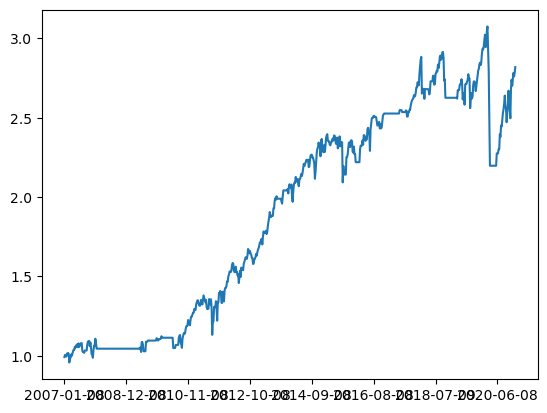

In [270]:
np.cumprod(1+trading_daily_ret_df).plot()

<Axes: >

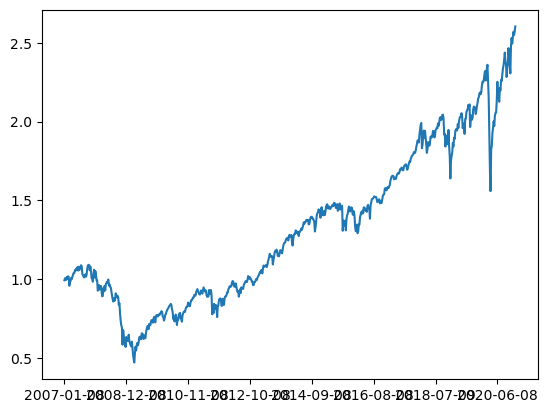

In [271]:
np.cumprod(1+benchmark_daily_ret_df).plot()

<Axes: >

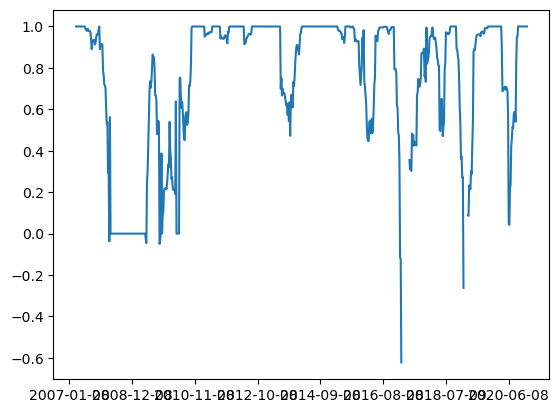

In [272]:
trading_daily_ret_df.rolling(12).corr(benchmark_daily_ret_df).plot()

In [35]:
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc, 1)

In [36]:
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.06142095328288114
annualized alpha:  -0.06278202310686101
annualized sharpe:  0.44943439259320617
mdd:  0.2853201781358563
daily win rate:  0.4015444015444015


<Axes: >

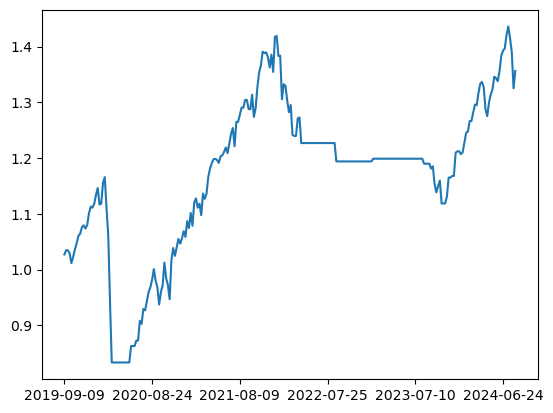

In [37]:
np.cumprod(1+trading_daily_ret_df).plot()

In [276]:
np.log(np.cumprod(1+trading_daily_ret_df)[-1])/len(trading_daily_ret_df)*252

0.33223123175832797

<Axes: >

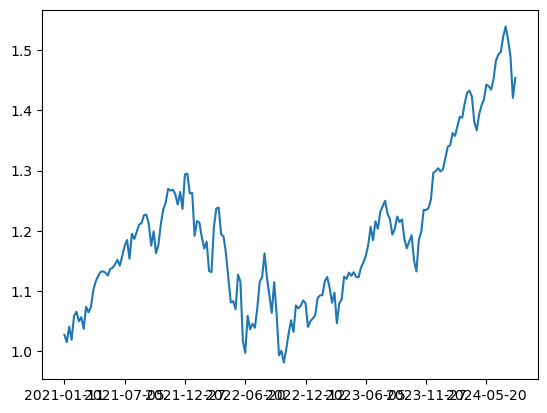

In [277]:
np.cumprod(1+benchmark_daily_ret_df).plot()

<Axes: >

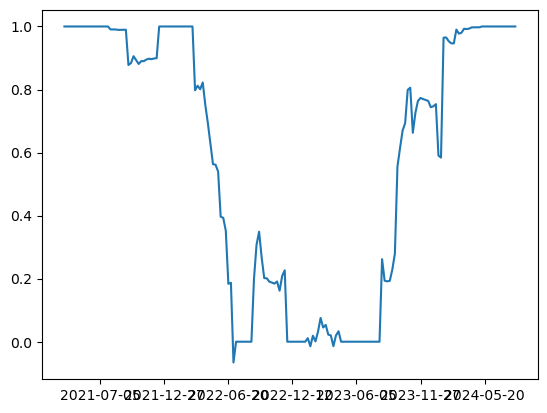

In [278]:
trading_daily_ret_df.rolling(12).corr(benchmark_daily_ret_df).plot()

In [29]:
signal_gp = pd.unique(signal_df.signal)
concat_signal_instrument_df = pd.merge(instrument_data_df, signal_df, how = 'inner', left_index = True, right_index = True)
concat_signal_instrument_df['ret'] = concat_signal_instrument_df.Open.pct_change().shift(-1)
concat_signal_instrument_df.dropna(inplace = True)

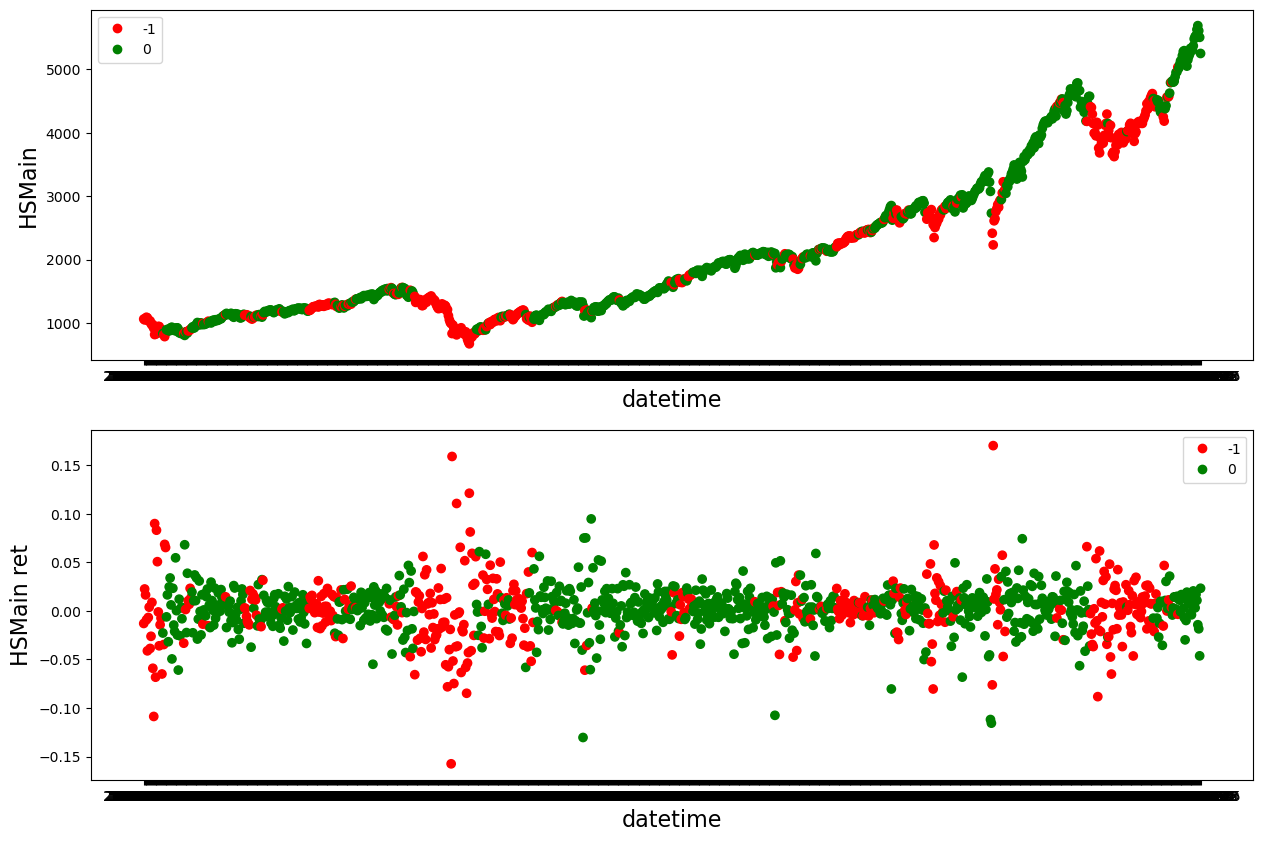

In [280]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

color_ls = ListedColormap(['r','b','g'])

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
scatter = plt.scatter(np.array(concat_signal_instrument_df.index), np.array(concat_signal_instrument_df.Open), c = np.array(concat_signal_instrument_df.signal), cmap = color_ls )
plt.legend(handles = scatter.legend_elements()[0], labels = [-1, 0 , 1])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("HSMain", fontsize=16)

plt.subplot(2,1,2)
scatter = plt.scatter(np.array(concat_signal_instrument_df.index), np.array(concat_signal_instrument_df.ret), c = np.array(concat_signal_instrument_df.signal), cmap = color_ls )
plt.legend(handles = scatter.legend_elements()[0], labels = [-1, 0 , 1])
plt.xlabel("datetime", fontsize=16)
plt.ylabel("HSMain ret", fontsize=16)
#plt.subplot(2,1,2)
#for i in range(len(signal_gp)):
#    color = color_ls[i]
#    signal = signal_gp[i]
#    want = list(concat_signal_instrument_df.signal == signal)
#    x = list(concat_signal_instrument_df.index[want])
#    y = list(concat_signal_instrument_df.ret[want])
#    plt.scatter(x, y, c = color)
#plt.legend(signal_gp, fontsize=16)
#plt.xlabel("datetime", fontsize=16)
#plt.ylabel("HSMain ret", fontsize=16)
plt.show()

In [30]:
start_date = "2019-09-01"
end_date = "2024-08-01"

target_concat_df = concat_signal_instrument_df.loc[concat_signal_instrument_df.index >= start_date]
target_concat_df = target_concat_df.loc[target_concat_df.index <= end_date]
strategy_ret = np.cumprod(1+target_concat_df.signal * target_concat_df.ret)
benchmark_ret = np.cumprod(1+target_concat_df.ret)

<Axes: >

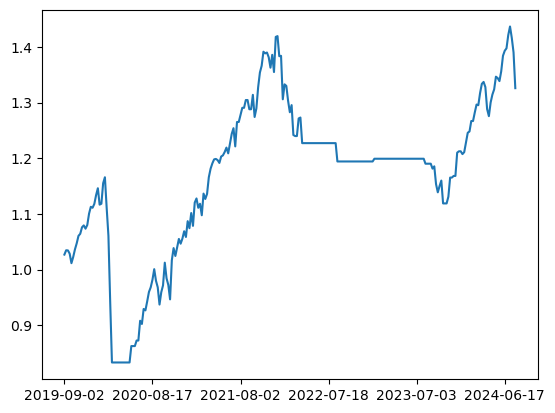

In [31]:
strategy_ret.plot()

<Axes: >

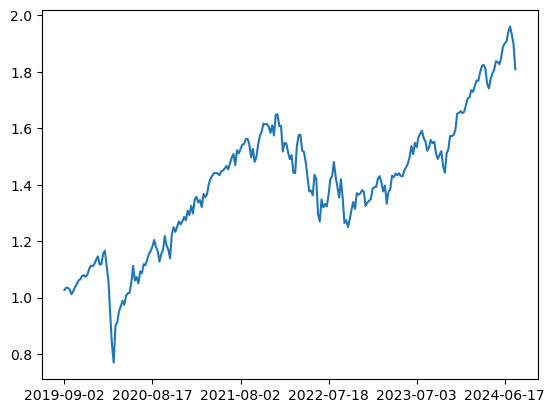

In [32]:
benchmark_ret.plot()

<Axes: >

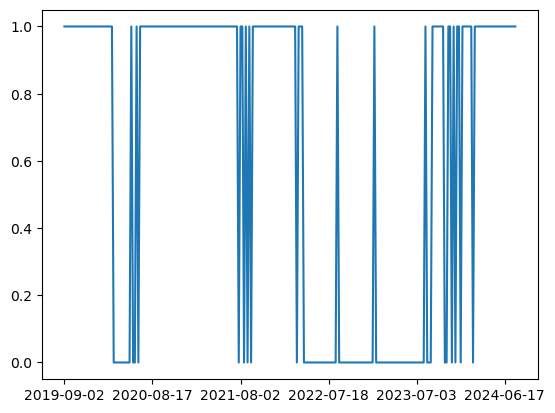

In [33]:
target_concat_df.signal.plot()

# NDX

## Weekly

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 126

In [58]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_126_w_freq_v2.csv",index_col = 0)

In [59]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [60]:
N = 2
W = 126
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.109384  0.109384  0.109384  0.109384  0.109384  0.087750  0.045655   
0.1  0.109384  0.109384  0.109384  0.109384  0.109384  0.087750  0.045655   
0.2  0.109384  0.109384  0.109384  0.109384  0.109384  0.087750  0.045655   
0.3  0.109384  0.109384  0.109384  0.109384  0.109384  0.087750  0.045655   
0.4  0.108288  0.108288  0.108288  0.108288  0.108288  0.086655  0.044559   
0.5  0.108661  0.108661  0.108661  0.108661  0.108661  0.087027  0.044932   
0.6  0.104559  0.104559  0.104559  0.104559  0.104559  0.082925  0.040830   
0.7  0.133301  0.133301  0.133301  0.133301  0.133301  0.111668  0.069572   
0.8  0.133301  0.133301  0.133301  0.133301  0.133301  0.111668  0.069572   
0.9  0.133301  0.133301  0.133301  0.133301  0.133301  0.111668  0.069572   

          0.7       0.8       0.9  
0.0 -0.013060 -0.023917 -0.023917  
0.1 -0.013060 -0.023917 -0.023917  
0.2 -0.013060 -0.023917 -0.02

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 252

In [61]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_252_w_freq_v2.csv",index_col = 0)

In [62]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [63]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.071523  0.071523  0.071523  0.071523  0.071523  0.070426 -0.001787   
0.1  0.071523  0.071523  0.071523  0.071523  0.071523  0.070426 -0.001787   
0.2  0.071523  0.071523  0.071523  0.071523  0.071523  0.070426 -0.001787   
0.3  0.071523  0.071523  0.071523  0.071523  0.071523  0.070426 -0.001787   
0.4  0.071523  0.071523  0.071523  0.071523  0.071523  0.070426 -0.001787   
0.5  0.072013  0.072013  0.072013  0.072013  0.072013  0.070916 -0.001297   
0.6  0.113421  0.113421  0.113421  0.113421  0.113421  0.112323  0.040110   
0.7  0.113421  0.113421  0.113421  0.113421  0.113421  0.112323  0.040110   
0.8  0.113421  0.113421  0.113421  0.113421  0.113421  0.112323  0.040110   
0.9  0.113421  0.113421  0.113421  0.113421  0.113421  0.112323  0.040110   

          0.7       0.8       0.9  
0.0 -0.041897 -0.041897 -0.041897  
0.1 -0.041897 -0.041897 -0.041897  
0.2 -0.041897 -0.041897 -0.04

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 504

In [64]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_504_w_freq_v2.csv",index_col = 0)

In [65]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [66]:
N = 2
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.182222  0.182222  0.182222  0.182222  0.182222  0.176048 -0.007654   
0.1  0.182222  0.182222  0.182222  0.182222  0.182222  0.176048 -0.007654   
0.2  0.182222  0.182222  0.182222  0.182222  0.182222  0.176048 -0.007654   
0.3  0.182222  0.182222  0.182222  0.182222  0.182222  0.176048 -0.007654   
0.4  0.182222  0.182222  0.182222  0.182222  0.182222  0.176048 -0.007654   
0.5  0.182531  0.182531  0.182531  0.182531  0.182531  0.176357 -0.007345   
0.6  0.182531  0.182531  0.182531  0.182531  0.182531  0.176357 -0.007345   
0.7  0.182531  0.182531  0.182531  0.182531  0.182531  0.176357 -0.007345   
0.8  0.182531  0.182531  0.182531  0.182531  0.182531  0.176357 -0.007345   
0.9  0.182531  0.182531  0.182531  0.182531  0.182531  0.176357 -0.007345   

          0.7       0.8       0.9  
0.0 -0.000309 -0.000309 -0.000309  
0.1 -0.000309 -0.000309 -0.000309  
0.2 -0.000309 -0.000309 -0.00

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 78

In [67]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_78_w_freq_v2.csv",index_col = 0)

In [68]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [69]:
N = 2
W = 78
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.117637  0.117637  0.117637  0.117637  0.116601  0.107482  0.050769   
0.1  0.117637  0.117637  0.117637  0.117637  0.116601  0.107482  0.050769   
0.2  0.117637  0.117637  0.117637  0.117637  0.116601  0.107482  0.050769   
0.3  0.117637  0.117637  0.117637  0.117637  0.116601  0.107482  0.050769   
0.4  0.107422  0.107422  0.107422  0.107422  0.106386  0.097267  0.040554   
0.5  0.120077  0.120077  0.120077  0.120077  0.119041  0.109922  0.053209   
0.6  0.122775  0.122775  0.122775  0.122775  0.121740  0.112620  0.055908   
0.7  0.139519  0.139519  0.139519  0.139519  0.138483  0.129363  0.072651   
0.8  0.139519  0.139519  0.139519  0.139519  0.138483  0.129363  0.072651   
0.9  0.139519  0.139519  0.139519  0.139519  0.138483  0.129363  0.072651   

          0.7       0.8       0.9  
0.0 -0.012840 -0.021882 -0.021882  
0.1 -0.012840 -0.021882 -0.021882  
0.2 -0.012840 -0.021882 -0.02

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 104

In [70]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_104_w_freq_v2.csv",index_col = 0)

In [71]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [72]:
N = 2
W = 104
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.109886  0.109886  0.109886  0.109886  0.109886  0.094622  0.050572   
0.1  0.109886  0.109886  0.109886  0.109886  0.109886  0.094622  0.050572   
0.2  0.109886  0.109886  0.109886  0.109886  0.109886  0.094622  0.050572   
0.3  0.109886  0.109886  0.109886  0.109886  0.109886  0.094622  0.050572   
0.4  0.108789  0.108789  0.108789  0.108789  0.108789  0.093525  0.049475   
0.5  0.113058  0.113058  0.113058  0.113058  0.113058  0.097794  0.053744   
0.6  0.107533  0.107533  0.107533  0.107533  0.107533  0.092270  0.048220   
0.7  0.133561  0.133561  0.133561  0.133561  0.133561  0.118297  0.074247   
0.8  0.133561  0.133561  0.133561  0.133561  0.133561  0.118297  0.074247   
0.9  0.133561  0.133561  0.133561  0.133561  0.133561  0.118297  0.074247   

          0.7       0.8       0.9  
0.0 -0.010960 -0.023675 -0.023675  
0.1 -0.010960 -0.023675 -0.023675  
0.2 -0.010960 -0.023675 -0.02

## Daily

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 126

In [73]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_126_d_freq_v2.csv",index_col = 0)

In [74]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [75]:
N = 2
W = 126
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.027387  0.027387  0.027387  0.027387  0.027651  0.031912 -0.017750   
0.1  0.027387  0.027387  0.027387  0.027387  0.027651  0.031912 -0.017750   
0.2  0.027387  0.027387  0.027387  0.027387  0.027651  0.031912 -0.017750   
0.3  0.027387  0.027387  0.027387  0.027387  0.027651  0.031912 -0.017750   
0.4  0.029721  0.029721  0.029721  0.029721  0.029985  0.034246 -0.015416   
0.5  0.053655  0.053655  0.053655  0.053655  0.053919  0.058181  0.008519   
0.6  0.075755  0.075755  0.075755  0.075755  0.076019  0.080280  0.030618   
0.7  0.094507  0.094507  0.094507  0.094507  0.094771  0.099032  0.049370   
0.8  0.094507  0.094507  0.094507  0.094507  0.094771  0.099032  0.049370   
0.9  0.094507  0.094507  0.094507  0.094507  0.094771  0.099032  0.049370   

          0.7       0.8       0.9  
0.0 -0.066022 -0.067230 -0.067120  
0.1 -0.066022 -0.067230 -0.067120  
0.2 -0.066022 -0.067230 -0.06

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 252

In [76]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_252_d_freq_v2.csv",index_col = 0)

In [77]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [78]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.120589  0.120589  0.120589  0.120589  0.120589  0.096026  0.021776   
0.1  0.120589  0.120589  0.120589  0.120589  0.120589  0.096026  0.021776   
0.2  0.120589  0.120589  0.120589  0.120589  0.120589  0.096026  0.021776   
0.3  0.120589  0.120589  0.120589  0.120589  0.120589  0.096026  0.021776   
0.4  0.120942  0.120942  0.120942  0.120942  0.120942  0.096378  0.022129   
0.5  0.149083  0.149083  0.149083  0.149083  0.149083  0.124519  0.050270   
0.6  0.135471  0.135471  0.135471  0.135471  0.135471  0.110908  0.036659   
0.7  0.135471  0.135471  0.135471  0.135471  0.135471  0.110908  0.036659   
0.8  0.135471  0.135471  0.135471  0.135471  0.135471  0.110908  0.036659   
0.9  0.135471  0.135471  0.135471  0.135471  0.135471  0.110908  0.036659   

          0.7       0.8       0.9  
0.0 -0.014882 -0.014882 -0.014882  
0.1 -0.014882 -0.014882 -0.014882  
0.2 -0.014882 -0.014882 -0.01

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 504

In [79]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_504_d_freq_v2.csv",index_col = 0)

In [80]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [81]:
instrument_data_df

Open
2000-01-03   3755.739990
2000-01-04   3766.570068
2000-01-05   3543.129883
2000-01-06   3488.310059
2000-01-07   3337.260010
...                  ...
2024-08-08  18102.050780
2024-08-09  18373.890630
2024-08-12  18548.230470
2024-08-13  18724.839840
2024-08-14  19043.759770

[6193 rows x 1 columns]

In [82]:
N = 2
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.101199  0.101199  0.101199  0.101199  0.101199  0.097022 -0.021289   
0.1  0.101199  0.101199  0.101199  0.101199  0.101199  0.097022 -0.021289   
0.2  0.101199  0.101199  0.101199  0.101199  0.101199  0.097022 -0.021289   
0.3  0.101199  0.101199  0.101199  0.101199  0.101199  0.097022 -0.021289   
0.4  0.101199  0.101199  0.101199  0.101199  0.101199  0.097022 -0.021289   
0.5  0.131188  0.131188  0.131188  0.131188  0.131188  0.127011  0.008700   
0.6  0.130397  0.130397  0.130397  0.130397  0.130397  0.126221  0.007910   
0.7  0.130397  0.130397  0.130397  0.130397  0.130397  0.126221  0.007910   
0.8  0.130397  0.130397  0.130397  0.130397  0.130397  0.126221  0.007910   
0.9  0.130397  0.130397  0.130397  0.130397  0.130397  0.126221  0.007910   

          0.7       0.8       0.9  
0.0 -0.029198 -0.029198 -0.029198  
0.1 -0.029198 -0.029198 -0.029198  
0.2 -0.029198 -0.029198 -0.02

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 3

Window : 252

In [112]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_NDX_DXY_UST_w_252_d_freq_v2.csv",index_col = 0)

In [113]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [114]:
N = 3
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.083034  0.083034  0.083034  0.083034  0.083034  0.074650  0.003121   
0.1  0.083034  0.083034  0.083034  0.083034  0.083034  0.074650  0.003121   
0.2  0.083034  0.083034  0.083034  0.083034  0.083034  0.074650  0.003121   
0.3  0.083034  0.083034  0.083034  0.083034  0.083034  0.074650  0.003121   
0.4  0.083191  0.083191  0.083191  0.083191  0.083191  0.074806  0.003277   
0.5  0.112087  0.112087  0.112087  0.112087  0.112087  0.103702  0.032174   
0.6  0.099839  0.099839  0.099839  0.099839  0.099839  0.091454  0.019926   
0.7  0.111910  0.111910  0.111910  0.111910  0.111910  0.103526  0.031997   
0.8  0.111910  0.111910  0.111910  0.111910  0.111910  0.103526  0.031997   
0.9  0.111910  0.111910  0.111910  0.111910  0.111910  0.103526  0.031997   

          0.7       0.8       0.9  
0.0 -0.028364 -0.028876 -0.028876  
0.1 -0.028364 -0.028876 -0.028876  
0.2 -0.028364 -0.028876 -0.02

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 3

Window : 378

In [115]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_NDX_DXY_UST_w_378_d_freq_v2.csv",index_col = 0)

In [116]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [117]:
N = 3
W = 378
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.057328  0.057328  0.057328  0.057328  0.057328  0.049100 -0.028367   
0.1  0.057328  0.057328  0.057328  0.057328  0.057328  0.049100 -0.028367   
0.2  0.057328  0.057328  0.057328  0.057328  0.057328  0.049100 -0.028367   
0.3  0.057328  0.057328  0.057328  0.057328  0.057328  0.049100 -0.028367   
0.4  0.057917  0.057917  0.057917  0.057917  0.057917  0.049688 -0.027779   
0.5  0.102774  0.102774  0.102774  0.102774  0.102774  0.094546  0.017079   
0.6  0.102700  0.102700  0.102700  0.102700  0.102700  0.094472  0.017005   
0.7  0.104100  0.104100  0.104100  0.104100  0.104100  0.095871  0.018405   
0.8  0.104100  0.104100  0.104100  0.104100  0.104100  0.095871  0.018405   
0.9  0.104100  0.104100  0.104100  0.104100  0.104100  0.095871  0.018405   

          0.7       0.8       0.9  
0.0 -0.046772 -0.046772 -0.046772  
0.1 -0.046772 -0.046772 -0.046772  
0.2 -0.046772 -0.046772 -0.04

### Model 6 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 252

Method : Map

In [13]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_NDX_DXY_UST_w_252_d_freq_v2_map.csv",index_col = 0)

In [14]:
instrument_data_df = pd.DataFrame(data_df["NDX_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [15]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.113273  0.113273  0.113273  0.113273  0.113273  0.091112  0.016801   
0.1  0.113273  0.113273  0.113273  0.113273  0.113273  0.091112  0.016801   
0.2  0.113273  0.113273  0.113273  0.113273  0.113273  0.091112  0.016801   
0.3  0.113273  0.113273  0.113273  0.113273  0.113273  0.091112  0.016801   
0.4  0.113870  0.113870  0.113870  0.113870  0.113870  0.091709  0.017398   
0.5  0.145109  0.145109  0.145109  0.145109  0.145109  0.122949  0.048637   
0.6  0.132433  0.132433  0.132433  0.132433  0.132433  0.110272  0.035961   
0.7  0.132433  0.132433  0.132433  0.132433  0.132433  0.110272  0.035961   
0.8  0.132433  0.132433  0.132433  0.132433  0.132433  0.110272  0.035961   
0.9  0.132433  0.132433  0.132433  0.132433  0.132433  0.110272  0.035961   

          0.7       0.8       0.9  
0.0 -0.019015 -0.019160 -0.019160  
0.1 -0.019015 -0.019160 -0.019160  
0.2 -0.019015 -0.019160 -0.01

# DJI

## Weekly

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 126

In [83]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_126_w_freq_v2.csv",index_col = 0)

In [84]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [85]:
N = 2
W = 126
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.030602 -0.030602 -0.030602 -0.030602 -0.030602 -0.043846 -0.069669   
0.1 -0.030602 -0.030602 -0.030602 -0.030602 -0.030602 -0.043846 -0.069669   
0.2 -0.030602 -0.030602 -0.030602 -0.030602 -0.030602 -0.043846 -0.069669   
0.3 -0.030602 -0.030602 -0.030602 -0.030602 -0.030602 -0.043846 -0.069669   
0.4  0.000535  0.000535  0.000535  0.000535  0.000535 -0.012709 -0.038532   
0.5  0.014246  0.014246  0.014246  0.014246  0.014246  0.001001 -0.024821   
0.6  0.020923  0.020923  0.020923  0.020923  0.020923  0.007678 -0.018144   
0.7  0.024932  0.024932  0.024932  0.024932  0.024932  0.011688 -0.014135   
0.8  0.024932  0.024932  0.024932  0.024932  0.024932  0.011688 -0.014135   
0.9  0.024932  0.024932  0.024932  0.024932  0.024932  0.011688 -0.014135   

          0.7       0.8       0.9  
0.0 -0.064886 -0.055534 -0.055534  
0.1 -0.064886 -0.055534 -0.055534  
0.2 -0.064886 -0.055534 -0.05

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 252

In [86]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_252_w_freq_v2.csv",index_col = 0)

In [87]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [88]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.001032  0.001032  0.001032  0.001032  0.001032 -0.000203 -0.034046   
0.1  0.001032  0.001032  0.001032  0.001032  0.001032 -0.000203 -0.034046   
0.2  0.001032  0.001032  0.001032  0.001032  0.001032 -0.000203 -0.034046   
0.3  0.001032  0.001032  0.001032  0.001032  0.001032 -0.000203 -0.034046   
0.4  0.001032  0.001032  0.001032  0.001032  0.001032 -0.000203 -0.034046   
0.5  0.002002  0.002002  0.002002  0.002002  0.002002  0.000766 -0.033077   
0.6  0.038660  0.038660  0.038660  0.038660  0.038660  0.037425  0.003582   
0.7  0.039611  0.039611  0.039611  0.039611  0.039611  0.038376  0.004533   
0.8  0.039611  0.039611  0.039611  0.039611  0.039611  0.038376  0.004533   
0.9  0.039611  0.039611  0.039611  0.039611  0.039611  0.038376  0.004533   

          0.7       0.8       0.9  
0.0 -0.038579 -0.038579 -0.038579  
0.1 -0.038579 -0.038579 -0.038579  
0.2 -0.038579 -0.038579 -0.03

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 504

In [89]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_504_w_freq_v2.csv",index_col = 0)

In [90]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [91]:
N = 2
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.017685  0.017685  0.017685  0.017685  0.017685  0.016641 -0.045496   
0.1  0.017685  0.017685  0.017685  0.017685  0.017685  0.016641 -0.045496   
0.2  0.017685  0.017685  0.017685  0.017685  0.017685  0.016641 -0.045496   
0.3  0.017685  0.017685  0.017685  0.017685  0.017685  0.016641 -0.045496   
0.4  0.017685  0.017685  0.017685  0.017685  0.017685  0.016641 -0.045496   
0.5  0.043057  0.043057  0.043057  0.043057  0.043057  0.042012 -0.020125   
0.6  0.063181  0.063181  0.063181  0.063181  0.063181  0.062137  0.000000   
0.7  0.063181  0.063181  0.063181  0.063181  0.063181  0.062137  0.000000   
0.8  0.063181  0.063181  0.063181  0.063181  0.063181  0.062137  0.000000   
0.9  0.063181  0.063181  0.063181  0.063181  0.063181  0.062137  0.000000   

          0.7       0.8       0.9  
0.0 -0.045496 -0.045496 -0.045496  
0.1 -0.045496 -0.045496 -0.045496  
0.2 -0.045496 -0.045496 -0.04

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 78

In [92]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_78_w_freq_v2.csv",index_col = 0)

In [93]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [94]:
N = 2
W = 78
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.006528 -0.006528 -0.006528 -0.006528 -0.008303 -0.023521 -0.044367   
0.1 -0.006528 -0.006528 -0.006528 -0.006528 -0.008303 -0.023521 -0.044367   
0.2 -0.006528 -0.006528 -0.006528 -0.006528 -0.008303 -0.023521 -0.044367   
0.3 -0.006528 -0.006528 -0.006528 -0.006528 -0.008303 -0.023521 -0.044367   
0.4  0.010859  0.010859  0.010859  0.010859  0.009085 -0.006134 -0.026980   
0.5  0.016625  0.016625  0.016625  0.016625  0.014851 -0.000368 -0.021214   
0.6  0.015185  0.015185  0.015185  0.015185  0.013411 -0.001808 -0.022654   
0.7  0.032690  0.032690  0.032690  0.032690  0.030915  0.015697 -0.005149   
0.8  0.045577  0.045577  0.045577  0.045577  0.043803  0.028584  0.007738   
0.9  0.045577  0.045577  0.045577  0.045577  0.043803  0.028584  0.007738   

          0.7       0.8       0.9  
0.0 -0.065122 -0.052106 -0.052106  
0.1 -0.065122 -0.052106 -0.052106  
0.2 -0.065122 -0.052106 -0.05

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : W

Hidden State : 2

Window : 104

In [95]:
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_104_w_freq_v2.csv",index_col = 0)

In [96]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [97]:
N = 2
W = 104
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'w', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.009264 -0.009264 -0.009264 -0.009264 -0.009264 -0.024661 -0.039450   
0.1 -0.009264 -0.009264 -0.009264 -0.009264 -0.009264 -0.024661 -0.039450   
0.2 -0.009264 -0.009264 -0.009264 -0.009264 -0.009264 -0.024661 -0.039450   
0.3 -0.009264 -0.009264 -0.009264 -0.009264 -0.009264 -0.024661 -0.039450   
0.4  0.017369  0.017369  0.017369  0.017369  0.017369  0.001972 -0.012817   
0.5  0.018851  0.018851  0.018851  0.018851  0.018851  0.003454 -0.011335   
0.6  0.013400  0.013400  0.013400  0.013400  0.013400 -0.001997 -0.016786   
0.7  0.034413  0.034413  0.034413  0.034413  0.034413  0.019016  0.004227   
0.8  0.034413  0.034413  0.034413  0.034413  0.034413  0.019016  0.004227   
0.9  0.034413  0.034413  0.034413  0.034413  0.034413  0.019016  0.004227   

          0.7       0.8       0.9  
0.0 -0.058201 -0.043677 -0.043677  
0.1 -0.058201 -0.043677 -0.043677  
0.2 -0.058201 -0.043677 -0.04

## Daily

### Model 1 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 126

In [98]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_126_d_freq_v2.csv",index_col = 0)

In [99]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [100]:
N = 2
W = 126
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.029542 -0.029542 -0.029542 -0.029542 -0.029542 -0.049916 -0.070196   
0.1 -0.029542 -0.029542 -0.029542 -0.029542 -0.029542 -0.049916 -0.070196   
0.2 -0.029542 -0.029542 -0.029542 -0.029542 -0.029542 -0.049916 -0.070196   
0.3 -0.029542 -0.029542 -0.029542 -0.029542 -0.029542 -0.049916 -0.070196   
0.4 -0.024051 -0.024051 -0.024051 -0.024051 -0.024051 -0.044425 -0.064705   
0.5  0.003958  0.003958  0.003958  0.003958  0.003958 -0.016416 -0.036695   
0.6  0.005473  0.005473  0.005473  0.005473  0.005473 -0.014901 -0.035181   
0.7  0.034066  0.034066  0.034066  0.034066  0.034066  0.013692 -0.006588   
0.8  0.034066  0.034066  0.034066  0.034066  0.034066  0.013692 -0.006588   
0.9  0.034066  0.034066  0.034066  0.034066  0.034066  0.013692 -0.006588   

          0.7       0.8       0.9  
0.0 -0.061384 -0.063460 -0.063608  
0.1 -0.061384 -0.063460 -0.063608  
0.2 -0.061384 -0.063460 -0.06

### Model 2 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 252

In [101]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_252_d_freq_v2.csv",index_col = 0)

In [102]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [103]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.049265  0.049265  0.049265  0.049265  0.049265  0.037234 -0.020092   
0.1  0.049265  0.049265  0.049265  0.049265  0.049265  0.037234 -0.020092   
0.2  0.049265  0.049265  0.049265  0.049265  0.049265  0.037234 -0.020092   
0.3  0.049265  0.049265  0.049265  0.049265  0.049265  0.037234 -0.020092   
0.4  0.045639  0.045639  0.045639  0.045639  0.045639  0.033608 -0.023718   
0.5  0.038565  0.038565  0.038565  0.038565  0.038565  0.026533 -0.030793   
0.6  0.065559  0.065559  0.065559  0.065559  0.065559  0.053527 -0.003799   
0.7  0.065559  0.065559  0.065559  0.065559  0.065559  0.053527 -0.003799   
0.8  0.065559  0.065559  0.065559  0.065559  0.065559  0.053527 -0.003799   
0.9  0.065559  0.065559  0.065559  0.065559  0.065559  0.053527 -0.003799   

          0.7       0.8       0.9  
0.0 -0.016293 -0.016293 -0.016293  
0.1 -0.016293 -0.016293 -0.016293  
0.2 -0.016293 -0.016293 -0.01

### Model 3 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 504

In [104]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_504_d_freq_v2.csv",index_col = 0)

In [105]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [106]:
N = 2
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.006721 -0.006721 -0.006721 -0.006721 -0.006721 -0.015195 -0.045178   
0.1 -0.006721 -0.006721 -0.006721 -0.006721 -0.006721 -0.015195 -0.045178   
0.2 -0.006721 -0.006721 -0.006721 -0.006721 -0.006721 -0.015195 -0.045178   
0.3 -0.006721 -0.006721 -0.006721 -0.006721 -0.006721 -0.015195 -0.045178   
0.4 -0.006721 -0.006721 -0.006721 -0.006721 -0.006721 -0.015195 -0.045178   
0.5  0.009249  0.009249  0.009249  0.009249  0.009249  0.000776 -0.029208   
0.6  0.039715  0.039715  0.039715  0.039715  0.039715  0.031242  0.001258   
0.7  0.039715  0.039715  0.039715  0.039715  0.039715  0.031242  0.001258   
0.8  0.039715  0.039715  0.039715  0.039715  0.039715  0.031242  0.001258   
0.9  0.039715  0.039715  0.039715  0.039715  0.039715  0.031242  0.001258   

          0.7       0.8       0.9  
0.0 -0.046436 -0.046436 -0.046436  
0.1 -0.046436 -0.046436 -0.046436  
0.2 -0.046436 -0.046436 -0.04

### Model 4 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 3

Window : 504

In [107]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_3_DJI_DXY_UST_w_504_d_freq_v2.csv",index_col = 0)

In [108]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [111]:
N = 3
W = 504
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0 -0.041405 -0.041405 -0.041405 -0.041405 -0.041405 -0.047815 -0.063893   
0.1 -0.041405 -0.041405 -0.041405 -0.041405 -0.041405 -0.047815 -0.063893   
0.2 -0.041405 -0.041405 -0.041405 -0.041405 -0.041405 -0.047815 -0.063893   
0.3 -0.041405 -0.041405 -0.041405 -0.041405 -0.041405 -0.047815 -0.063893   
0.4 -0.041405 -0.041405 -0.041405 -0.041405 -0.041405 -0.047815 -0.063893   
0.5 -0.021386 -0.021386 -0.021386 -0.021386 -0.021386 -0.027796 -0.043875   
0.6  0.001334  0.001334  0.001334  0.001334  0.001334 -0.005076 -0.021154   
0.7  0.021871  0.021871  0.021871  0.021871  0.021871  0.015462 -0.000617   
0.8  0.021871  0.021871  0.021871  0.021871  0.021871  0.015462 -0.000617   
0.9  0.021871  0.021871  0.021871  0.021871  0.021871  0.015462 -0.000617   

          0.7       0.8       0.9  
0.0 -0.063276 -0.063276 -0.063276  
0.1 -0.063276 -0.063276 -0.063276  
0.2 -0.063276 -0.063276 -0.06

### Model 5 : GHMM

Input : Ret / DXY / UST 10Y / change in Yield Curve Slope

Freq : D

Hidden State : 2

Window : 252

Mthod : Map

In [9]:
data_df = pd.read_excel("US_HMM_data_input_1d.xlsx", index_col = 0)
signal_info_df = pd.read_csv("GHMM_hs_2_DJI_DXY_UST_w_252_d_freq_v2_map.csv",index_col = 0)

In [10]:
instrument_data_df = pd.DataFrame(data_df["DJI_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

In [12]:
N = 2
W = 252
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"

backtest_long_short_thres(signal_info_df,instrument_data_df, N,W, signal_type, tc, train_start_date, train_end_date, 'd', 1)

annualized ret
          0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
0.0  0.041662  0.041662  0.041662  0.041662  0.041662  0.031358 -0.028431   
0.1  0.041662  0.041662  0.041662  0.041662  0.041662  0.031358 -0.028431   
0.2  0.041662  0.041662  0.041662  0.041662  0.041662  0.031358 -0.028431   
0.3  0.041662  0.041662  0.041662  0.041662  0.041662  0.031358 -0.028431   
0.4  0.039227  0.039227  0.039227  0.039227  0.039227  0.028923 -0.030865   
0.5  0.027324  0.027324  0.027324  0.027324  0.027324  0.017021 -0.042768   
0.6  0.061786  0.061786  0.061786  0.061786  0.061786  0.051482 -0.008307   
0.7  0.061786  0.061786  0.061786  0.061786  0.061786  0.051482 -0.008307   
0.8  0.061786  0.061786  0.061786  0.061786  0.061786  0.051482 -0.008307   
0.9  0.061786  0.061786  0.061786  0.061786  0.061786  0.051482 -0.008307   

          0.7       0.8       0.9  
0.0 -0.020124 -0.020124 -0.020124  
0.1 -0.020124 -0.020124 -0.020124  
0.2 -0.020124 -0.020124 -0.02

# Betting Scheme

In [147]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"
test_start_date = "2021-01-01"
long_thres = 0.3
short_thres = 0.8

signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2.csv",index_col = 0)
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N)
backtest_obj = backtest(signal_df, instrument_data_df, 'w', signal_info_df)

trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, 1)
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc, 1)
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.07383717420098491
annualized alpha:  0.005673996720936728
annualized sharpe:  0.5356772993684434
mdd:  0.28532017813585625
daily win rate:  0.3967168262653899
annualized ret:  0.06855565099775021
annualized alpha:  -0.03497767531600915
annualized sharpe:  0.6771199678773069
mdd:  0.21177042563395201
daily win rate:  0.35978835978835977


<Axes: >

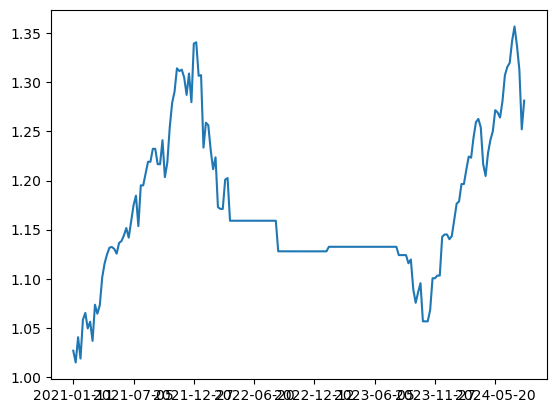

In [148]:
np.cumprod(1+trading_daily_ret_df).plot()

In [149]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"
test_start_date = "2021-01-01"
long_thres = 0.3
short_thres = 0.8

signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2.csv",index_col = 0)
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N)
backtest_obj = backtest(signal_df, instrument_data_df, 'w', signal_info_df)

trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, 1, "win_rate")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc, 1, "win_rate")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.0411236887363335
annualized alpha:  -0.027039488743714687
annualized sharpe:  0.49106575056066487
mdd:  0.21427054529000922
daily win rate:  0.3967168262653899
annualized ret:  0.04867533887026153
annualized alpha:  -0.05485798744349783
annualized sharpe:  0.7634992614535722
mdd:  0.1294055104857215
daily win rate:  0.35978835978835977


<Axes: >

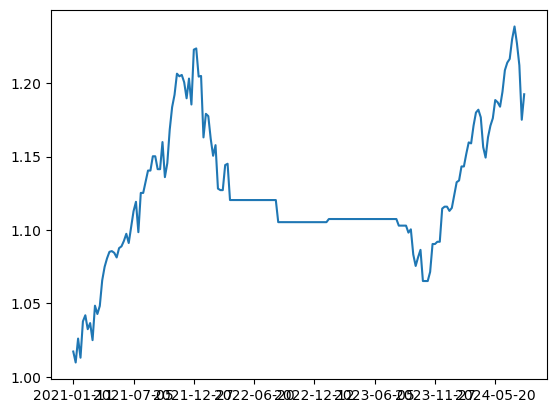

In [150]:
np.cumprod(1+trading_daily_ret_df).plot()

In [151]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"
test_start_date = "2021-01-01"
long_thres = 0.3
short_thres = 0.8

signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2.csv",index_col = 0)
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N)
backtest_obj = backtest(signal_df, instrument_data_df, 'w', signal_info_df)

trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, 1, "empirical_kelly")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc, 1, "empirical_kelly")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.05662777740344412
annualized alpha:  -0.011535400076604065
annualized sharpe:  0.4182139888592277
mdd:  0.2853201781358563
daily win rate:  0.3967168262653899
annualized ret:  0.0777731488481155
annualized alpha:  -0.025760177465643866
annualized sharpe:  0.7990610320002621
mdd:  0.182720936103216
daily win rate:  0.35978835978835977


<Axes: >

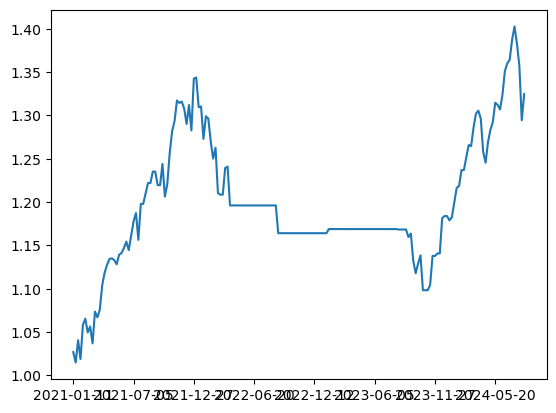

In [152]:
np.cumprod(1+trading_daily_ret_df).plot()

In [153]:
N = 3
W = 120
signal_type = 1
tc = 0.00001
train_start_date = "2007-01-01"
train_end_date = "2021-01-01"
test_start_date = "2021-01-01"
long_thres = 0.3
short_thres = 0.8

signal_info_df = pd.read_csv("GHMM_hs_3_SPX_DXY_UST_w_120_w_freq_v2.csv",index_col = 0)
data_df = pd.read_excel("US_HMM_data_input_1w.xlsx", index_col = 0)
instrument_data_df = pd.DataFrame(data_df["SPX_Fut_Next_Open"])
instrument_data_df.columns = ["Open"]
index_ls = [index.strftime("%Y-%m-%d") for index in instrument_data_df.index]
instrument_data_df.index = index_ls

signal_df = signal_generation(signal_info_df, signal_type, long_thres, short_thres, W , N)
backtest_obj = backtest(signal_df, instrument_data_df, 'w', signal_info_df)

trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.train(train_start_date, train_end_date, tc, 1, "model_kelly")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)
        
trading_daily_ret_df, benchmark_daily_ret_df, annualized_ret, annualized_alpha, sharpe_ratio, max_drawdown,  daily_win_rate = backtest_obj.test(test_start_date, tc, 1, "model_kelly")
print('annualized ret: ', annualized_ret)
print('annualized alpha: ', annualized_alpha)
print('annualized sharpe: ', sharpe_ratio)
print('mdd: ', max_drawdown)
print('daily win rate: ', daily_win_rate)

annualized ret:  0.0679064425583037
annualized alpha:  -0.00025673492174448087
annualized sharpe:  0.5003231733968785
mdd:  0.2853201781358563
daily win rate:  0.3967168262653899
annualized ret:  0.08433277515233695
annualized alpha:  -0.019200551161422413
annualized sharpe:  0.8547153398402103
mdd:  0.17728761055242165
daily win rate:  0.35978835978835977


<Axes: >

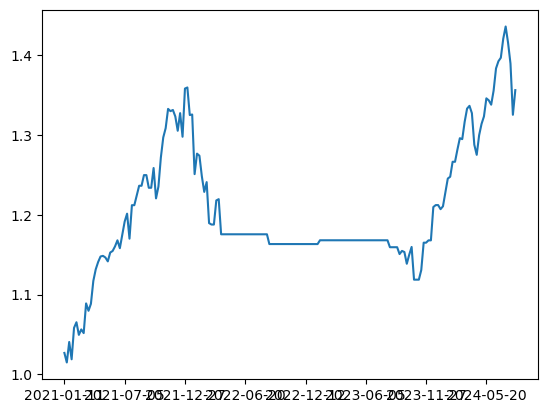

In [154]:
np.cumprod(1+trading_daily_ret_df).plot()